In [1]:
#!/usr/bin/python

import simulate_visibilities.Bulm as Bulm
import simulate_visibilities.simulate_visibilities as sv
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import time, ephem, sys, os, resource, datetime, warnings
import aipy as ap
import os
#os.environ['QT_QPA_PLATFORM']='offscreen'
import sys
import matplotlib.pyplot as plt
import healpy as hp
import healpy.rotator as hpr
import healpy.pixelfunc as hpf
import healpy.visufunc as hpv
import scipy.interpolate as si
import glob
import astropy
from astropy.io import fits
import HERA_MapMaking_VisibilitySimulation as mmvs
from pyuvdata import UVData, UVCal, UVFITS
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
import linsolve
from hera_cal.datacontainer import DataContainer
from astropy.time import Time
import omnical
import omnical.calibration_omni as omni
from memory_profiler import memory_usage as memuse
from collections import OrderedDict as odict
import pandas
import aipy.miriad as apm
import re
import copy
from hera_cal import utils, firstcal, cal_formats, redcal

PI = np.pi
TPI = PI * 2


def pixelize(sky, nside_distribution, nside_standard, nside_start, thresh, final_index, thetas, phis, sizes):
	# thetas = []
	# phis = []
	for inest in range(12 * nside_start ** 2):
		pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis,
						sizes)
		# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis)
		# thetas += newt.tolist()
		# phis += newp.tolist()
		# return np.array(thetas), np.array(phis)


def pixelize_helper(sky, nside_distribution, nside_standard, nside, inest, thresh, final_index, thetas, phis, sizes):
	# print "visiting ", nside, inest
	starti, endi = inest * nside_standard ** 2 / nside ** 2, (inest + 1) * nside_standard ** 2 / nside ** 2
	##local mean###if nside == nside_standard or np.std(sky[starti:endi])/np.mean(sky[starti:endi]) < thresh:
	if nside == nside_standard or np.std(sky[starti:endi]) < thresh:
		nside_distribution[starti:endi] = nside
		final_index[starti:endi] = len(thetas)  # range(len(thetas), len(thetas) + endi -starti)
		# return hp.pix2ang(nside, [inest], nest=True)
		newt, newp = hp.pix2ang(nside, [inest], nest=True)
		thetas += newt.tolist()
		phis += newp.tolist()
		sizes += (np.ones_like(newt) * nside_standard ** 2 / nside ** 2).tolist()
		# sizes += (np.ones_like(newt) / nside**2).tolist()

	else:
		# thetas = []
		# phis = []
		for jnest in range(inest * 4, (inest + 1) * 4):
			pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh, final_index, thetas,
							phis, sizes)
			# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh)
			# thetas += newt.tolist()
			# phis += newp.tolist()
			# return np.array(thetas), np.array(phis)


def dot(A, B, C, nchunk=10):
	if A.ndim != 2 or B.ndim != 2 or C.ndim != 2:
		raise ValueError("A B C not all have 2 dims: %i %i %i" % (str(A.ndim), str(B.ndim), str(C.ndim)))

	chunk = len(C) / nchunk
	for i in range(nchunk):
		C[i * chunk:(i + 1) * chunk] = A[i * chunk:(i + 1) * chunk].dot(B)
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = A[chunk * nchunk:].dot(B)


def ATNIA(A, Ni, C, nchunk=20):  # C=AtNiA
	if A.ndim != 2 or C.ndim != 2 or Ni.ndim != 1:
		raise ValueError("A, AtNiA and Ni not all have correct dims: %i %i %i"%(A.ndim, C.ndim, Ni.ndim))

	expected_time = 1.3e-11 * (A.shape[0]) * (A.shape[1])**2
	print "Estimated time for A %i by %i"%(A.shape[0], A.shape[1]), expected_time, "minutes",
	sys.stdout.flush()

	chunk = len(C) / nchunk
	for i in range(nchunk):
		ltm = time.time()
		C[i * chunk:(i + 1) * chunk] = np.einsum('ji,jk->ik', A[:, i * chunk:(i + 1) * chunk] * Ni[:, None], A)
		if expected_time >= 1.:
			print "%i/%i: %.5fmins"%(i, nchunk, (time.time() - ltm)/60.),
			sys.stdout.flush()
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = np.einsum('ji,jk->ik', A[:, chunk * nchunk:] * Ni[:, None], A)


def solve_phase_degen(data_xx, data_yy, model_xx, model_yy, ubls, plot=False):#data should be time by ubl at single freq. data * phasegensolution = model
	if data_xx.shape != data_yy.shape or data_xx.shape != model_xx.shape or data_xx.shape != model_yy.shape or data_xx.shape[1] != ubls.shape[0]:
		raise ValueError("Shapes mismatch: %s %s %s %s, ubl shape %s"%(data_xx.shape, data_yy.shape, model_xx.shape, model_yy.shape, ubls.shape))
	A = np.zeros((len(ubls) * 2, 2))
	b = np.zeros(len(ubls) * 2)

	nrow = 0
	for p, (data, model) in enumerate(zip([data_xx, data_yy], [model_xx, model_yy])):
		for u, ubl in enumerate(ubls):
			amp_mask = (np.abs(data[:, u]) > (np.median(np.abs(data[:, u])) / 2.))
			A[nrow] = ubl[:2]
			b[nrow] = omni.medianAngle(np.angle(model[:, u] / data[:, u])[amp_mask])
			nrow += 1
	phase_cal = omni.solve_slope(np.array(A), np.array(b), 1)
	if plot:
		plt.hist((np.array(A).dot(phase_cal)-b + PI)%TPI-PI)
		plt.title('phase fitting error')
		plt.show()

	#sooolve
	return phase_cal

class LastUpdatedOrderedDict(odict):
	'Store items in the order the keys were last added'

	def __setitem__(self, key, value):
		if key in self:
			del self[key]
		odict.__setitem__(self, key, value)

def S_casa_v_t(v, t = 2015.5):		
	S_0 = 2190.294 #S_casA_1GHz
	alpha =  0.725
	belta = 0.0148
	tau = 6.162*1.e-5

	a = -0.00633 #+-0.00024 year-1 
	b = 0.00039 #+-0.00008 year -1
	c = 1.509*1.e-7 #+-0.162*1.e-7 year-1
	
	v *= 1.e-3
	
	#print(v) # from MHz to GHz
	#print(t) # in decimal year
	
	S_casa_v = S_0 * v**(-alpha + belta * np.log(v)) * np.exp(-tau * v**(-2.1)) #S_0: 2015.5
	d_speed_log_v = a + b * np.log(v) + c * v**(-2.1) #a,b,c: 2005.0
	S_casa_v_t = np.exp((t - 2015.5) * d_speed_log_v + np.log(S_casa_v))
	
	#print(d_speed_log_v)
	
	return S_casa_v_t
	
def S_cyga_v(v, t = 2005):
	S_cyga_v = 3.835 * 1.e5 * v**(-0.718) * np.exp(-0.342 * (21.713/v)**2.1)
	
	return S_cyga_v

def UVData2AbsCalDict(datanames, pol_select=None, pop_autos=True, return_meta=False, filetype='miriad',
					  pick_data_ants=True):
	"""
	turn a list of pyuvdata.UVData objects or a list of miriad or uvfits file paths
	into the datacontainer dictionary form that AbsCal requires. This format is
	keys as antennas-pair + polarization format, Ex. (1, 2, 'xx')
	and values as 2D complex ndarrays with [0] axis indexing time and [1] axis frequency.

	Parameters:
	-----------
	datanames : list of either strings of data file paths or list of UVData instances
				to concatenate into a single dictionary

	pol_select : list of polarization strings to keep

	pop_autos : boolean, if True: remove autocorrelations

	return_meta : boolean, if True: also return antenna and unique frequency and LST arrays

	filetype : string, filetype of data if datanames is a string, options=['miriad', 'uvfits']
				can be ingored if datanames contains UVData objects.

	pick_data_ants : boolean, if True and return_meta=True, return only antennas in data

	Output:
	-------
	if return_meta is True:
		(data, flags, antpos, ants, freqs, times, lsts, pols)
	else:
		(data, flags)

	data : dictionary containing baseline-pol complex visibility data
	flags : dictionary containing data flags
	antpos : dictionary containing antennas numbers as keys and position vectors
	ants : ndarray containing unique antennas
	freqs : ndarray containing frequency channels (Hz)
	times : ndarray containing julian date bins of data
	lsts : ndarray containing LST bins of data (radians)
	pols : ndarray containing list of polarization index integers
	"""
	# check datanames is not a list
	if type(datanames) is not list and type(datanames) is not np.ndarray:
		if type(datanames) is str:
			# assume datanames is a file path
			uvd = UVData()
			suffix = os.path.splitext(datanames)[1]
			if filetype == 'uvfits' or suffix == '.uvfits':
				uvd.read_uvfits(datanames)
				uvd.unphase_to_drift()
			elif filetype == 'miriad':
				uvd.read_miriad(datanames)
		else:
			# assume datanames is a UVData instance
			uvd = datanames
	else:
		# if datanames is a list, check data types of elements
		if type(datanames[0]) is str:
			# assume datanames contains file paths
			uvd = UVData()
			suffix = os.path.splitext(datanames[0])[1]
			if filetype == 'uvfits' or suffix == '.uvfits':
				uvd.read_uvfits(datanames)
				uvd.unphase_to_drift()
			elif filetype == 'miriad':
				uvd.read_miriad(datanames)
		else:
			# assume datanames contains UVData instances
			uvd = reduce(operator.add, datanames)
	
	# load data
	d, f = firstcal.UVData_to_dict([uvd])
	
	# pop autos
	if pop_autos:
		for i, k in enumerate(d.keys()):
			if k[0] == k[1]:
				d.pop(k)
				f.pop(k)
	
	# turn into datacontainer
	data, flags = DataContainer(d), DataContainer(f)
	
	# get meta
	if return_meta:
		freqs = np.unique(uvd.freq_array)
		times = np.unique(uvd.time_array)
		lsts = np.unique(uvd.lst_array)
		antpos, ants = uvd.get_ENU_antpos(center=True, pick_data_ants=pick_data_ants)
		antpos = odict(zip(ants, antpos))
		pols = uvd.polarization_array
		return data, flags, antpos, ants, freqs, times, lsts, pols
	else:
		return data, flags


def UVData2AbsCalDict_Auto(datanames, pol_select=None, pop_autos=True, return_meta=False, filetype='miriad',
					  pick_data_ants=True):
	"""
	turn a list of pyuvdata.UVData objects or a list of miriad or uvfits file paths
	into the datacontainer dictionary form that AbsCal requires. This format is
	keys as antennas-pair + polarization format, Ex. (1, 2, 'xx')
	and values as 2D complex ndarrays with [0] axis indexing time and [1] axis frequency.

	Parameters:
	-----------
	datanames : list of either strings of data file paths or list of UVData instances
				to concatenate into a single dictionary

	pol_select : list of polarization strings to keep

	pop_autos : boolean, if True: remove autocorrelations

	return_meta : boolean, if True: also return antenna and unique frequency and LST arrays

	filetype : string, filetype of data if datanames is a string, options=['miriad', 'uvfits']
				can be ingored if datanames contains UVData objects.

	pick_data_ants : boolean, if True and return_meta=True, return only antennas in data

	Output:
	-------
	if return_meta is True:
		(data, flags, antpos, ants, freqs, times, lsts, pols, autocorr, autocorr_flags)
	else:
		(data, flags, autocorr, autocorr_flags))

	data : dictionary containing baseline-pol complex visibility data
	flags : dictionary containing data flags
	antpos : dictionary containing antennas numbers as keys and position vectors
	ants : ndarray containing unique antennas
	freqs : ndarray containing frequency channels (Hz)
	times : ndarray containing julian date bins of data
	lsts : ndarray containing LST bins of data (radians)
	pols : ndarray containing list of polarization index integers
	"""
	# check datanames is not a list
	if type(datanames) is not list and type(datanames) is not np.ndarray:
		if type(datanames) is str:
			# assume datanames is a file path
			uvd = UVData()
			suffix = os.path.splitext(datanames)[1]
			if filetype == 'uvfits' or suffix == '.uvfits':
				uvd.read_uvfits(datanames)
				uvd.unphase_to_drift()
			elif filetype == 'miriad':
				uvd.read_miriad(datanames)
		else:
			# assume datanames is a UVData instance
			uvd = datanames
	else:
		# if datanames is a list, check data types of elements
		if type(datanames[0]) is str:
			# assume datanames contains file paths
			uvd = UVData()
			suffix = os.path.splitext(datanames[0])[1]
			if filetype == 'uvfits' or suffix == '.uvfits':
				uvd.read_uvfits(datanames)
				uvd.unphase_to_drift()
			elif filetype == 'miriad':
				uvd.read_miriad(datanames)
		else:
			# assume datanames contains UVData instances
			uvd = reduce(operator.add, datanames)
	
	# load data
	d, f = firstcal.UVData_to_dict([uvd])
	autos = {}
	autos_flags = {}
	
	# pop autos
	if pop_autos:
		for i, k in enumerate(d.keys()):
			if k[0] == k[1]:
				autos[k] = d[k]
				autos_flags[k] = f[k]
				d.pop(k)
				f.pop(k)
	
	# turn into datacontainer
	data, flags = DataContainer(d), DataContainer(f)
	autos_pro, autos_flags_pro = DataContainer(autos), DataContainer(autos_flags)
	
	# get meta
	if return_meta:
		freqs = np.unique(uvd.freq_array)
		times = np.unique(uvd.time_array)
		lsts = np.unique(uvd.lst_array)
		antpos, ants = uvd.get_ENU_antpos(center=True, pick_data_ants=pick_data_ants)
		antpos = odict(zip(ants, antpos))
		pols = uvd.polarization_array
		return data, flags, antpos, ants, freqs, times, lsts, pols, autos_pro, autos_flags_pro
	else:
		return data, flags, autos_pro, autos_flags_pro


def set_lsts_from_time_array_hourangle(times, lon='21:25:41.9', lat='-30:43:17.5'):
	"""Set the lst_array based from the time_array."""
	lsts = []
	lst_array = np.zeros(len(np.unique(times)))
	# latitude, longitude, altitude = self.telescope_location_lat_lon_alt_degrees
	for ind, jd in enumerate(np.unique(times)):
		t = Time(jd, format='jd', location=(lon, lat))
		lst_array[np.where(np.isclose(
			jd, times, atol=1e-6, rtol=1e-12))] = t.sidereal_time('apparent').hourangle
	return lst_array

def set_lsts_from_time_array_radian(times, lon='21:25:41.9', lat='-30:43:17.5'):
	"""Set the lst_array based from the time_array."""
	lsts = []
	lst_array = np.zeros(len(np.unique(times)))
	# latitude, longitude, altitude = self.telescope_location_lat_lon_alt_degrees
	for ind, jd in enumerate(np.unique(times)):
		t = Time(jd, format='jd', location=(lon, lat))
		lst_array[np.where(np.isclose(
			jd, times, atol=1e-6, rtol=1e-12))] = t.sidereal_time('apparent').radian
	return lst_array

INSTRUMENT = ''

In [2]:
#####commandline inputs#####
if len(sys.argv) == 1:
	INSTRUMENT = 'hera47'
else:
	INSTRUMENT = sys.argv[1]#'miteor'#'mwa'#'hera-47''paper'

INSTRUMENT = 'hera47' #'hera47'; 'miteor'
print INSTRUMENT

tag = '-ampcal-' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.

AtNiA_only = False
if len(sys.argv) > 3 and sys.argv[3][:5] == 'atnia':
	AtNiA_only = True
	pixel_scheme_number = int(sys.argv[3][5:])
	
simulation_opt = 1

plotcoord = 'CG'
baseline_safety_factor = 0.3 #max_ubl = 1.4*lambda/baseline_safety_factor
crosstalk_type = 'autocorr'
#pixel_directory = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'

plot_pixelization = True and not AtNiA_only
plot_projection = True and not AtNiA_only
plot_data_error = True and not AtNiA_only

force_recompute = False
force_recompute_AtNiAi_eig = False
force_recompute_AtNiAi = False
force_recompute_S = False
force_recompute_SEi = False

C = 299.792458
kB = 1.3806488 * 1.e-23

try:
	__file__
except NameError:
	#script_dir = '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/simulate_visibilities/scripts'
	script_dir = os.path.join(DATA_PATH, '../../../HERA_MapMaking_VisibilitySimulation/scripts')
	pixel_directory = script_dir
	print 'Run IPython'
else:
	script_dir = os.path.dirname(os.path.realpath(__file__))
	pixel_directory = script_dir
	print 'Run Python'


hera47
Run IPython


In [3]:
len(sys.argv)
DATA_PATH

'/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data'

Nfiles: 1
/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA
small_Pol_xx is done.
/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA
small_Pol_yy is done.
/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/ObservingSession-1192201262/2458043/zen.2458043.12552.xx.HH.uvOR
/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/ObservingSession-1192201262/2458043/zen.2458043.12552.xx.HH.uvOR
raw_Pol_xx is done. 17.2959711552 seconds used.
/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/ObservingSession-1192201262/2458043/zen.2458043.12552.yy.HH.uvOR
/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


Pol_yy is done. 0.115926027298 seconds used.
Time_Average: 1; Frequency_Average: 1.
Remove_Times: -60; Remove_Freqs: -64.
rawData_Shape-(24, 37, 'xx'): (60, 64)
rawDflags_Shape-(24, 37, 'xx'): (60, 64)
rawAutocorr_Shape: (60, 64)
rawData_Freqs: 64
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(37, 53, 'xx'): (60, 64)
rawDflags_Shape-(37, 53, 'xx'): (60, 64)
rawAutocorr_Shape: (60, 64)
rawData_Freqs: 64
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(52, 53, 'xx'): (60, 64)
rawDflags_Shape-(52, 53, 'xx'): (60, 64)
rawAutocorr_Shape: (60, 64)
rawData_Freqs: 64
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(24, 38, 'xx'): (60, 64)
rawDflags_Shape-(24, 38, 'xx'): (60, 64)
rawAutocorr_Shape: (60, 64)
rawData_Freqs: 64
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(37, 39, 'xx'): (60, 64)
rawDflags_Shape-(37, 39, 'xx'): (60, 64)
rawAutocorr_Shape: (60, 64)
rawData_Freqs: 64
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(25, 39, 'xx'): (60, 64)
rawDflags_Shape-(25, 39, 'xx'): (6

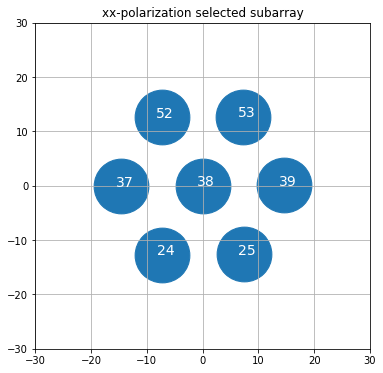

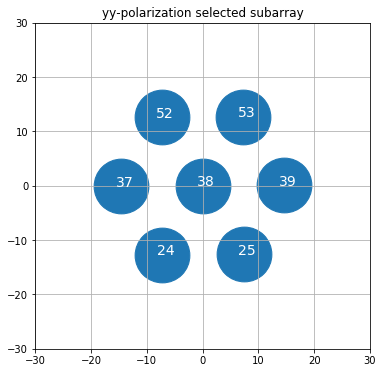

>>>>>>Used nUBL = 9, nt = 60.
Frequencies: 
[ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161.
 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175.
 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189.
 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203.
 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217.
 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231.
 232. 233. 234. 235. 236. 237. 23

In [4]:
####################################################
################data file and load beam##############
####################################################
if INSTRUMENT == 'miteor':
# 	Simulation = True
# 	Use_SimulatedData = False
# 	Use_Simulation_noise = False
	
	sys.stdout.flush()
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = True
	From_File_Data = True
	Keep_Red = False
	Absolute_Calibration = False
	Absolute_Calibration_red = False
	Absolute_Calibration_mfreq = False
	Absolute_Calibration_dred = False
	Absolute_Calibration_dred_mfreq = False
	PointSource_AbsCal = False
	Absolute_Calibration_dred_mfreq_pscal = False
	
	Use_AbsCal = False  # Use Model calculated noise which is just fullsim autocorr calculated noise.
	Use_PsAbsCal = False  # higher priority over Use_AbsCal and Use_Fullsim_Noise. if comply_ps2mod_autocorr then become just fullsim autocorr calculated noise.
	comply_ps2mod_autocorr = False
	Use_Fullsim_Noise = False  # Use fullsim autocorr calculated noise.
	
	Replace_Data = True	
	
	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2  # .1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2  # .2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32  # Determine the resolution of GSM of sky
	
	pre_calibrate = True
	tag = '-ampcal-' if pre_calibrate else ''  # '-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.
	pre_ampcal = ('ampcal' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = False
	nside_beamweight = 16  # Determin shape of A matrix
	
	Erase = True
	
	Add_S_diag = False
	Add_Rcond = True
	Data_Deteriorate = False
	
	S_type = 'dyS_lowadduniform_lowI'  # 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data
	# 	S_type = 'dyS_lowadduniform_min18I' if Add_S_diag else 'no_use' #'dyS_lowadduniform_minI', 'dyS_lowadduniform_I', 'dyS_lowadduniform_lowI', 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data
	rcond_list = 10. ** np.arange(-6., -0., 1.)
	if Data_Deteriorate:
		S_type += '-deteriorated-'
	else:
		pass
	
	Integration_Time = 2.7  # seconds
	Frequency_Bin = 0.5 * 1.e6  # Hz
    
	lat_degree = 45.2977
	lst_offset = 5.#lsts will be wrapped around [lst_offset, 24+lst_offset]
    
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2016_01_20-ampcal'#'_seccasa.rad'#
		vartag = '_2016_01_20-ampcal'#''#
	else:
		datatag = '_2016_01_20'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2016_01_20'#'_2016_01_20_avg_unpollockx100'#''#
#	datadir = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'
	datadir = script_dir + '/../Output/'
	antpairs = None
	# deal with beam: create a callable function of the form y(freq) in MHz and returns 2 by npix
	
	
	############################################ Load Beam and Visibility Data ###########################################
	flist = {}
	vis_freq_list = flist[0] = flist[1] = np.array([126.83333,127.6667,128.5000,129.3333,130.1667,131.0000,131.8333,132.6667,133.5000,134.3333,135.1667,136.0000,136.8333,137.6667,139.3333,140.0000,141.83333,142.6667,143.5000,144.3333,145.0000,145.1667,146.0000,146.6667,147.5000,148.3333,150.8333,151.6667,152.5000,153.3333,154.1667,155.0000,155.8333,156.0000,156.6667,156.8333,159.3333,161.8333,164.3333,166.8333,167.8333,170.3333,172.8333])
	freq = vis_freq_selected = 150.8333 #MHz
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	
	bnside = 64 #Depend on beam pattern data
	freqs = range(110, 200, 10)
	local_beam_unpol = si.interp1d(freqs, np.array([la.norm(np.loadtxt(
		script_dir + '/../data/MITEoR/beam/%s.txt'%(p), skiprows=0).reshape(
		(len(freqs), 12 * bnside ** 2, 4)), axis=-1)**2 for p in ['x', 'y']]).transpose(1, 0, 2), axis=0)
	Plot_Beam = True
	if Plot_Beam:
		plt.figure(0)
		#ind = np.where(beam_freqs == freq)[0][0]
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		plt.show(block=False)
		#plt.gcf().clear()
			#plt.clf()
			#plt.close()
			
	time_vis_data = np.array([np.loadtxt(script_dir + '/../data/MITEoR/visibilities/%sMHz_%s%s_A.txt'%(vis_freq_selected,p,p)) for p in ['x','y']])
	
	vis_data = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex128')
	var_data = time_vis_data[:,1:,3::3]
	
	tlist = time_vis_data[0,1:,0]
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = lsts = tlist[tmask]
	nt = nt_used = len(tlist)
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	nUBL = int(len(time_vis_data[0,0,:])/3)
	
	ubls = {}
	for p in range(2):
		ubls[['x','y'][p]] = time_vis_data[p,0,1:].reshape((nUBL,3))		
	common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')
                
	redundancy = used_redundancy = {}
	for i in range(2):
		used_redundancy[i] = redundancy[i] = np.ones_like(ubl_index)
        
	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()	
	
	
elif INSTRUMENT == 'hera47':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = True
	From_File_Data = True
	Keep_Red = False
	
	Absolute_Calibration = False
	Absolute_Calibration_red = False
	Absolute_Calibration_mfreq = False
	Absolute_Calibration_dred = False
	
	Absolute_Calibration_dred_mfreq = True # The only working Model Calibration Method.
	Fake_wgts_dred_mfreq = True # Remove Flags for Model Calibration.
	PointSource_AbsCal = False
	PointSource_AbsCal_SingleFreq = False if PointSource_AbsCal else False
	Absolute_Calibration_dred_mfreq_pscal = False
	
	Use_AbsCal = True if Absolute_Calibration_dred_mfreq else False  # Use Model calculated noise which is just fullsim autocorr calculated noise and data.
	Use_PsAbsCal = True if PointSource_AbsCal else False  # higher priority over Use_AbsCal and Use_Fullsim_Noise. if comply_ps2mod_autocorr then become just fullsim autocorr calculated noise. To use Pscaled data.
	comply_ps2mod_autocorr = False
	Use_Fullsim_Noise = False  # Use fullsim autocorr calculated noise.
	
	Replace_Data = True
	
	pre_calibrate = False
	tag = '-ampcal-' if pre_calibrate else ''  # '-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.
	pre_ampcal = ('ampcal' in tag)
	pre_phscal = True
	pre_addcal = False
	fit_for_additive = True
	
	Erase = True
	
	Add_S_diag = False
	Add_Rcond = True
	
	Small_ModelData = False
	Model_Calibration = False
	
	Data_Deteriorate =  False
	
	Time_Expansion_Factor = 73. if Use_SimulatedData else 1.
	Lst_Hourangle = True
	
	Compress_Average = True
	Time_Average = 12
	Frequency_Average = 16 if not Small_ModelData else 1
	Mocal_time_bin_temp = 600
	Mocal_freq_bin_temp = 600
	Precal_time_bin_temp = 600 
	
	sys.stdout.flush()
	
	lat_degree = -30.72153  # lon='21:25:41.9' lat='-30:43:17.5'
	lst_offset = 1.43  # lsts will be wrapped around [lst_offset, 24+lst_offset]
	
	Integration_Time = 11  # seconds
	Frequency_Bin = 1.625 * 1.e6  # Hz
	
	S_type = 'dyS_lowadduniform_min4I' if Add_S_diag else 'no_use'  # 'dyS_lowadduniform_minI', 'dyS_lowadduniform_I', 'dyS_lowadduniform_lowI', 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data
	rcond_list = 10. ** np.arange(-20., -1., 1.)
	if Data_Deteriorate:
		S_type += '-deteriorated-'
	else:
		pass

	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2  # .1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2  # .2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32 # starting point to calculate dynamic A
	nside_standard = 32  # resolution of sky, dynamic A matrix length of a row before masking.
	nside_beamweight = 32  # undynamic A matrix shape
	bnside = 64  # beam pattern data resolution
	
	#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2018'  # '_seccasa.rad'#
		vartag = '_2018'  # ''#
	else:
		datatag = '_2018_ampcaled'  # '_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2018_ampcaled'  # '_2016_01_20_avg_unpollockx100'#''#
	datadir = script_dir + '/../Output/'
	antpairs = None
	
	#######################################################################################################
	##################################### Load Visibility Data ###########################################
	# specify model file and load into UVData, load into dictionary
	timer_loading = time.time()
	model_fname = {}
	model = {}
	mflags = {}
	mantpos = {}
	mants = {}
	model_freqs = {}
	model_times = {}
	model_lsts = {}
	model_pols = {}
	model_autos = {}
	model_autos_flags = {}
	
	data_fname = {}
	data_fname_full = {}
	dflags = {}
	data = {}
	antpos = {}
	ants = {}
	data_freqs = {}
	data_times = {}
	data_lsts = {}
	data_pols = {}
	data_autos = {}
	data_autos_flags = {}
	
	fulldflags = {}
	
	data_fnames = {}
	files_basses = {}
	file_times = {}
	
	autocorr_data_mfreq = {}  # np.zeros((2, Ntimes, Nfreqs))
	autocorr_data = {}
	Nfiles = min(73, len(glob.glob("{0}/zen.*.*.xx.HH.uvOR".format(DATA_PATH + '/ObservingSession-1192201262/2458043/'))), len(glob.glob("{0}/zen.*.*.yy.HH.uvOR".format(DATA_PATH + '/ObservingSession-1192201262/2458043/'))))
	
	flist = {}
	index_freq = {}
	
	try:
		data_fnames[0] = xxfiles = sorted((glob.glob("{0}/zen.*.*.xx.HH.uvOR".format(DATA_PATH + '/ObservingSession-1192201262/2458043/'))))[:Nfiles]
		data_fnames[1] = yyfiles = sorted((glob.glob("{0}/zen.*.*.yy.HH.uvOR".format(DATA_PATH + '/ObservingSession-1192201262/2458043/'))))[:Nfiles]
		
		file_times[0] = xxfile_bases = map(os.path.basename, xxfiles)
		file_times[1] = yyfile_bases = map(os.path.basename, yyfiles)
		
		file_times[0] = xxfile_times = np.array(map(lambda x: '.'.join(os.path.basename(x).split('.')[1:3]), xxfiles), np.float)
		file_times[1] = yyfile_times = np.array(map(lambda y: '.'.join(os.path.basename(y).split('.')[1:3]), yyfiles), np.float)
		
		print ('Nfiles: %s' % Nfiles)
	except:
		pass
	
	if Small_ModelData:
		if Model_Calibration:
			
			#model = mflags = mantpos = mant = model_freqs = model_times = model_lsts = model_pols = {}
			for i in range(2):
				model_fname[i] = os.path.join(DATA_PATH, "zen.2458042.12552.%s.HH.uvXA" % ['xx', 'yy'][i])  # /Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				# model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
				if i == 1:
					try:
						# data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
						if not os.path.isfile(model_fname[i]):
							model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA")
					except:
						pass
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i], model_pols[i], model_autos[i], model_autos_flags[i]) = UVData2AbsCalDict_Auto(model_fname[i], return_meta=True)
				print('model_Pol_%s is done.' % ['xx', 'yy'][i])
		# specify data file and load into UVData, load into dictionary
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, "zen.2458043.12552.%s.HH.uvORA" % ['xx', 'yy'][i])  # zen.2457698.40355.xx.HH.uvcA
			if i == 1:
				try:
					# data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
					if not os.path.isfile(data_fname[i]):
						data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
				except:
					pass
			data_fname_full[i] = os.path.join(DATA_PATH, 'ObservingSession-1192201262/2458043/zen.2458043.12552.%s.HH.uvOR' % ['xx', 'yy'][i])
			# (data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], data_pols[i], data_autos[i], data_autos_flags[i]) = UVData2AbsCalDict_Auto(data_fname[i], return_meta=True)
			print('small_Pol_%s is done.' % ['xx', 'yy'][i])

		for i in range(2):
			flist[i] = np.array(data_freqs[i]) / 10 ** 6
			try:
				index_freq[i] = np.where(flist[i] == 150)[0][0]
			#		index_freq = 512
			except:
				index_freq[i] = len(flist[i]) / 2
		
		if Replace_Data:
			
			findex_list = {}
			autocorr_data_mfreq_ff = {}
			data_full = {}
			dflags_full = {}
			antpos_full = {}
			ants_full = {}
			data_freqs_full = {}
			
			for i in range(2):
				timer = time.time()
				(data_full[i], dflags_full[i], antpos_full[i], ants_full[i], data_freqs_full[i], data_times[i], data_lsts[i], data_pols[i], data_autos[i], data_autos_flags[i]) = UVData2AbsCalDict_Auto(data_fnames[i], return_meta=True)
				data_freqs_full[i] = data_freqs_full[i] / 1.e6
				findex_list[i] = np.array([np.where(data_freqs_full[i] == flist[i][j])[0][0] for j in range(len(flist[i]))])
				
				autocorr_data_mfreq[i] = np.mean(np.array([np.abs(data_autos[i][ants_full[i][k], ants_full[i][k], ['xx', 'yy'][i]]) for k in range(len(ants_full[i]))]), axis=0)
				print('raw_Pol_%s is done. %s seconds used.' % (['xx', 'yy'][i], time.time()-timer))
			# autocorr_data_mfreq[1] = np.mean(np.array([np.abs(uvd_yy.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
			
			data_ff = {}
			dflags_ff = {}
			findex = np.where(data_freqs_full[0] == 150)
			for i in range(2):
				timer = time.time()
				data_ff[i] = LastUpdatedOrderedDict()
				dflags_ff[i] = LastUpdatedOrderedDict()
				autocorr_data_mfreq_ff[i] = np.zeros(autocorr_data_mfreq[i][:, findex_list[i]].shape)
				
				for id_f in range(len(findex_list[i])):
					#autocorr_data_mfreq_ff[i] = autocorr_data_mfreq[i][:, findex_list[i]]
					if id_f <= (len(findex_list[i]) - 2):
						autocorr_data_mfreq_ff[i][:, id_f] = np.mean(autocorr_data_mfreq[i][:, findex_list[i][id_f]: findex_list[i][id_f+1]], axis = -1)
					else:
						autocorr_data_mfreq_ff[i][:, id_f] = np.mean(autocorr_data_mfreq[i][:, findex_list[i][id_f]:], axis = -1)
				
				for id_key, key in enumerate(dflags[i].keys()):
					data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = np.zeros(data_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i]].shape)
					dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = np.zeros(dflags_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i]].shape)
					for id_f in range(len(findex_list[i])):
						if id_f <= (len(findex_list[i]) - 2):
							data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, id_f] = np.mean(data_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i][id_f]: findex_list[i][id_f+1]], axis = -1)
							dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, id_f] = np.mean(dflags_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i][id_f]: findex_list[i][id_f + 1]], axis=-1) > 0
						else:
							data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, id_f] = np.mean(data_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i][id_f]:], axis = -1)
							dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, id_f] = np.mean(dflags_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i][id_f]:], axis=-1)
						# data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = np.array([np.mean(data_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i][id_f]: findex_list[i][id_f+1] if id_f <= len(findex_list[i] - 2) else None], axis = -1) if id_f <= len(findex_list[i] - 2) else np.mean(data_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i][id_f]:], axis = -1)  for id_f in range(len(findex_list[i]))])
					# key[2] = 'xx' if i == 0 else 'yy'
					# data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = data_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i]]  # if i == 0 else uvd_yy.get_data((key[0], key[1]))[:, findex_list[i]]
					#data_full[i].__delitem__((key[0], key[1], 'xx' if i == 0 else 'yy'))
					
					# dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = dflags_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i]]
					#dflags_full[i].__delitem__((key[0], key[1], 'xx' if i == 0 else 'yy'))
				print('Pol_%s is done. %s seconds used.' % (['xx', 'yy'][i], time.time()-timer))
			# del data_ff[dflags[i].keys()[id_key]]
			
			data = copy.deepcopy(data_ff)
			dflags = copy.deepcopy(dflags_ff)
			autocorr_data_mfreq = copy.deepcopy(autocorr_data_mfreq_ff)
			
			del (data_ff)
			del (dflags_ff)
			del (autocorr_data_mfreq_ff)
			del (data_full)
			del (dflags_full)
	
	else:
		if Model_Calibration:
			
			for i in range(2):
				model_fname[i] = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/ObservingSession-1192115507/2458042/zen.2458042.12552.%s.HH.uv"%['xx','yy'][i]#/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				#model_fname[i] = os.path.join(DATA_PATH, 'Observation-1192114862/2458042/zen.2458042.12552.%s.HH.uv' % ['xx', 'yy'][i])
				# model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
				#				(model_dred[i], mflags_dred[i], mantpos_dred[i], mants_dred[i], model_freqs_dred[i], model_times_dred[i], model_lsts_dred[i],
				#				 model_pols_dred[i]) = hc.abscal.UVData2AbsCalDict(model_fname_dred[i], return_meta=True)
				# (model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i], model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i], model_pols[i], model_autos[i], model_autos_flags[i]) = UVData2AbsCalDict_Auto(model_fname[i], return_meta=True)
				print('model_Pol_%s is done.'%['xx', 'yy'][i])
		# specify data file and load into UVData, load into dictionary
		
		for i in range(2):
			timer = time.time()
			#data_fname[i] = os.path.join(DATA_PATH, 'Observation-1192201262/2458043/zen.2458043.12552.%s.HH.uvOR' % ['xx', 'yy'][i])
			# data_fname[i] = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i]
			# (data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], data_pols[i], data_autos[i], data_autos_flags[i]) = UVData2AbsCalDict_Auto(data_fnames[i], return_meta=True)
			# data_freqs[i] = data_freqs[i] / 1.e6
			autocorr_data_mfreq[i] = np.mean(np.array([np.abs(data_autos[i][ants[i][k], ants[i][k], ['xx', 'yy'][i]]) for k in range(len(ants[i]))]), axis=0)
			print('Pol_%s is done. %s seconds used.' % (['xx', 'yy'][i], time.time()-timer))
	
	if Lst_Hourangle:
		for i in range(2):
			data_lsts[i] = set_lsts_from_time_array_hourangle(data_times[i])
	
	
	if Compress_Average:
		if np.mod(data[0][data[0].keys()[0]].shape[0], Time_Average) != 0:
			if (data[0][data[0].keys()[0]].shape[0]/ Time_Average) < 1.:
				Time_Average = 1
		if np.mod(data[0][data[0].keys()[0]].shape[1], Frequency_Average) != 0:
			if (data[0][data[0].keys()[0]].shape[1]/ Frequency_Average) < 1.:
				Frequency_Average = 1
		
		remove_times = np.mod(data[0][data[0].keys()[0]].shape[0], Time_Average)
		remove_freqs = np.mod(data[0][data[0].keys()[0]].shape[1], Frequency_Average)
		if remove_times == 0:
			remove_times = -data[0][data[0].keys()[0]].shape[0]
		if remove_freqs == 0:
			remove_freqs = -data[0][data[0].keys()[0]].shape[1]
		print ('Time_Average: %s; Frequency_Average: %s.'%(Time_Average, Frequency_Average))
		print ('Remove_Times: %s; Remove_Freqs: %s.'%(remove_times, remove_freqs))
		
		
		data_ff = {}
		dflags_ff = {}
		autocorr_data_mfreq_ff = {}
		data_freqs_ff = {}
		data_times_ff = {}
		data_lsts_ff = {}
		for i in range(2):
			timer = time.time()
			data_ff[i] = LastUpdatedOrderedDict()
			dflags_ff[i] = LastUpdatedOrderedDict()
			# autocorr_data_mfreq_ff[i] = LastUpdatedOrderedDict()
			# data_freqs_ff[i] = LastUpdatedOrderedDict()
			# data_times_ff[i] = LastUpdatedOrderedDict()
			# data_lsts_ff[i] = LastUpdatedOrderedDict()
			
			autocorr_data_mfreq[i] = autocorr_data_mfreq[i][: -remove_times, : -remove_freqs]
			data_freqs[i] = data_freqs[i][: -remove_freqs]
			data_times[i] = data_times[i][: -remove_times]
			data_lsts[i] = data_lsts[i][: -remove_times]
			
			autocorr_data_mfreq_ff[i] = np.mean(autocorr_data_mfreq[i].reshape(autocorr_data_mfreq[i].shape[0] / Time_Average, Time_Average, autocorr_data_mfreq[i].shape[1]), axis=1)
			autocorr_data_mfreq_ff[i] = np.mean(autocorr_data_mfreq_ff[i].reshape(autocorr_data_mfreq[i].shape[0] / Time_Average, autocorr_data_mfreq[i].shape[1] / Frequency_Average, Frequency_Average), axis=-1)
			
			data_freqs_ff[i] = data_freqs[i].reshape(len(data_freqs[i]) / Frequency_Average, Frequency_Average)[:, 0]
			data_times_ff[i] = data_times[i].reshape(len(data_times[i]) / Time_Average, Time_Average)[:, 0]
			data_lsts_ff[i] = data_lsts[i].reshape(len(data_lsts[i]) / Time_Average, Time_Average)[:, 0]
			
			for id_key, key in enumerate(data[i].keys()):
				
				data[i][key] = data[i][key][: -remove_times, : -remove_freqs]
				# autocorr_data_mfreq[i] = autocorr_data_mfreq[i][: -remove_times, : -remove_freqs]
				dflags[i][key] = dflags[i][key][: -remove_times, : -remove_freqs]
				# data_freqs[i] = data_freqs[i][: -remove_freqs]
				# data_times[i] = data_times[i][: -remove_times]
				# data_lsts[i] = data_lsts[i][: -remove_times]
				print ('rawData_Shape-%s: %s'%(key, data[i][key].shape))
				print ('rawDflags_Shape-%s: %s'%(key, dflags[i][key].shape))
				print ('rawAutocorr_Shape: (%s, %s)'%autocorr_data_mfreq[i].shape)
				print ('rawData_Freqs: %s'%(len(data_freqs[i])))
				print ('rawData_Times: %s'%(len(data_times[i])))
				print ('rawData_Lsts: %s'%(len(data_lsts[i])))
				
				data_ff[i][key] = np.mean(data[i][key].reshape(data[i][key].shape[0] / Time_Average, Time_Average, data[i][key].shape[1]), axis=1)
				data_ff[i][key] = np.mean(data_ff[i][key].reshape(data[i][key].shape[0] / Time_Average, data[i][key].shape[1] / Frequency_Average, Frequency_Average), axis=-1)
				if Small_ModelData:
					data[i].pop(key)
				else:
					data[i].__delitem__(key)
				
				# autocorr_data_mfreq_ff[i] = np.mean(autocorr_data_mfreq[i].reshape(Time_Average, autocorr_data_mfreq[i].shape[0] / Time_Average, autocorr_data_mfreq[i].shape[1]), axis=0)
				# autocorr_data_mfreq_ff[i] = np.mean(autocorr_data_mfreq_ff[i].reshape(autocorr_data_mfreq[i].shape[0] / Time_Average, autocorr_data_mfreq[i].shape[1] / Frequency_Average, Frequency_Average), axis=-1)
				
				dflags_ff[i][key] = np.mean(dflags[i][key].reshape(dflags[i][key].shape[0] / Time_Average, Time_Average, dflags[i][key].shape[1]), axis=1)
				dflags_ff[i][key] = np.mean(dflags_ff[i][key].reshape(dflags[i][key].shape[0] / Time_Average, dflags[i][key].shape[1] / Frequency_Average, Frequency_Average), axis=-1) > 0
				if Small_ModelData:
					dflags[i].pop(key)
				else:
					dflags[i].__delitem__(key)
				
				# data_freqs_ff[i] = data_freqs[i].reshape(len(data_freqs[i]) / Frequency_Average, Frequency_Average)[:, 0]
				# data_times_ff[i] = data_times[i].reshape(len(data_times[i]) / Time_Average, Time_Average)[:, 0]
				# data_lsts_ff[i] = data_lsts[i].reshape(len(data_times[i]) / Time_Average, Time_Average)[:, 0]
			print('compress_Pol_%s is done. %s seconds used.' % (['xx', 'yy'][i], time.time()-timer))
			
		data = copy.deepcopy(data_ff)
		dflags = copy.deepcopy(dflags_ff)
		autocorr_data_mfreq = copy.deepcopy(autocorr_data_mfreq_ff)
		dflags = copy.deepcopy(dflags_ff)
		data_freqs = copy.deepcopy(data_freqs_ff)
		data_times = copy.deepcopy(data_times_ff)
		data_lsts = copy.deepcopy(data_lsts_ff)
		
		del (data_ff)
		del (dflags_ff)
		del (autocorr_data_mfreq_ff)
		del (data_freqs_ff)
		del (data_times_ff)
		del (data_lsts_ff)
		
		print ('Data_Shape-%s: %s' % (key, data[i][key].shape))
		print ('Dflags_Shape-%s: %s' % (key, dflags[i][key].shape))
		print ('Autocorr_Shape: (%s, %s)' %autocorr_data_mfreq[i].shape)
		print ('Data_Freqs: %s' % (len(data_freqs[i])))
		print ('Data_Times: %s' % (len(data_times[i])))
		print ('Data_Lsts: %s' % (len(data_lsts[i])))
	
	for i in range(2):
		flist[i] = np.array(data_freqs[i]) / 10 ** 6
		try:
			index_freq[i] = np.where(flist[i] == 150)[0][0]
		#		index_freq = 512
		except:
			index_freq[i] = len(flist[i]) / 2
	
	if Data_Deteriorate:
		autocorr_data_mfreq[0] = np.random.uniform(0, np.max(autocorr_data_mfreq[0]), autocorr_data_mfreq[0].shape)
		autocorr_data_mfreq[1] = np.random.uniform(0, np.max(autocorr_data_mfreq[1]), autocorr_data_mfreq[1].shape)
	else:
		pass
	
	for i in range(2):
		autocorr_data[i] = autocorr_data_mfreq[i][:, index_freq[i]]
	
	print ('\n' + '%s minutes used for loading data'%((time.time()-timer_loading)/60.) + '\n')
	#tempt = data[0][37, 65, 'xx'].reshape(6, 20, 64)
	
	################# Select Frequency ####################
	timer_pre = time.time()
	# flist = {}
	# index_freq = {}
	antloc = {}
	dflags_sf = {}  # single frequency
	# for i in range(2):
	# 	flist[i] = np.array(data_freqs[i]) / 10 ** 6
	# 	try:
	# 		index_freq[i] = np.where(flist[i] == 150)[0][0]
	# 	#		index_freq = 512
	# 	except:
	# 		index_freq[i] = len(flist[i]) / 2
	
	for i in range(2):
		dflags_sf[i] = LastUpdatedOrderedDict()
		for key in dflags[i].keys():
			dflags_sf[i][key] = dflags[i][key][:, index_freq[i]]
	
	# ant locations
	for i in range(2):
		antloc[i] = np.array(map(lambda k: antpos[i][k], ants[i]))
	#	antloc_yy = np.array(map(lambda k: antpos_yy[k], ants_yy))
	
	# plot sub-array HERA layout
	for j in range(2):
		plt.figure(100000 + 5 * j, figsize=(6, 6))
		plt.grid()
		plt.scatter(antloc[j][:, 0], antloc[j][:, 1], s=3000)
		_ = [plt.text(antloc[j][i, 0] - 1, antloc[j][i, 1], str(ants[j][i]), fontsize=14, color='w') for i in range(len(antloc[j]))]
		plt.title('%s-polarization selected subarray' % ['xx', 'yy'][j])
		plt.xlim(-30, 30)
		plt.ylim(-30, 30)
		plt.savefig(script_dir + '/../Output/%s-Nant%s-Ant_Locations.pdf' % (INSTRUMENT, len(antloc[0])))
		plt.show(block=False)
	# plt.cla()
	
	############################## Autocorrelation #################################
	More_Details = False
	if More_Details:
		xxfile = data_fname[0] if not Small_ModelData else data_fname_full[0]
		yyfile = data_fname[1] if not Small_ModelData else data_fname_full[1]
		
		# Load data for autocorrelation calculating
		uvd_xx = UVData()
		uvd_xx.read_miriad(xxfile)
		uvd_xx.ants = np.unique(np.concatenate([uvd_xx.ant_1_array, uvd_xx.ant_2_array]))
		uvd_yy = UVData()
		uvd_yy.read_miriad(yyfile)
		uvd_yy.ants = np.unique(np.concatenate([uvd_yy.ant_1_array, uvd_yy.ant_2_array]))
		
		# Get metadata
		freqs = uvd_xx.freq_array.squeeze() / 1e6
		times = uvd_xx.time_array.reshape(uvd_xx.Ntimes, uvd_xx.Nbls)[:, 0]
		jd_start = np.floor(times.min())
		Nfreqs = len(freqs)
		Ntimes = len(times)
		
		# get redundant info
		aa = hc.utils.get_aa_from_uv(uvd_xx)
		info = hc.omni.aa_to_info(aa)
		red_bls = np.array(info.get_reds())
		ants = sorted(np.unique(np.concatenate(red_bls)))
		Nants = len(ants)
		Nside = int(np.ceil(np.sqrt(Nants)))
		Yside = int(np.ceil(float(Nants) / Nside))
		
		try:
			plot_data_autocorr = False
			if plot_data_autocorr:  # at specific frequency
				### plot autos
				t_index = 0
				jd = times[t_index]
				utc = Time(jd, format='jd').datetime
				
				xlim = (-50, Nfreqs + 50)
				ylim = (-10, 30)
				
				fig, axes = plt.subplots(Yside, Nside, figsize=(14, 14), dpi=75)
				fig.subplots_adjust(wspace=0.2, hspace=0.2)
				fig.suptitle("JD = {0}, time = {1} UTC".format(jd, utc), fontsize=14)
				fig.tight_layout(rect=(0, 0, 1, 0.95))
				
				k = 0
				for i in range(Yside):
					for j in range(Nside):
						ax = axes[i, j]
						ax.set_xlim(xlim)
						ax.set_ylim(ylim)
						if k < Nants:
							px, = ax.plot(10 * np.log10(np.abs(uvd_xx.get_data((ants[k], ants[k]))[t_index])), color='steelblue', alpha=0.75, linewidth=3)
							py, = ax.plot(10 * np.log10(np.abs(uvd_yy.get_data((ants[k], ants[k]))[t_index])), color='darkorange', alpha=0.75, linewidth=3)
							ax.grid(True, which='both')
							ax.set_title(str(ants[k]), fontsize=14)
							if k == 0:
								ax.legend([px, py], ['East', 'North'], fontsize=12)
						else:
							ax.axis('off')
						if j != 0:
							ax.set_yticklabels([])
						else:
							[t.set_fontsize(12) for t in ax.get_yticklabels()]
							ax.set_ylabel(r'$10\cdot\log_{10}$ amplitude', fontsize=14)
						if i != Yside - 1:
							ax.set_xticklabels([])
						else:
							[t.set_fontsize(12) for t in ax.get_xticklabels()]
							ax.set_xlabel('freq channel', fontsize=14)
						
						k += 1
				plt.show(block=False)
		
		except:
			pass
		
		autocorr_data_mfreq = {}  # np.zeros((2, Ntimes, Nfreqs))
		autocorr_data_mfreq[0] = np.mean(np.array([np.abs(uvd_xx.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
		autocorr_data_mfreq[1] = np.mean(np.array([np.abs(uvd_yy.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
		if Data_Deteriorate:
			autocorr_data_mfreq[0] = np.random.uniform(0, np.max(autocorr_data_mfreq[0]), autocorr_data_mfreq[0].shape)
			autocorr_data_mfreq[1] = np.random.uniform(0, np.max(autocorr_data_mfreq[1]), autocorr_data_mfreq[1].shape)
		else:
			pass
		
		autocorr_data = {}
		for i in range(2):
			autocorr_data[i] = autocorr_data_mfreq[i][:, index_freq[i]]
		
		if Replace_Data and Small_ModelData:
			findex = np.where(freqs == 150)
			findex_list = {}
			autocorr_data_mfreq_ff = {}
			for i in range(2):
				findex_list[i] = np.array([np.where(freqs == flist[i][j])[0][0] for j in range(len(flist[i]))])
			
			data_ff = {}
			dflags_ff = {}
			for i in range(2):
				data_ff[i] = LastUpdatedOrderedDict()
				dflags_ff[i] = LastUpdatedOrderedDict()
				for id_key, key in enumerate(dflags[i].keys()):
					# key[2] = 'xx' if i == 0 else 'yy'
					data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = uvd_xx.get_data((key[0], key[1]))[:, findex_list[i]] if i == 0 else uvd_yy.get_data((key[0], key[1]))[:, findex_list[i]]
					autocorr_data_mfreq_ff[i] = autocorr_data_mfreq[i][:, findex_list[i]]
					dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = dflags[i][key]
			# del data_ff[dflags[i].keys()[id_key]]
			
			data = copy.deepcopy(data_ff)
			dflags = copy.deepcopy(dflags_ff)
			autocorr_data_mfreq = copy.deepcopy(autocorr_data_mfreq_ff)
			
			del (data_ff)
			del (dflags_ff)
			del (autocorr_data_mfreq_ff)
		# del(autocorr_data_mfreq)
		
		del (uvd_xx)
		del (uvd_yy)
		del (aa)
		del (info)
	
	#	plt.figure(100005, figsize=(6,6))
	#	plt.grid()
	#	plt.scatter(antloc_yy[:, 0], antloc_yy[:, 1], s=3000)
	#	_ = [plt.text(antloc_yy[i, 0]-1, antloc_yy[i, 1], str(ants_yy[i]), fontsize=14, color='w') for i in range(len(antloc_yy))]
	#	plt.title('yy polarization selected subarray')
	#	plt.xlim(-30, 30)
	#	plt.ylim(-30, 30)
	#	plt.show(block=False)
	
	######################################### Calculate Baseline Coordinates #############################################
	# bls = odict([(x, antpos[x[0]] - antpos[x[1]]) for x in model.keys()])
	bls = [[], []]
	for i in range(2):
		bls[i] = odict([(x, antpos[i][x[0]] - antpos[i][x[1]]) for x in data[i].keys()])
		# bls[1] = odict([(y, antpos_yy[y[0]] - antpos_yy[y[1]]) for y in data_yy.keys()])
		bls = np.array(bls)
	
	bsl_coord = [[], []]
	bsl_coord_x = bsl_coord[0] = np.array([bls[0][index] for index in bls[0].keys()])
	bsl_coord_y = bsl_coord[1] = np.array([bls[1][index] for index in bls[1].keys()])
	# bsl_coord_x=bsl_coord_y=bsl_coord
	bsl_coord = np.array(bsl_coord)
	
	################################################### Visibility ########################################################
	vis_data_mfreq = {}
	# vis_data_Omni_mfreq = np.array([data_omni[bslkeys] for bslkeys in data_omni.keys()], dtype='complex128').transpose((2,1,0)) if Absolute_Calibration_dred_mfreq else None
	for i in range(2):
		vis_data_mfreq[i] = np.array([data[i][bslkeys] for bslkeys in data[i].keys()], dtype='complex128').transpose((2, 1, 0))
		if Data_Deteriorate:
			#vis_data_mfreq[i] *= np.random.normal(1, 3, vis_data_mfreq[i].shape) * np.exp(np.random.normal(1, 3, vis_data_mfreq[i].shape) + np.random.normal(1, 3, vis_data_mfreq[i].shape) * 1.j)
			vis_data_mfreq[i] = np.random.uniform(-np.max(np.abs(vis_data_mfreq[i])), np.max(np.abs(vis_data_mfreq[i])), vis_data_mfreq[i].shape) * np.exp(np.random.uniform(-1, 1, vis_data_mfreq[i].shape) + np.random.uniform(-1, 1, vis_data_mfreq[i].shape) * 1.j)
		else:
			pass
				
	#	vis_data_mfreq = np.array([data_yy[bslkeys] for bslkeys in data_yy.keys()], dtype='complex128').transpose((2,1,0))
	
	#	vis_data_mfreq = np.zeros((2,vis_data_xx_mfreq.shape[0], vis_data_xx_mfreq.shape[1], vis_data_xx_mfreq.shape[2]), dtype='complex128')
	#	vis_data_mfreq[0] = vis_data_xx_mfreq
	#	vis_data_mfreq[1] = vis_data_yy_mfreq
	
	vis_freq_selected = freq = flist[0][index_freq[0]]  # MHz For Omni:  0:100, 16:125, 32:150, 48:175;;; For Model:  512:150MHz   Choose xx as reference
	# vis_data = np.zeros((2,vis_data_mfreq.shape[2], vis_data_xx_mfreq.shape[3]), dtype='complex128')
	vis_data = {}
	for i in range(2):
		vis_data[i] = vis_data_mfreq[i][index_freq[i], :, :]  # [pol][ freq, time, bl]
	
	# del(vis_data_mfreq)
	
	####################################################################################################################################################
	################################################ Unique Base Lines and Remove Redundancy ###########################################################
	
	#	np.array(omnical.arrayinfo.compute_reds(antloc)) # Alternate way to compute.
	Ubl_list_raw = [[], []]
	Ubl_list = [[], []]
	ant_pos = [[], []]
	
	Nubl_raw = np.zeros(2, dtype=int)
	times_raw = np.zeros(2, dtype=int)
	times_raw_list = [[], []]
	redundancy = [[], []]
	bsl_coord_dred = [[], []]
	vis_data_dred = [[], []]
	vis_data_dred_mfreq = [[], []]
	
	for i in range(2):
		Ubl_list_raw[i] = np.array(mmvs.arrayinfo.compute_reds_total(antloc[i]))  ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
		# Ubl_list_raw[1] = np.array(mmvs.arrayinfo.compute_reds_total(antloc_yy)) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
		ant_pos[i] = antpos[i]
	# ant_pos[1] = antpos_yy
	for i in range(2):
		for i_ubl in range(len(Ubl_list_raw[i])):
			list_bsl = []
			for i_ubl_pair in range(len(Ubl_list_raw[0][i_ubl])):
				try:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s' % ['xx', 'yy'][i])))
				except:
					try:
						list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s' % ['xx', 'yy'][1 - i])))
					except:
						pass
			if len(list_bsl) >= 1:
				Ubl_list[i].append(list_bsl)
			else:
				pass
	
	for i in range(2):
		Nubl_raw[i] = len(Ubl_list[i])
		times_raw[i] = len(data_times[i])
		times_raw_list[i] = data_times[i]
		bsl_coord_dred[i] = np.zeros((Nubl_raw[i], 3))
		vis_data_dred[i] = np.zeros((times_raw[i], Nubl_raw[i]), dtype='complex128')
		vis_data_dred_mfreq[i] = np.zeros((len(flist[i]), times_raw[i], Nubl_raw[i]), dtype='complex128')
	
	try:
		var_data_dred = [[], []]
		var_data_dred[0] = np.zeros((times_raw[0], Nubl_raw[0]), dtype='complex128')
		var_data_dred[1] = np.zeros((times_raw[1], Nubl_raw[1]), dtype='complex128')
	except:
		pass
	
	########################### Average on Redundant baselines #############################
	# data_dred = {}
	dflags_dred = {}
	
	for i in range(2):
		# data_dred[i] = {}
		# dflags_dred[i] = {}
		dflags_dred[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred[i][:, i_ubl] = np.mean(vis_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			# if Absolute_Calibration_dred:
			dflags_dred[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags_sf[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]]
			#				if i == 0:
			#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
			#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
			#				else:
			#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
			#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			except:
				pass
	
	# vis_data_dred_mfreq = [[],[]]
	dflags_dred_mfreq = {}
	
	for i in range(2):
		# data_dred_mfreq[i] = {}
		# dflags_dred_mfreq[i] = {}
		dflags_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred_mfreq[i][:, :, i_ubl] = np.mean(vis_data_mfreq[i][:, :, Ubl_list[i][i_ubl]], axis=-1)
			# bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			# if Absolute_Calibration_dred_mfreq:
			dflags_dred_mfreq[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]]
			#				if i == 0:
			#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
			#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
			#				else:
			#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
			#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			# redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i][:, :, Ubl_list[i][i_ubl]], axis=-1)
			except:
				pass
	
	# wgts_dred = copy.deepcopy(dflags_dred)
	
	Del = True
	if Del and not Small_ModelData:
		try:
			# del(red_bls)
			# del(autocorr_data_mfreq)
			# del(vis_data_mfreq)
			del (var_data_mfreq)
		
		except:
			pass
		
		try:
			if not Keep_Red:
				del (bsl_coord)
		except:
			pass
	
	sys.stdout.flush()
	
	############################### t and f ##########################
	# Using one of the two polarization, which should basically be same from choosing files
	tlist_JD = np.array(data_times[0])
	JD2SI_time = Time(data_times[0], format='jd').datetime
	tlist = np.zeros(len(data_times[0]))
	nt = len(tlist)
	nf = len(flist[0])
	for i in range(len(data_times[0])):
		tlist[i] = si_t = (JD2SI_time[i].hour * 3600. + JD2SI_time[i].minute * 60. + JD2SI_time[i].second) / 3600.
	#	tlist[i] = '%.2f' %si_t
	
	if tag == '-ampcal-':
		tag = '%s-%f' % (INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f' % (INSTRUMENT, freq)
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)
		#tmasks[p] = np.zeros_like(tlist).astype(bool)
		#tmasks[p][[nt/2, nt/2 + 1]] = True # Only use the median 2 times.
	
	LST_Renorm = (0.179446946 / 60.) /((data_lsts[0][1] - data_lsts[0][0]) / Time_Average) if not Lst_Hourangle else 1.
	# for i in range(2):
	# 	data_lsts[i] = data_lsts[i] * LST_Renorm
	
	tmask = tmasks['x'] & tmasks['y']
	if Time_Expansion_Factor == 1.:
		tlist = tlist[tmask]
		lsts = data_lsts[0][tmask] * LST_Renorm
	else:
		tlist = np.arange(tlist[0], tlist[0] + (tlist[-1] - tlist[0]) * (Time_Expansion_Factor + 1), (tlist[-1] - tlist[0]) * Time_Expansion_Factor/(len(tlist)-1))[tmask]
		lsts = data_lsts[0] * LST_Renorm
		for j in range(len(lsts)):
			lsts[j] = lsts[0] + (lsts[j] - lsts[0]) * Time_Expansion_Factor
		#lsts = np.arange(lsts[0], lsts[0] + (lsts[-1] - lsts[0]) * (Time_Expansion_Factor + 1), (lsts[-1] - lsts[0]) * Time_Expansion_Factor/(len(lsts)-1))[tmask]
	nt_used = len(tlist)
	nf_used = len(flist[0])
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	
	############################## Common UBL ###########################
	ubls = {}
	bls_red = {}
	# freq = 150
	#	nside_standard = 32
	#baseline_safety_factor = 0.3
	
	nBL_red = len(bsl_coord_x)
	for p in ['x', 'y']:
		# ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
		bls_red[p] = globals()['bsl_coord_' + p]
	common_bls_red = np.array([u for u in bls_red['x'] if (u in bls_red['y'] or -u in bls_red['y'])])
	
	used_common_bls_red = common_bls_red[la.norm(common_bls_red, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]  # [np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nBL_red_used = len(used_common_bls_red)
	
	if Keep_Red:
		nUBL = len(bsl_coord_x)
		for p in ['x', 'y']:
			# ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
			ubls[p] = globals()['bsl_coord_' + p]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	
	else:
		nUBL = len(bsl_coord_dred[0])
		nUBL_yy = len(bsl_coord_dred[1])
		for i in range(2):
			p = ['x', 'y'][i]
			ubls[p] = bsl_coord_dred[i]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	
	# common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	# manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]  # [np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	used_redundancy = {}
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')
	
	used_redundancy[0] = np.array(redundancy[0])[ubl_index['x']-1]
	used_redundancy[1] = np.array(redundancy[0])[ubl_index['y']-1]
	
	print '>>>>>>Used nUBL = %i, nt = %i.' % (nUBL_used, nt_used)
	sys.stdout.flush()
	
	######################### Beam Pattern #############################
	
	filename = script_dir + '/../data/HERA-47/Beam-Dipole/healpix_beam.fits'
	beam_E = fits.getdata(filename, extname='BEAM_E').T  # E is east corresponding to X polarization
	beam_nside = hp.npix2nside(beam_E.shape[1])
	beam_freqs = fits.getdata(filename, extname='FREQS')
	
	print('Frequencies: ')
	print(beam_freqs)
	
	# select only 100-200 MHz data
	#	freq_select = np.where((freqs >= 100) & (freqs <=200))[0]
	#	beams = beams[:, freq_select]
	#	freqs = freqs[freq_select]
	#	Nfreqs = len(freqs)
	
	# take East pol and rotate to get North pol
	Nfreqs = len(beam_freqs)
	beam_theta, beam_phi = hp.pix2ang(64, np.arange(64 ** 2 * 12))
	# R = hp.Rotator(rot=[0,0,-np.pi/2], deg=False)
	R = hp.Rotator(rot=[-np.pi / 2, 0, 0], deg=False)
	beam_theta2, beam_phi2 = R(beam_theta, beam_phi)
	beam_N = np.array(map(lambda x: hp.get_interp_val(x, beam_theta2, beam_phi2), beam_E))
	beam_EN = np.array([beam_E, beam_N])
	beam_EN.resize(2, Nfreqs, 49152)
	
	#	# normalize each frequency to max of 1
	#	for i in range(beam_EN.shape[-2]):
	#		beam_EN[:, i, :] /= beam_EN[:, i, :].max()
	
	local_beam_unpol = si.interp1d(beam_freqs, beam_EN.transpose(1, 0, 2), axis=0)
	print ('%s minutes used for preparing data.'%((time.time()-timer_pre)/60.))

In [87]:
print(tlist)
print(lsts)
print(data_lsts[0])
print(data_times[0])
print(freq)
print(flist)

[15.01222222 15.23012241 15.4480226  15.66592279 15.88382298 16.10172316
 16.31962335 16.53752354 16.75542373 16.97332392 17.19122411 17.40912429
 17.62702448 17.84492467 18.06282486 18.28072505 18.49862524 18.71652542
 18.93442561 19.1523258  19.37022599 19.58812618 19.80602637 20.02392655
 20.24182674 20.45972693 20.67762712 20.89552731 21.1134275  21.33132768
 21.54922787 21.76712806 21.98502825 22.20292844 22.42082863 22.63872881
 22.856629   23.07452919 23.29242938 23.51032957 23.72822976 23.94612994
 24.16403013 24.38193032 24.59983051 24.8177307  25.03563089 25.25353107
 25.47143126 25.68933145 25.90723164 26.12513183 26.34303202 26.5609322
 26.77883239 26.99673258 27.21463277 27.43253296 27.65043315 27.86833333]
[18.12895374 18.34728084 18.56560795 18.78393505 19.00226216 19.22058926
 19.43891637 19.65724348 19.87557058 20.09389769 20.31222397 20.53055108
 20.74887818 20.96720529 21.18553239 21.4038595  21.62218661 21.84051371
 22.05884082 22.27716792 22.49549503 22.71382213 22

In [6]:
lsts = data_lsts[0] * LST_Renorm
for j in range(len(lsts)):
    lsts[j] = lsts[0] + (lsts[j] - lsts[0]) * Time_Expansion_Factor
print(lsts)

[18.12895374 18.34728084 18.56560795 18.78393505 19.00226216 19.22058926
 19.43891637 19.65724348 19.87557058 20.09389769 20.31222397 20.53055108
 20.74887818 20.96720529 21.18553239 21.4038595  21.62218661 21.84051371
 22.05884082 22.27716792 22.49549503 22.71382213 22.93214924 23.15047634
 23.36880345 23.58713055 23.80545766 24.02378476 24.24211187 24.46043898
 24.67876608 24.89709319 25.11542029 25.3337474  25.5520745  25.77040161
 25.98872871 26.20705582 26.42538292 26.64371003 26.86203713 27.08036424
 27.29869134 27.51701845 27.73534556 27.95367266 28.17199977 28.39032687
 28.60865398 28.82698108 29.04530819 29.26363529 29.4819624  29.7002895
 29.91861661 30.13694371 30.35527    30.57359711 30.79192421 31.01025132]


In [7]:
if INSTRUMENT == 'hera47':
    #print bsl_coord
    print (common_ubls)
    print (baseline_safety_factor)
    print (1.4 * nside_standard / baseline_safety_factor)
    #print red_bls
    #print len(red_bls)

[[ 2.19600784e+01 -1.25681215e+01  1.05192742e-01]
 [ 1.47044728e+01 -2.52478190e+01  2.49936341e-01]
 [ 9.66309485e-02 -2.53036070e+01  2.69711772e-01]
 [-2.92156839e+01 -1.11576036e-01  3.95508570e-02]
 [-2.18634474e+01 -1.27354855e+01  1.64519030e-01]
 [-1.45112109e+01 -2.53593950e+01  2.89487203e-01]
 [-1.46078419e+01 -5.57880073e-02  1.97754296e-02]
 [-7.25560550e+00 -1.26796975e+01  1.44743600e-01]
 [ 7.35223644e+00 -1.26239095e+01  1.24968172e-01]]
0.3
149.333333333


In [8]:
common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]

array([[ 2.19600784e+01, -1.25681215e+01,  1.05192742e-01],
       [ 1.47044728e+01, -2.52478190e+01,  2.49936341e-01],
       [ 9.66309485e-02, -2.53036070e+01,  2.69711772e-01],
       [-2.92156839e+01, -1.11576036e-01,  3.95508570e-02],
       [-2.18634474e+01, -1.27354855e+01,  1.64519030e-01],
       [-1.45112109e+01, -2.53593950e+01,  2.89487203e-01],
       [-1.46078419e+01, -5.57880073e-02,  1.97754296e-02],
       [-7.25560550e+00, -1.26796975e+01,  1.44743600e-01],
       [ 7.35223644e+00, -1.26239095e+01,  1.24968172e-01]])

In [9]:
print INSTRUMENT
print tag
#tag = 'ampcal'
if INSTRUMENT == 'hera47':
    #print Nants
    print Small_ModelData
    print data_fname
    print antloc
    print (vis_data_dred_mfreq[0].shape)
    print (vis_data_mfreq[0].shape)
    print (vis_data_dred[0].shape)
    print (vis_data[0].shape)

hera47
hera47-150.000000-ampcal-
True
{0: '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA', 1: '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA'}
{0: array([[-7.25562415e+00, -1.26746948e+01,  1.09726883e-01],
       [ 7.35221790e+00, -1.26189067e+01,  9.99514526e-02],
       [-1.46078419e+01, -5.57879046e-02,  9.75871691e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.46078419e+01,  5.57881319e-02, -2.97921401e-02],
       [-7.35225495e+00,  1.26289123e+01, -1.49984888e-01],
       [ 7.25558679e+00,  1.26847002e+01, -1.79760320e-01]]), 1: array([[-7.25562415e+00, -1.26746948e+01,  1.09726883e-01],
       [ 7.35221790e+00, -1.26189067e+01,  9.99514526e-02],
       [-1.46078419e+01, -5.57879046e-02,  9.75871691e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.000

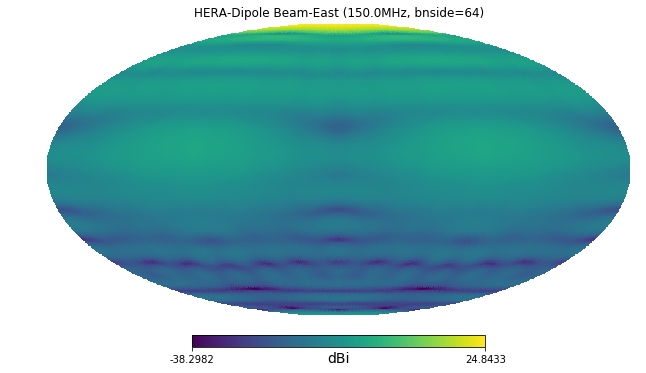

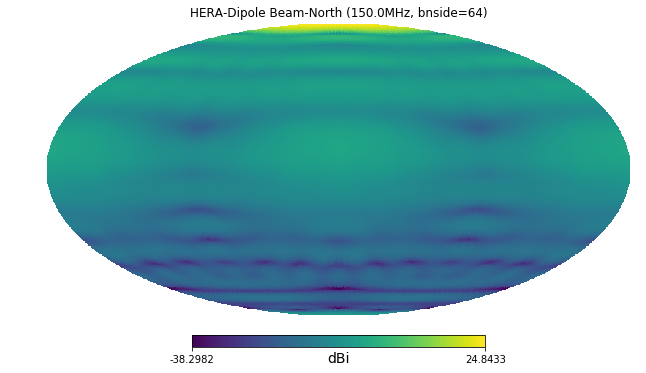

In [10]:

Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()



In [11]:
print local_beam_unpol(150)[0:]
print local_beam_unpol(150)[0:].sum()
print local_beam_unpol(150)[0:].min()
print local_beam_unpol(150)[0:].max()

[[317.35033648 317.36347034 317.36347034 ...   0.45564572   0.45564572
    0.4558748 ]
 [317.36347034 317.36347034 317.35033648 ...   0.45564572   0.4558748
    0.4558748 ]]
98426.09926039288
0.00014797059467877035
317.3634703353978


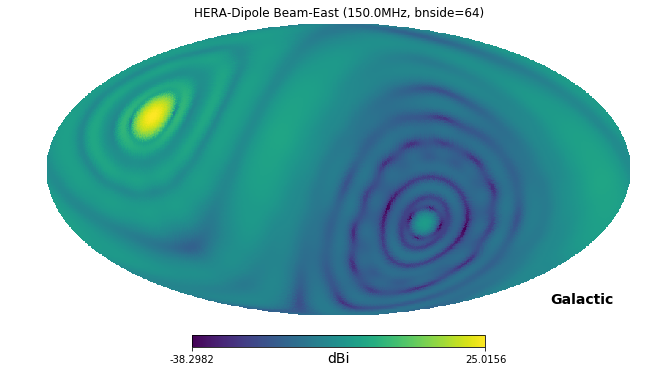

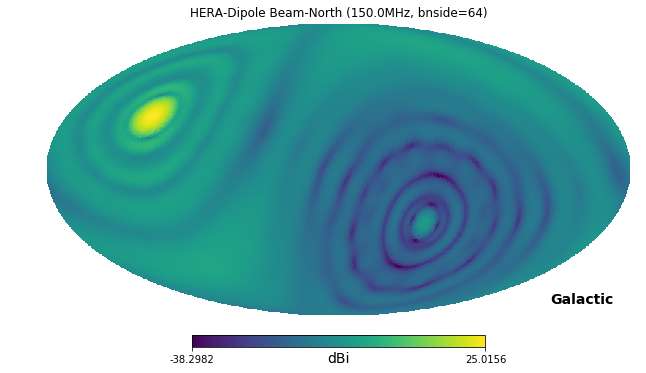

In [12]:
Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()


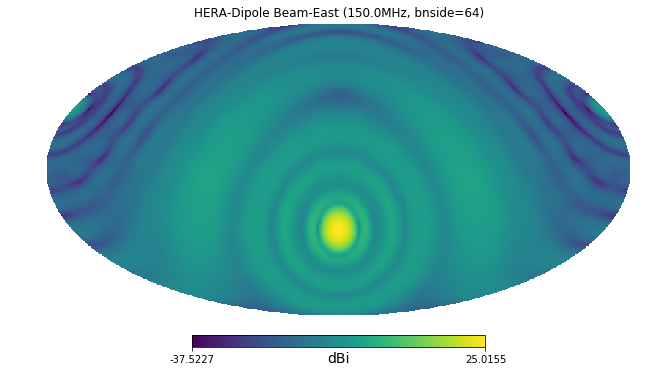

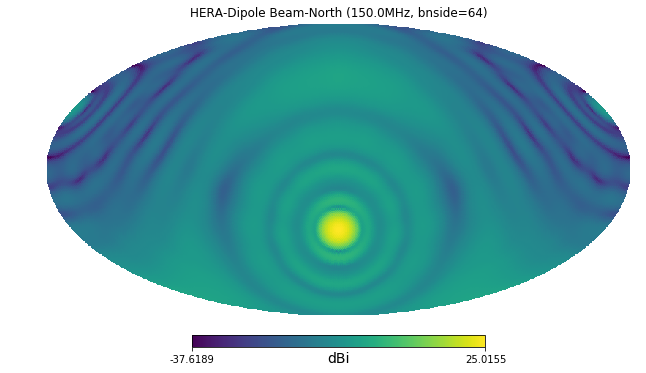

In [13]:
#################
####set up vs and beam
################
vs = sv.Visibility_Simulator()
vs.initial_zenith = np.array([0, lat_degree * PI / 180])  # self.zenithequ
beam_heal_hor_x = local_beam_unpol(freq)[0]
beam_heal_hor_y = local_beam_unpol(freq)[1]
beam_heal_equ_x = sv.rotate_healpixmap(beam_heal_hor_x, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])
beam_heal_equ_y = sv.rotate_healpixmap(beam_heal_hor_y, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])

if Absolute_Calibration_dred_mfreq or PointSource_AbsCal:
	beam_heal_hor_x_mfreq = np.array([local_beam_unpol(flist[0][i])[0] for i in range(nf_used)])
	beam_heal_hor_y_mfreq = np.array([local_beam_unpol(flist[1][i])[1] for i in range(nf_used)])
	beam_heal_equ_x_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_x_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])
	beam_heal_equ_y_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_y_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])


Plot_Beam = True
if Plot_Beam:
	plt.figure(10)
	#ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	plt.show(block=False)

sys.stdout.flush()

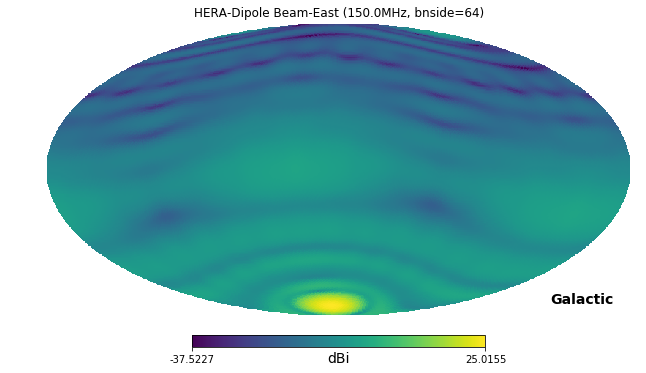

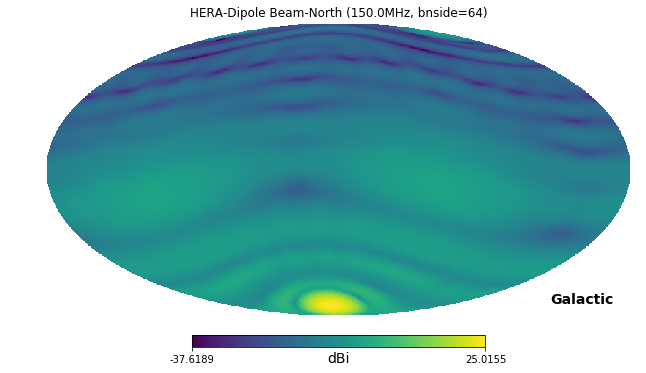

In [14]:
if Plot_Beam:
	plt.figure(0)
# 	ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	plt.show(block=False)

In [15]:
########################### Delete some Input Data ##############################
Del=True
if Del:
	#del(data)
	#del(data_yy)
	try:
		#del(model)
		#del(model_yy)
		del(data_omni)
	except:
		pass

sys.stdout.flush()

In [16]:
used_common_ubls

array([[ 2.19600784e+01, -1.25681215e+01,  1.05192742e-01],
       [ 1.47044728e+01, -2.52478190e+01,  2.49936341e-01],
       [ 9.66309485e-02, -2.53036070e+01,  2.69711772e-01],
       [-2.92156839e+01, -1.11576036e-01,  3.95508570e-02],
       [-2.18634474e+01, -1.27354855e+01,  1.64519030e-01],
       [-1.45112109e+01, -2.53593950e+01,  2.89487203e-01],
       [-1.46078419e+01, -5.57880073e-02,  1.97754296e-02],
       [-7.25560550e+00, -1.26796975e+01,  1.44743600e-01],
       [ 7.35223644e+00, -1.26239095e+01,  1.24968172e-01]])

In [17]:
######################
####initial A to compute beam weight
#####################
A_version = 1.0
A = {}
for p in ['x', 'y']:
	pol = p + p
	# ubl file
	#// ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
	#ubls = np.array([[0,0,0]])
	#//np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
	print "%i UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(ubls[p]), np.max(np.linalg.norm(ubls[p], axis=1)) / (C / freq), pol)
	print "%i Used-Common-UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(used_common_ubls), np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq), pol)

	# beam
	if p == 'x':
		beam_heal_equ = beam_heal_equ_x
	elif p == 'y':
		beam_heal_equ = beam_heal_equ_x
	print "Computing sky weighting A matrix for %s pol..." % p
	sys.stdout.flush()

	A[p] = np.zeros((nt_used * len(used_common_ubls), 12 * nside_beamweight ** 2), dtype='complex128')

	timer = time.time()
	for i in np.arange(12 * nside_beamweight ** 2):
		dec, ra = hpf.pix2ang(nside_beamweight, i)  # gives theta phi
		dec = PI / 2 - dec
		print "\r%.1f%% completed" % (100. * float(i) / (12. * nside_beamweight ** 2)),
		sys.stdout.flush()
		if abs(dec - lat_degree * PI / 180) <= PI / 2:
			A[p][:, i] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts).flatten()

	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()
	

9 UBLs to include, longest baseline is 14 wavelengths for Pol: xx
9 Used-Common-UBLs to include, longest baseline is 14 wavelengths for Pol: xx
Computing sky weighting A matrix for x pol...
66.6% completed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

66.6% completed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

100.0% completed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [18]:
####################################################
###beam weights using an equal pixel A matrix######
#################################################
print "Computing beam weight...",
sys.stdout.flush()
beam_weight = ((la.norm(A['x'], axis=0) ** 2 + la.norm(A['y'], axis=0) ** 2) ** .5)[hpf.nest2ring(nside_beamweight, range(12 * nside_beamweight ** 2))]
beam_weight = beam_weight / np.mean(beam_weight)
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
beam_weight = hpf.get_interp_val(beam_weight, thetas_standard, phis_standard, nest=True) #np.array([beam_weight for i in range(nside_standard ** 2 / nside_beamweight ** 2)]).transpose().flatten()
print "done."
sys.stdout.flush()

Computing beam weight... done.


In [19]:
################################################
#####################GSM###########################
#############################################
pca1 = hp.fitsfunc.read_map(script_dir + '/../data/gsm1.fits' + str(nside_standard))
pca2 = hp.fitsfunc.read_map(script_dir + '/../data/gsm2.fits' + str(nside_standard))
pca3 = hp.fitsfunc.read_map(script_dir + '/../data/gsm3.fits' + str(nside_standard))
components = np.loadtxt(script_dir + '/../data/components.dat')
scale_loglog = si.interp1d(np.log(components[:, 0]), np.log(components[:, 1]))
w1 = si.interp1d(components[:, 0], components[:, 2])
w2 = si.interp1d(components[:, 0], components[:, 3])
w3 = si.interp1d(components[:, 0], components[:, 4])
gsm_standard = np.exp(scale_loglog(np.log(freq))) * (w1(freq) * pca1 + w2(freq) * pca2 + w3(freq) * pca3)
if Absolute_Calibration_dred_mfreq or PointSource_AbsCal:
	gsm_standard_mfreq = np.array([np.exp(scale_loglog(np.log(flist[0][i]))) * (w1(flist[0][i]) * pca1 + w2(flist[0][i]) * pca2 + w3(flist[0][i]) * pca3) for i in range(nf_used)])

# rotate sky map and converts to nest
equatorial_GSM_standard = np.zeros(12 * nside_standard ** 2, 'float')
print "Rotating GSM_standard and converts to nest...",

if INSTRUMENT == 'miteor':
	DecimalYear = 2013.58 #2013, 7, 31, 16, 47, 59, 999998)
	JulianEpoch = 2013.58
elif INSTRUMENT == 'hera47':
	DecimalYear = Time(data_times[0][0], format='jd').decimalyear + (np.mean(Time(data_times[0], format='jd').decimalyear) - Time(data_times[0][0], format='jd').decimalyear) * Time_Expansion_Factor
	JulianEpoch = Time(data_times[0][0], format='jd').jyear + (np.mean(Time(data_times[0], format='jd').jyear) - Time(data_times[0][0], format='jd').jyear) * Time_Expansion_Factor  # np.mean(Time(data_times[0], format='jd').jyear)

sys.stdout.flush()
equ_to_gal_matrix = hp.rotator.Rotator(coord='cg').mat.dot(sv.epoch_transmatrix(2000, stdtime=JulianEpoch))
ang0, ang1 = hp.rotator.rotateDirection(equ_to_gal_matrix,
					hpf.pix2ang(nside_standard, range(12 * nside_standard ** 2), nest=True))
equatorial_GSM_standard = hpf.get_interp_val(gsm_standard, ang0, ang1)
if Absolute_Calibration_dred_mfreq or PointSource_AbsCal:
	equatorial_GSM_standard_mfreq = np.array([hpf.get_interp_val(gsm_standard_mfreq[i], ang0, ang1) for i in range(nf_used)])
print "done."

Del=True
if Del:
	del(pca1)
	del(pca2)
	del(pca3)
	del(w1)
	del(w2)
	del(w3)
	del(components)
	del(scale_loglog)
	del(gsm_standard)
	try:
		del(gsm_standard_mfreq)
	except:
		pass
sys.stdout.flush()

NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Rotating GSM_standard and converts to nest... done.


In [20]:
Time(2458044.66691, format='jd').datetime # 2458044.12551; 2458044.66691

datetime.datetime(2017, 10, 18, 4, 0, 21, 24013)

In [21]:
###########################################################
####simulate visibilities using non dynamic pixelization###
##########################################
full_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor)
sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_vis_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor)
sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_vis_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor)
if simulation_opt == 1:
	
	if os.path.isfile(full_sim_filename):
		fullsim_vis = np.fromfile(full_sim_filename, dtype='complex128').reshape((2, nUBL_used + 1, nt_used))
		fullsim_vis[0][:-1, :].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1, :].astype('complex128').tofile(sim_vis_yy_filename)
	
	else:
		
		fullsim_vis = np.zeros((2, nUBL_used + 1, nt_used), dtype='complex128')  # since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)  # tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')
		
		print "Simulating visibilities, %s, expected time %f min" % (datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis[p] += masked_equ_GSM[i] * res
		# fullsim_vis_DBG[p, ..., i] = res[:-1]
		# autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated visibilities in %f minutes." % ((time.time() - timer) / 60.)
		fullsim_vis.astype('complex128').tofile(full_sim_filename)
		fullsim_vis[0][:-1, :].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1, :].astype('complex128').tofile(sim_vis_yy_filename)
	
	autocorr_vis = np.abs(fullsim_vis[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
	else:
		autocorr_vis_normalized = np.ones((2, nt_used))
	fullsim_vis = fullsim_vis[:, :-1].transpose((1, 0, 2))


Simulating visibilities, 2018-03-20 14:01:16.172397, expected time 0.042825 min simulated visibilities in 0.193072 minutes.


In [22]:
fullsim_vis.shape

(9, 2, 60)

In [23]:
print autocorr_vis.mean()
print(np.abs(fullsim_vis[0,0]).mean())
print(np.abs(fullsim_vis[0,0]).max())
print(np.abs(fullsim_vis[0,0]).min())
print(np.abs(fullsim_vis[0,0]).sum())

2109007.4596491926
10483.961905438213
84555.55311328905
585.0206598675345
629037.7143262927


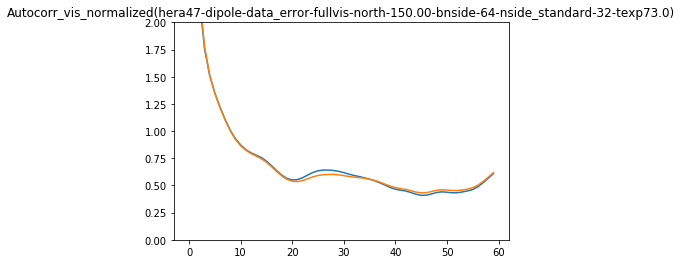

In [24]:
if plot_data_error:
	# plt.clf()
	plt.figure(30)
	plt.plot(autocorr_vis_normalized.transpose())
	plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis-north-%.2f_u%i_t%i_tave%s_fave%s-bnside-%s-nside_standard-%s-texp%s)'%(INSTRUMENT, freq, nUBL_used+1, nt_used, Time_Average, Frequency_Average, bnside, nside_standard, Time_Expansion_Factor))
	plt.ylim([0, 2])
	plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis-north-%.2f_u%i_t%i_tave%s_fave%s-bnside-%s-nside_standard-%s-texp%s)'%(INSTRUMENT, freq, nUBL_used+1, nt_used, Time_Average, Frequency_Average, bnside, nside_standard, Time_Expansion_Factor))
	plt.show(block=False)
# plt.gcf().clear()
# plt.clf()
# plt.close()
sys.stdout.flush()


In [25]:
######################################### Absolute Calibration on Omnicaled Data #############################################
if Absolute_Calibration_red:
	full_redabs_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_redabs.simvis' % (INSTRUMENT, freq, nBL_red_used + 1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor)
	redabs_sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_vis_redabs_sim_xx.simvis' % (INSTRUMENT, freq, nBL_red_used + 1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor)
	redabs_sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_vis_redabs_sim_yy.simvis' % (INSTRUMENT, freq, nBL_red_used + 1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor)
	
	if os.path.isfile(full_redabs_sim_filename):
		fullsim_vis_red = np.fromfile(full_redabs_sim_filename, dtype='complex128').reshape((2, nBL_red_used + 1, nt_used))
		fullsim_vis_red[0][:-1, :].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1, :].astype('complex128').tofile(redabs_sim_vis_yy_filename)
	
	else:
		
		fullsim_vis_red = np.zeros((2, nBL_red_used + 1, nt_used), dtype='complex128')  # since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_bls_red = np.concatenate((used_common_bls_red, [[0, 0, 0]]), axis=0)  # tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')
		
		print "Simulating redundant visibilities, %s, expected time %f min" % (datetime.datetime.now(), 14.6 * (nBL_red_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res_red = vs.calculate_pointsource_visibility(ra, dec, full_sim_bls_red, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis_red[p] += masked_equ_GSM[i] * res_red
		# fullsim_vis_DBG[p, ..., i] = res[:-1]
		# autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated redundant visibilities in %f minutes." % ((time.time() - timer) / 60.)
		fullsim_vis_red.astype('complex128').tofile(full_redabs_sim_filename)
		fullsim_vis_red[0][:-1, :].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1, :].astype('complex128').tofile(redabs_sim_vis_yy_filename)
	
	autocorr_vis_red = np.abs(fullsim_vis_red[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_red_normalized = np.array([autocorr_vis_red[p] / (la.norm(autocorr_vis_red[p]) / la.norm(np.ones_like(autocorr_vis_red[p]))) for p in range(2)])
	else:
		autocorr_vis_red_normalized = np.ones((2, nt_used))
	fullsim_vis_red = fullsim_vis_red[:, :-1].transpose((1, 0, 2))

	if plot_data_error:
		#plt.clf()
		plt.figure(3000000)
		plt.plot(autocorr_vis_red_normalized.transpose())
		plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s-texp-%s)' % (INSTRUMENT, freq, bnside, nside_standard, Time_Expansion_Factor))
		plt.ylim([0, 2])
		plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s-texp-%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, Time_Expansion_Factor))
		plt.show(block=False)
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()
	sys.stdout.flush()


In [26]:
if Absolute_Calibration_dred_mfreq or Absolute_Calibration_dred:  # Used 9.4 min. 64*9*60*12280
	full_sim_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_xx_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_vis_sim_xx_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_yy_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_vis_sim_yy_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor, np.min(flist[0]), np.max(flist[0]), len(flist[1]))
	if simulation_opt == 1:
		
		if os.path.isfile(full_sim_filename_mfreq):
			fullsim_vis_mfreq = np.fromfile(full_sim_filename_mfreq, dtype='complex128').reshape((2, nUBL_used + 1, nt_used, nf_used))
			fullsim_vis_mfreq[0][:-1].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
		
		else:
			
			fullsim_vis_mfreq = np.zeros((2, nUBL_used + 1, nt_used, nf_used), dtype='complex128')  # since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
			if not Absolute_Calibration_dred_mfreq:
				for id_p in range(2):
					fullsim_vis_mfreq[id_p, :-1, :, index_freq[id_p]] = fullsim_vis[:, id_p, :]
					fullsim_vis_mfreq[id_p, -1, :, index_freq[id_p]] = autocorr_vis[id_p]
			else:
				full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)  # tag along auto corr
				full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
				full_decs = PI / 2 - full_thetas
				full_ras = full_phis
				full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
				# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')
				
				print "Simulating visibilities, %s, expected time %f min" % (datetime.datetime.now(), 14.6 * nf_used * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
				sys.stdout.flush()
				masked_equ_GSM_mfreq = equatorial_GSM_standard_mfreq[:, full_sim_mask]
				timer = time.time()
				for id_f, f in enumerate(flist[0]):
					for p, beam_heal_equ in enumerate([beam_heal_equ_x_mfreq[id_f], beam_heal_equ_y_mfreq[id_f]]):
						for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
							res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, f, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
							fullsim_vis_mfreq[p, :, :, id_f] += masked_equ_GSM_mfreq[id_f, i] * res
					# fullsim_vis_DBG[p, ..., i] = res[:-1]
					# autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
				print "simulated visibilities in %f minutes." % ((time.time() - timer) / 60.)
				fullsim_vis_mfreq.astype('complex128').tofile(full_sim_filename_mfreq)
				fullsim_vis_mfreq[0][:-1, :, :].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
				fullsim_vis_mfreq[1][:-1, :, :].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
		
		autocorr_vis_mfreq = np.abs(fullsim_vis_mfreq[:, -1])
		#		if crosstalk_type == 'autocorr':
		#			autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
		#		else:
		#			autocorr_vis_normalized = np.ones((2, nt_used))
		fullsim_vis_mfreq = fullsim_vis_mfreq[:, :-1].transpose((1, 0, 2, 3))  # (uBL, Pol, Times, Freqs)

In [27]:
if INSTRUMENT == 'hera47' and (Absolute_Calibration_dred_mfreq or Absolute_Calibration_red or Absolute_Calibration_dred or PointSource_AbsCal or Absolute_Calibration_dred_mfreq_pscal):
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	data_dred_mfreq_pscal = {}
	interp_flags_dred_mfreq = {}
	interp_flags_dred_mfreq_pscal = {}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	AC_dred_mfreq_pscal = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}
	auto_select_dred_mfreq_pscal = {}
	
	#	try:
	#		cdata = copy.deepcopy(data)
	#	except:
	#		pass
	
	try:
		cdflags_sf = copy.deepcopy(dflags_sf)
	except:
		pass
	
	try:
		cdflags_dred = copy.deepcopy(dflags_dred)
	except:
		pass
	
	try:
		cdflags = copy.deepcopy(dflags)
	except:
		pass
	
	try:
		cdflags_dred_mfreq = copy.deepcopy(dflags_dred_mfreq)
	except:
		pass
	
	# cwgts = copy.deepcopy(wgts)
	# cwgts_dred = copy.deepcopy(wgts_dred)
	
	
	bl_select = 0
	bl = dflags.keys()[bl_select]  # dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}
	
	bl_dred_select = 0
	bl_dred = dflags_dred[0].keys()[bl_dred_select]  # if Absolute_Calibration_dred else None #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}
	
	bl_dred_mfreq_select = 8
	bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  # [(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {}
	axes3_data_abscorr = {}
	
	bl_dred_mfreq_pscal_select = 8
	bl_dred_mfreq_pscal = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_pscal_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_pscal_select]]  # [(25, 37, 'xx'), (25, 37, 'yy')]
	fig4 = {}
	axes4 = {}
	fig4_data = {}
	axes4_data = {}
	fig4_data_abscorr = {}
	axes4_data_abscorr = {}
    
	bl_dred_mfreq_pscal_modcal_select = 8
	bl_dred_mfreq_pscal_modcal = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_pscal_modcal_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_pscal_modcal_select]]  # [(25, 37, 'xx'), (25, 37, 'yy')]
	fig5 = {}
	axes5 = {}
	fig5_data = {}
	axes5_data = {}
	fig5_data_abscorr = {}
	axes5_data_abscorr = {}
	
	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	delay_corr_data_dred_mfreq_pscal = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	DAC_dred_mfreq_pscal = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	dly_phs_corr_data_dred_mfreq_pscal = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	DPAC_dred_mfreq_pscal = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}
	abs_corr_data_dred_mfreq_pscal = {}
	
	vis_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_mfreq_pscal_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_pscal_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	vis_data_dred_pscal_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]
	autocorr_data_dred_pscal_abscal = [[], []]
	
	add_Autobsl = False  # Whether we add (0,0,0) to calculate autocorr or not.
	
	#		model = (copy.deepcopy(data)).astype('complex128')
	#		model_yy = copy.deepcopy(data_yy).astype('complex128')
	for i in range(2):
		model_sf[i] = LastUpdatedOrderedDict()
		model_sf[i] = LastUpdatedOrderedDict()
		model_dred[i] = LastUpdatedOrderedDict()
		#model_dred_mfreq[i] = LastUpdatedOrderedDict()
		# data[i] = LastUpdatedOrderedDict()
		data_sf[i] = LastUpdatedOrderedDict()
		data_dred[i] = LastUpdatedOrderedDict()
		#data_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		# fulldflags[i] = hc.abscal.UVData2AbsCalDict(data_fname_full[i], return_meta=True)[1] # assume autocorr no RFI flagged.
		
		if Absolute_Calibration_red:
			keys = dflags_sf[i].keys()  # if i == 0 else dflags_yy.keys()
			for key_index, key in enumerate(keys):
				model_sf[i][key] = fullsim_vis_red[key_index, i, :]
				data_sf[i][key] = vis_data[i][:, key_index]
			model_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_red[i]  # not lose generality, choose the autocorrelation of first antenna in the first UBL as visibility in last line for autocorrelation calibraiton.
			data_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data[i]
			cdflags_sf[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([False] * len(autocorr_data[i]))
			print(keys)
			print(keys[0][0])
		
		if Absolute_Calibration_dred:
			for key_index_dred, key_dred in enumerate(dflags_dred[i].keys()):
				model_dred[i][key_dred] = fullsim_vis[key_index_dred, i, :]
				data_dred[i][key_dred] = vis_data_dred[i][:, key_index_dred]
			model_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis[i]  # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
			data_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_data[i]  # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
			cdflags_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = np.array([False] * len(autocorr_data[i]))
			print(dflags_dred[i].keys())
			print(dflags_dred[i].keys()[0][0])
		
		#		if Absolute_Calibration_dred_mfreq:
		#			keys = dflags_dred_mfreq[i].keys()
		#			for key_index, key in enumerate(keys):
		#				model[i][key] = fullsim_vis_mfreq[key_index_dred, i]
		#				#data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
		#			model[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
		#			cdata[i][dflags[i].keys()[0][0], dflags[i].keys()[0][0], dflags[i].keys()[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
		#			cdflags[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
		#			print(dflags[i].keys())
		#			print(dflags[i].keys()[0][0])
		#
		
		# if Absolute_Calibration_dred_mfreq:
		# 	keys = dflags_dred_mfreq[i].keys()
		# 	for key_index, key in enumerate(keys):
		# 		model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
		# 		# data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
		# 		data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose()  # [pol][freq,time,ubl_index].transpose()
		# 	if add_Autobsl:
		# 		model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i]  # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
		# 		data_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i]  # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
		# 		cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False] * autocorr_data_mfreq[i].shape[1]] * autocorr_data_mfreq[i].shape[0])
		# 		auto_select_dred_mfreq[i] = (keys[0][0], keys[0][0], keys[0][2])
		# 	print(dflags_dred_mfreq[i].keys())
		# 	print(dflags_dred_mfreq[i].keys()[0][0])
	# Fake_wgts_dred_mfreq = True
	###### make wgts #######
	for i in range(2):
		if i == 0:
			wgts_sf = copy.deepcopy(cdflags_sf)
		for k in wgts_sf[i].keys():
			wgts_sf[i][k] = (~wgts_sf[i][k]).astype(np.float)
		
		if i == 0:
			wgts_dred = copy.deepcopy(cdflags_dred)
		for k in wgts_dred[i].keys():
			wgts_dred[i][k] = (~wgts_dred[i][k]).astype(np.float)
		
		#		if i == 0:
		#			wgts = copy.deepcopy(cdflags)
		#		for k in wgts[i].keys():
		#			wgts[i][k] = (~wgts[i][k]).astype(np.float)
		
		# if i == 0:
		# 	wgts_dred_mfreq = copy.deepcopy(cdflags_dred_mfreq)
		# for k in wgts_dred_mfreq[i].keys():
		# 	if not Fake_wgts_dred_mfreq:
		# 		wgts_dred_mfreq[i][k] = (~wgts_dred_mfreq[i][k]).astype(np.float)
		# 	else:
		# 		wgts_dred_mfreq[i][k] = (((~wgts_dred_mfreq[i][k]).astype(np.float) + 1).astype(bool)).astype(np.float)
	


In [28]:
if Absolute_Calibration_dred_mfreq or Absolute_Calibration_dred:
	re_cal_times = 1
	
	# Mocal_time_bin_temp = 5
	mocal_time_bin = np.min([Mocal_time_bin_temp, nt_used])
	mocal_time_bin_num = nt_used / mocal_time_bin if np.mod(nt_used, mocal_time_bin) == 0 else (nt_used / mocal_time_bin + 1)
	print('Mocal_time_bin_temp: %s; mocal_time_bin: %s; mocal_time_bin_num: %s' % (Mocal_time_bin_temp, mocal_time_bin, mocal_time_bin_num))
	
	Mocal_freq_bin_temp = 64
	mocal_freq_bin = 1 if not Absolute_Calibration_dred_mfreq else np.min([Mocal_freq_bin_temp, len(flist[0])])
	mocal_freq_bin_num = len(flist[0]) / mocal_freq_bin if np.mod(len(flist[0]), mocal_freq_bin) == 0 else (len(flist[0]) / mocal_freq_bin + 1)
	print('Mocal_freq_bin_temp: %s; mocal_freq_bin: %s; mocal_freq_bin_num: %s' % (Mocal_freq_bin_temp, mocal_freq_bin, mocal_freq_bin_num))
	
	wgts_dred_mfreq  ={}
	for i in range(2):
		pol = ['xx', 'yy'][i]
		re_cal = 0
		model_dred_mfreq[i] = LastUpdatedOrderedDict()
		data_dred_mfreq[i] = LastUpdatedOrderedDict()
		
		vis_data_dred_mfreq_abscal[i] = np.zeros_like(vis_data_dred_mfreq[i], dtype='complex128')
		autocorr_data_dred_mfreq_abscal[i] = np.zeros_like(autocorr_vis_mfreq[i])
		vis_data_dred_abscal[i] = np.zeros_like(vis_data_dred_mfreq_abscal[i][index_freq[i], :, :])
		autocorr_data_dred_abscal[i] = np.zeros_like(autocorr_vis_mfreq[i][:, index_freq[i]])
		
		for id_t_bin in range(mocal_time_bin_num):
			nt_mocal_used = mocal_time_bin if (id_t_bin + 1) * mocal_time_bin <= nt_used else (nt_used - id_t_bin * mocal_time_bin)
			
			for id_f_bin in range(mocal_freq_bin_num):
				nf_mocal_used = mocal_freq_bin if (id_f_bin + 1) * mocal_freq_bin <= len(flist[0]) else (len(flist[0]) - id_f_bin * mocal_freq_bin)
				
				keys = dflags_dred_mfreq[i].keys()
				for key_index, key in enumerate(keys):
					model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i, id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used]
					# data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
					data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used, id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, key_index].transpose()  # [pol][freq,time,ubl_index].transpose()
					cdflags_dred_mfreq[i][key] = dflags_dred_mfreq[i][key][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used]
				if add_Autobsl:
					model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used]  # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
					data_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used]  # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
					cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False] * autocorr_data_mfreq[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used].shape[1]] * autocorr_data_mfreq[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used].shape[0])
					auto_select_dred_mfreq[i] = (keys[0][0], keys[0][0], keys[0][2])
				print(dflags_dred_mfreq[i].keys())
				print(dflags_dred_mfreq[i].keys()[0][0])
				print('(id_t_bin: %s, id_f_bin: %s) data_shape[%s][%s]: (%s) \n' % (id_t_bin, id_f_bin, ['xx', 'yy'][i], key, data_dred_mfreq[i][key].shape))
						
				wgts_dred_mfreq[i] = copy.deepcopy(cdflags_dred_mfreq[i])
				for k in wgts_dred_mfreq[i].keys():
					if not Fake_wgts_dred_mfreq:
						wgts_dred_mfreq[i][k] = (~wgts_dred_mfreq[i][k]).astype(np.float)
					else:
						wgts_dred_mfreq[i][k] = (((~wgts_dred_mfreq[i][k]).astype(np.float) + 1).astype(bool)).astype(np.float)
				
				lsts_binned = lsts[id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used]
				flist_binned = flist[i][id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used]
				
				for re_cal in range(re_cal_times):  # number of times of absolute calibration
					if re_cal == 0:												
						if not Absolute_Calibration_dred_mfreq:
							# Skip Delay_Lincal
							# instantiate class
							DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
						else:
							# instantiate class
							model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts_binned, flist_binned, lsts_binned, flist_binned)
							AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
							# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
							AC_dred_mfreq[i].delay_lincal(kernel=(1, ((np.min([nf_mocal_used, 11]) -1) / 2 * 2 + 1)), medfilt=True, time_avg=True, solve_offsets=True)
							# apply to data
							delay_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(AC_dred_mfreq[i].data, (AC_dred_mfreq[i].ant_dly_gain))
							# instantiate class
							DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
					else:
						if not Absolute_Calibration_dred_mfreq:
							# delay_corr_data_dred_mfreq[i] = abs_corr_data_dred_mfreq[i]
							DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
						else:
							# instantiate class
							AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
							AC_dred_mfreq[i].delay_lincal(kernel=(1, ((np.min([nf_mocal_used, 3]) -1) / 2 * 2 + 1)), medfilt=True, time_avg=True, solve_offsets=True)
							# apply to data
							delay_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(AC_dred_mfreq[i].data, (AC_dred_mfreq[i].ant_dly_gain))
							# instantiate class
							DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)

					# # instantiate class
					# DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
					# avg phase solver
					DAC_dred_mfreq[i].phs_logcal(avg=True)
					# apply to data
					dly_phs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DAC_dred_mfreq[i].data, (DAC_dred_mfreq[i].ant_phi_gain))
					# instantiate class
					DPAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
					# run amp linsolve
					DPAC_dred_mfreq[i].abs_amp_logcal()
					# run phs linsolve
					DPAC_dred_mfreq[i].TT_phs_logcal(zero_psi=False, four_pol=False)
					# apply to data
					abs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DPAC_dred_mfreq[i].data,
					                                                    (DPAC_dred_mfreq[i].abs_psi_gain, DPAC_dred_mfreq[i].TT_Phi_gain, DPAC_dred_mfreq[i].abs_eta_gain), gain_convention='multiply')

				
				for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
					vis_data_dred_mfreq_abscal[i][id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used, id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, key_id] = abs_corr_data_dred_mfreq[i][key].transpose()
				# vis_data_dred_mfreq_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq[i][key].transpose()))*1j
				if add_Autobsl:
					autocorr_data_dred_mfreq_abscal[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used] = abs_corr_data_dred_mfreq[i][auto_select_dred_mfreq[i]]
				else:
					autocorr_data_dred_mfreq_abscal[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used] = autocorr_vis_mfreq[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used]
				
		vis_data_dred_abscal[i] = vis_data_dred_mfreq_abscal[i][index_freq[i], :, :]
		if add_Autobsl:
			autocorr_data_dred_abscal[i] = autocorr_data_dred_mfreq_abscal[i][:, index_freq[i]]
		else:
			autocorr_data_dred_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
	
            

In [29]:
if Absolute_Calibration_dred_mfreq or Absolute_Calibration_dred:
	for i in range(2): # add another redundant 'for loop' for testing plotting.
		pol = ['xx', 'yy'][i]
		try:		
			# plt.figure(80000000 + 10 * i)
			# fig3[i], axes3[i] = plt.subplots(2, 1, figsize=(12, 8))
			# plt.sca(axes3[i][0])
			# uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
			# plt.colorbar()
			# plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq[i]))
			# plt.sca(axes3[i][1])
			# uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			# plt.colorbar()
			# plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq[i]))
			# plt.show(block=False)
			# plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_model-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# # plt.cla()
			
			plt.figure(80000000 + 10 * i)
			fig3[i], axes3[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes3[i][0])
			uvt.plot.waterfall(fullsim_vis_mfreq[bl_dred_mfreq_select, i, :, :], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq[i]))
			plt.sca(axes3[i][1])
			uvt.plot.waterfall(fullsim_vis_mfreq[bl_dred_mfreq_select, i, :, :], mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq[i]))
			plt.show(block=False)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_model-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# plt.cla()
			
			# plt.figure(90000000 + 10 * i)
			# fig3_data[i], axes3_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			# plt.sca(axes3_data[i][0])
			# uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=1.5, drng=5)
			# plt.colorbar()
			# plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq[i]))
			# plt.sca(axes3_data[i][1])
			# uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			# plt.colorbar()
			# plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq[i]))
			# plt.show(block=False)
			# plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_data-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# # plt.cla()
		
			plt.figure(90000000 + 10 * i)
			fig3_data[i], axes3_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes3_data[i][0])
			uvt.plot.waterfall(vis_data_dred_mfreq[i][:, :, bl_dred_mfreq_select].transpose(), mode='log', mx=1.5, drng=5)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq[i]))
			plt.sca(axes3_data[i][1])
			uvt.plot.waterfall(vis_data_dred_mfreq[i][:, :, bl_dred_mfreq_select].transpose(), mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq[i]))
			plt.show(block=False)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_data-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# plt.cla()
			
			####################### after ABS Calibration #########################
			# plt.figure(8000000 + 10 * i)
			# fig3_data_abscorr[i], axes3_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			# plt.sca(axes3_data_abscorr[i][0])
			# uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
			# plt.colorbar()
			# plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq[i]))
			# plt.sca(axes3_data_abscorr[i][1])
			# uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			# plt.colorbar()
			# plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq[i]))
			# plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_data-caled-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# plt.show(block=False)
			# # plt.cla()
			
			plt.figure(8000000 + 10 * i)
			fig3_data_abscorr[i], axes3_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes3_data_abscorr[i][0])
			uvt.plot.waterfall(vis_data_dred_mfreq_abscal[i][:, :, bl_dred_mfreq_select].transpose(), mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq[i]))
			plt.sca(axes3_data_abscorr[i][1])
			uvt.plot.waterfall(vis_data_dred_mfreq_abscal[i][:, :, bl_dred_mfreq_select].transpose(), mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq[i]))
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_data-caled-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			plt.show(block=False)
			# plt.cla()
		except:
			print('Error when Plotting Mocal Results')

In [30]:
for i in range(2):	
	if Absolute_Calibration_dred:
		# instantiate class
		#AC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
		AC_dred[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
		# apply to data
		delay_corr_data_dred[i] = hc.abscal.apply_gains(AC_dred[i].data, (AC_dred[i].ant_dly_gain))
		# instantiate class
		DAC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# avg phase solver
		DAC_dred[i].phs_logcal(avg=True)
		# apply to data
		dly_phs_corr_data_dred[i] = hc.abscal.apply_gains(DAC_dred[i].data, (DAC_dred[i].ant_phi_gain))
		# instantiate class
		DPAC_dred[i] = hc.abscal.AbsCal(model_dred[i], dly_phs_corr_data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# run amp linsolve
		DPAC_dred[i].abs_amp_logcal()
		# run phs linsolve
		DPAC_dred[i].TT_phs_logcal(zero_psi=False, four_pol=False)
		# apply to data
		abs_corr_data_dred[i] = hc.abscal.apply_gains(DPAC_dred[i].data, 
								(DPAC_dred[i].abs_psi_gain, DPAC_dred[i].TT_Phi_gain, DPAC_dred[i].abs_eta_gain), gain_convention='multiply')
		
		
		plt.figure(60000000+10*i)
		fig2[i], axes2[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2[i][0])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred))
			plt.show(block=False)			
		else:
			plt.sca(axes2[i][0])
			plt.plot(np.real(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Real {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			plt.plot(np.imag(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
		plt.figure(70000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
			
		####################### after ABS Calibration #########################	
		plt.figure(7000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()


In [31]:
4 != 5

True

In [32]:
################################################################
################# Noise and Vis Data Loading ##################
###############################################################
Recal_IntegrationTime = True
Recal_FrequencyBin = True
if len(tlist) >= 2 and INSTRUMENT == 'hera47' and Recal_IntegrationTime:
	Time_seperation_real = np.array([3600. * np.abs(tlist[i + 1] - tlist[i]) for i in range(len(tlist) - 1)])  # in second
elif INSTRUMENT == 'hera47':
	Time_seperation_real = 11 # second
elif INSTRUMENT == 'miteor':
	Time_seperation_real = 2.7 # second
	
if len(flist) >=2 and INSTRUMENT == 'hera47' and Recal_FrequencyBin:
	Frequency_gap_real = np.array([1.e6*np.abs(flist[0][i+1]-flist[0][i]) for i in range(len(flist[0])-1)]) # Hz
elif INSTRUMENT == 'hera47':
	Frequency_gap_real = 0.09765625 * 1.e6 #Hz
elif INSTRUMENT == 'miteor':
	Frequency_gap_real = 0.5 * 1.e6 #Hz

Integration_Time = np.mean(Time_seperation_real)
Frequency_Bin = np.mean(Frequency_gap_real)

Calculate_SimulationData_Noise = True
Calculate_Data_Noise = True

scale_noise = True
# Use_AbsCal = False

noise = {}
noise_data = {}
if Calculate_SimulationData_Noise:
	if Keep_Red:
		noise['x'] = np.array([np.random.normal(0, autocorr_vis_red[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) for t_index in range(len(autocorr_vis[0]))], dtype='complex128').flatten()
		noise['y'] = np.array([np.random.normal(0, autocorr_vis_red[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) for t_index in range(len(autocorr_vis[1]))], dtype='complex128').flatten()
	else:
		noise['x'] = np.array([(np.random.normal(0, autocorr_vis[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) / np.array(used_redundancy[0]) ** 0.5) for t_index in range(len(autocorr_vis[0]))], dtype='complex128').flatten()
		noise['y'] = np.array([(np.random.normal(0, autocorr_vis[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) / np.array(used_redundancy[1]) ** 0.5) for t_index in range(len(autocorr_vis[1]))], dtype='complex128').flatten()
	
	#	N_acu = {}
	#	N_acu['x'] = np.outer(noise['x'], noise['x'].T)
	#	N_acu['y'] = np.outer(noise['y'], noise['y'].T)
	N = {}
	N['x'] = noise['x'] * noise['x']
	N['y'] = noise['y'] * noise['y']
	
	sim_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_xx.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
	sim_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_yy.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
	if not os.path.isfile(sim_var_xx_filename):
		N['x'].astype('complex128').tofile(sim_var_xx_filename)
	if not os.path.isfile(sim_var_yy_filename):
		N['y'].astype('complex128').tofile(sim_var_yy_filename)
	
	Del = True
	if Del:
		del (noise)
		del (N)

if Calculate_Data_Noise:
	if INSTRUMENT == 'miteor':
		noise_data['x'] = (var_data[0].flatten()) ** 0.5
		noise_data['y'] = (var_data[1].flatten()) ** 0.5
	
	elif INSTRUMENT == 'hera47':
		if Keep_Red:
			noise_data['x'] = np.array([np.random.normal(0, autocorr_data[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) for t_index in range(len(autocorr_data[0]))], dtype='complex128').flatten()  # Not Absolute Calibrated
			noise_data['y'] = np.array([np.random.normal(0, autocorr_data[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) for t_index in range(len(autocorr_data[1]))], dtype='complex128').flatten()
		else:
			if scale_noise:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) / np.array(used_redundancy[0]) ** 0.5) for t_index in range(len(autocorr_data_dred_abscal[0]))], dtype='complex128').flatten()  # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) / np.array(used_redundancy[1]) ** 0.5) for t_index in range(len(autocorr_data_dred_abscal[1]))], dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) / np.array(used_redundancy[0]) ** 0.5) for t_index in range(len(autocorr_data[0]))], dtype='complex128').flatten()  # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) / np.array(used_redundancy[1]) ** 0.5) for t_index in range(len(autocorr_data[1]))], dtype='complex128').flatten()
			else:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used)) for t_index in range(len(autocorr_data_dred_abscal[0]))], dtype='complex128').flatten()  # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used)) for t_index in range(len(autocorr_data_dred_abscal[1]))], dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used)) for t_index in range(len(autocorr_data[0]))], dtype='complex128').flatten()  # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used)) for t_index in range(len(autocorr_data[1]))], dtype='complex128').flatten()
	
	#	N_data_acu = {}
	#	N_data_acu['x'] = np.outer(noise_data['x'], noise_data['x'].T)
	#	N_data_acu['y'] = np.outer(noise_data['y'], noise_data['y'].T)
	N_data = {}
	N_data['x'] = noise_data['x'] * noise_data['x']
	N_data['y'] = noise_data['y'] * noise_data['y']
	
	Store_Data_Noise = True
	
	if Store_Data_Noise:
		data_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
		data_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
		if not os.path.isfile(data_var_xx_filename):
			N_data['x'].astype('complex128').tofile(data_var_xx_filename)
		else:
			pass
		if not os.path.isfile(data_var_yy_filename):
			N_data['y'].astype('complex128').tofile(data_var_yy_filename)
		else:
			pass
	
	Del = True
	if Del:
		del (noise_data)
# del(N_data)
#		try:
#			del(autocorr_data)
#		except:
#			pass

sys.stdout.flush()


In [33]:
southern_points = {'hyd':{'ra': '09:18:05.7', 'dec': '-12:05:44'},
'cen':{'ra': '13:25:27.6', 'dec': '-43:01:09'},
'cyg':{'ra': '19:59:28.3', 'dec': '40:44:02'},
'pic':{'ra': '05:19:49.7', 'dec': '-45:46:44'},
'vir':{'ra': '12:30:49.4', 'dec': '12:23:28'},
'for':{'ra': '03:22:41.7', 'dec': '-37:12:30'},
'sag':{'ra': '17:45:40.045', 'dec': '-29:0:27.9'},
'cas':{'ra': '23:23:26', 'dec': '58:48:00'},
'crab':{'ra': '5:34:31.97', 'dec': '22:00:52.1'}}
southern_points.keys()
for source in southern_points.keys():
	southern_points[source]['body'] = ephem.FixedBody()
	southern_points[source]['body']._ra = southern_points[source]['ra']
	southern_points[source]['body']._dec = southern_points[source]['dec']

full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)

In [34]:
flux_raw_gsm_ps = {}
flux_gsm_ps = {}
flux_raw_dis_gsm_ps = {}
flux_dis_gsm_ps = {}
pix_index_gsm_ps = {}
pix_raw_index_gsm_ps = {}
pix_max_index_gsm_ps = {}
pt_sources = southern_points.keys()
for source in pt_sources:
    flux_raw_gsm_ps[source] = 0
    flux_gsm_ps[source] = 0
    flux_raw_dis_gsm_ps[source] = []
    flux_dis_gsm_ps[source] = []
    pix_raw_index_gsm_ps[source] = []
    pix_index_gsm_ps[source] = []
    #pix_max_index_gsm_ps[source] = []
    for i in range(len(equatorial_GSM_standard)):
        if la.norm(np.array([full_phis[i] - southern_points[source]['body']._ra, 
                               (PI / 2 - full_thetas[i]) - southern_points[source]['body']._dec])) <= 0.1:
            flux_raw_gsm_ps[source] += equatorial_GSM_standard[i]
            flux_raw_dis_gsm_ps[source].append(equatorial_GSM_standard[i])
            pix_raw_index_gsm_ps[source].append(i)
            
    pix_max_index_gsm_ps[source] = pix_raw_index_gsm_ps[source][flux_raw_dis_gsm_ps[source].index(np.array(flux_raw_dis_gsm_ps[source]).max())]
    for j in range(len(flux_raw_dis_gsm_ps[source])):
        if flux_raw_dis_gsm_ps[source][j] >= 0.4 * equatorial_GSM_standard[pix_max_index_gsm_ps[source]]:
            flux_gsm_ps[source] += equatorial_GSM_standard[pix_raw_index_gsm_ps[source][j]]
            flux_dis_gsm_ps[source].append(equatorial_GSM_standard[pix_raw_index_gsm_ps[source][j]])
            pix_index_gsm_ps[source].append(pix_raw_index_gsm_ps[source][j])
            
    print('total flux of %s'%source, flux_gsm_ps[source])
    print('total raw flux of %s'%source, flux_raw_gsm_ps[source])
    print('maximum pix flux of %s'%source, equatorial_GSM_standard[pix_max_index_gsm_ps[source]])
    print('pix-index with maximum flux of %s'%source, pix_max_index_gsm_ps[source])
    print('raw-pix-indexes of %s'%source, pix_raw_index_gsm_ps[source])
    print('pix-indexes of %s'%source, pix_index_gsm_ps[source])
    print('\n')
    

('total flux of vir', 2153.28166837201)
('total raw flux of vir', 8096.682432580265)
('maximum pix flux of vir', 750.3958455162172)
('pix-index with maximum flux of vir', 6941)
('raw-pix-indexes of vir', [6590, 6591, 6634, 6929, 6931, 6932, 6933, 6934, 6935, 6937, 6939, 6940, 6941, 6942, 6943, 6964, 6965, 6976, 6977, 6978, 6979, 6982, 6984, 6985, 6986, 6987, 6988, 6990, 7008, 7009])
('pix-indexes of vir', [6935, 6941, 6978, 6984])


('total flux of cas', 14498.815319288555)
('total raw flux of cas', 24261.39154311269)
('maximum pix flux of cas', 5537.37475086657)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 3545, 3547, 3548, 3550, 3568, 3569, 3570, 3571, 3572, 3574, 3577, 3579, 3580, 3582])
('pix-indexes of cas', [3569, 3571, 3572, 3574])


('total flux of hyd', 4934.230528060499)
('total raw flux of hyd', 4934.230528060499)
('maximum pix flux of hyd', 238.47208548449998)
('pix-index with maximum flux of hyd', 10194)
('raw-pix-indexes of hyd', [10093, 

In [35]:
######################
####simulate cas and cyg
#######################
southern_points = {'hyd':{'ra': '09:18:05.7', 'dec': '-12:05:44'},
'cen':{'ra': '13:25:27.6', 'dec': '-43:01:09'},
'cyg':{'ra': '19:59:28.3', 'dec': '40:44:02'},
'pic':{'ra': '05:19:49.7', 'dec': '-45:46:44'},
'vir':{'ra': '12:30:49.4', 'dec': '12:23:28'},
'for':{'ra': '03:22:41.7', 'dec': '-37:12:30'},
'sag':{'ra': '17:45:40.045', 'dec': '-29:0:27.9'},
'cas':{'ra': '23:23:26', 'dec': '58:48:00'},
'crab':{'ra': '5:34:31.97', 'dec': '22:00:52.1'}}


for source in southern_points.keys():
	southern_points[source]['body'] = ephem.FixedBody()
	southern_points[source]['body']._ra = southern_points[source]['ra']
	southern_points[source]['body']._dec = southern_points[source]['dec']

flux_func = {}
#flux_func['cas'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,2])
#flux_func['cyg'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,2])
flux_func['cas'] = si.interp1d(flist[0], np.array([S_casa_v_t(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))
flux_func['cyg'] = si.interp1d(flist[0], np.array([S_cyga_v(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))

full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)

# pt_sources = ['cyg', 'cas']
pt_sources = southern_points.keys()
pt_vis = np.zeros((len(pt_sources), 2, nUBL_used, nt_used), dtype='complex128')
if INSTRUMENT == 'miteor':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
# 			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
			pt_vis[i, p] = flux_gsm_ps[source] * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
elif INSTRUMENT == 'hera47':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
# 			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
			pt_vis[i, p] = flux_gsm_ps[source] * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2

if PointSource_AbsCal:
	vis_freq = {}
	
	autocorr_data_dred_mfreq_pscal = {}
	vis_data_dred_mfreq_pscal = {}
	
	# PointSource_AbsCal_SingleFreq = True
	
	if PointSource_AbsCal_SingleFreq:
		pscal_freqstart = index_freq
		pscal_freqend = index_freq + 1
	else:
		pscal_freqstart = 0
		pscal_freqend = np.min([len(flist[0]), len(flist[1])])
		
	for j, p in enumerate(['x', 'y']):
		pol = p + p
		vis_data_dred_mfreq_pscal[j] = np.zeros_like(vis_data_dred_mfreq[j])
		autocorr_data_dred_mfreq_pscal[j] = np.zeros_like(autocorr_data_mfreq[j])
	
	for id_f in range(pscal_freqstart, pscal_freqend, 1):
		vis_freq[0] = flist[0][id_f]
		vis_freq[1] = flist[1][id_f]
		# cal_lst_range = np.array([5, 6]) / TPI * 24.
		cal_lst_range = np.array([tlist[15], tlist[-15]])
		calibrate_ubl_length = 2600 / np.mean([vis_freq[0], vis_freq[1]])  # 10.67
		# cal_time_mask = tmask	 #(tlist>cal_lst_range[0]) & (tlist<cal_lst_range[1])#a True/False mask on all good data to get good data in cal time range
		cal_time_mask = (tlist > cal_lst_range[0]) & (tlist < cal_lst_range[1])
		# cal_ubl_mask = np.linalg.norm(ubls[p], axis=1) >= calibrate_ubl_length
		
		print('%i times used' % len(lsts[cal_time_mask]))
		
		flux_raw_gsm_ps = {}
		flux_gsm_ps = {}
		flux_raw_dis_gsm_ps = {}
		flux_dis_gsm_ps = {}
		pix_index_gsm_ps = {}
		pix_raw_index_gsm_ps = {}
		pix_max_index_gsm_ps = {}
		pt_sources = southern_points.keys()
		for source in pt_sources:
			flux_raw_gsm_ps[source] = 0
			flux_gsm_ps[source] = 0
			flux_raw_dis_gsm_ps[source] = []
			flux_dis_gsm_ps[source] = []
			pix_raw_index_gsm_ps[source] = []
			pix_index_gsm_ps[source] = []
			#pix_max_index_gsm_ps[source] = []
			for i in range(len(equatorial_GSM_standard_mfreq[id_f])):
				if la.norm(np.array([full_phis[i] - southern_points[source]['body']._ra,
									 (PI / 2 - full_thetas[i]) - southern_points[source]['body']._dec])) <= 0.1:
					flux_raw_gsm_ps[source] += equatorial_GSM_standard_mfreq[id_f, i]
					flux_raw_dis_gsm_ps[source].append(equatorial_GSM_standard_mfreq[id_f, i])
					pix_raw_index_gsm_ps[source].append(i)
			
			pix_max_index_gsm_ps[source] = pix_raw_index_gsm_ps[source][flux_raw_dis_gsm_ps[source].index(np.array(flux_raw_dis_gsm_ps[source]).max())]
			for j in range(len(flux_raw_dis_gsm_ps[source])):
				if flux_raw_dis_gsm_ps[source][j] >= 0.5 * equatorial_GSM_standard_mfreq[id_f, pix_max_index_gsm_ps[source]]:
					flux_gsm_ps[source] += equatorial_GSM_standard_mfreq[id_f, pix_raw_index_gsm_ps[source][j]]
					flux_dis_gsm_ps[source].append(equatorial_GSM_standard_mfreq[id_f, pix_raw_index_gsm_ps[source][j]])
					pix_index_gsm_ps[source].append(pix_raw_index_gsm_ps[source][j])
			
			print('total flux of %s'%source, flux_gsm_ps[source])
			print('total raw flux of %s'%source, flux_raw_gsm_ps[source])
			print('maximum pix flux of %s'%source, equatorial_GSM_standard_mfreq[id_f, pix_max_index_gsm_ps[source]])
			print('pix-index with maximum flux of %s'%source, pix_max_index_gsm_ps[source])
			print('raw-pix-indexes of %s'%source, pix_raw_index_gsm_ps[source])
			print('pix-indexes of %s'%source, pix_index_gsm_ps[source])
			print('\n')
		
		Ni = {}
		cubls = copy.deepcopy(ubls)
		ubl_sort = {}
		noise_data_pscal = {}
		N_data_pscal = {}
		vis_data_dred_pscal = {}
		
		From_AbsCal = False
		
		for i, p in enumerate(['x', 'y']):
			pol = p + p
			cal_ubl_mask = np.linalg.norm(ubls[p], axis=1) >= calibrate_ubl_length
			# get Ni (1/variance) and data
			# var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
			# noise_data_pscal['y'] = np.array([(np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			
			if From_AbsCal:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq_abscal[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0, autocorr_data_dred_mfreq_abscal[i][t_index, id_f] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL) / np.array(used_redundancy[0]) ** 0.5) for t_index in range(len(autocorr_data[i]))], dtype='complex128').flatten()  # Absolute Calibrated
			else:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0, autocorr_data_mfreq[i][t_index, id_f] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL) / np.array(used_redundancy[0]) ** 0.5) for t_index in range(len(autocorr_data[i]))], dtype='complex128').flatten()  # Absolute Calibrated
			
			N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
			# N_data_pscal[p] = N_data[p]
			# N_data_pscal['y'] = noise_data_pscal['y'] * noise_data_pscal['y']
			Ni[p] = 1. / N_data_pscal[p].reshape((nt, nUBL))[np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
			ubls[p] = ubls[p][cal_ubl_mask]
			ubl_sort[p] = np.argsort(la.norm(ubls[p], axis=1))
			
			print "%i UBLs to include" % len(ubls[p])
		
		del (noise_data_pscal)
		
		print "Computing UNpolarized point sources matrix..."
		sys.stdout.flush()
		# cal_sources = ['cyg', 'cas']
		cal_sources = southern_points.keys()
		Apol = np.empty((np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask), len(cal_sources)), dtype='complex128')
		timer = time.time()
		for n, source in enumerate(cal_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
			
			Apol[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[0], beam_heal_equ=beam_heal_equ_x_mfreq[id_f], tlist=lsts[cal_time_mask])
			Apol[:, 1, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[1], beam_heal_equ=beam_heal_equ_y_mfreq[id_f], tlist=lsts[cal_time_mask])
		
		Apol = np.conjugate(Apol).reshape((np.sum(cal_ubl_mask), 2 * np.sum(cal_time_mask), len(cal_sources)))
		Ni = np.transpose([Ni['x'], Ni['y']], (1, 0, 2))
		
		realA = np.zeros((2 * Apol.shape[0] * Apol.shape[1], 1 + 2 * np.sum(cal_ubl_mask) * 2), dtype='complex128')
		# 		realA[:, 0] = np.concatenate((np.real(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2]))), np.imag(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2])))), axis=0).dot([jansky2kelvin_mfreq[0][id_f] * flux_func[source](vis_freq[0]) for source in cal_sources])
		realA[:, 0] = np.concatenate((np.real(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2]))), np.imag(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2])))), axis=0).dot([flux_gsm_ps[source] for source in cal_sources])
		vis_scale = la.norm(realA[:, 0]) / len(realA) ** .5
		for coli, ncol in enumerate(range(1, realA.shape[1])):
			realA[coli * np.sum(cal_time_mask): (coli + 1) * np.sum(cal_time_mask), ncol] = vis_scale
		
		realNi = np.concatenate((Ni.flatten() * 2, Ni.flatten() * 2))
		realAtNiAinv = np.linalg.pinv(np.einsum('ji,j,jk->ik', realA, realNi, realA))
		
		b = np.transpose([vis_data_dred_pscal[0], vis_data_dred_pscal[1]], (1, 0, 2))
		phase_degen_niter = 0
		phase_degen2 = {'x': np.zeros(2), 'y': np.zeros(2)}
		phase_degen_iterative_x = np.zeros(2)
		phase_degen_iterative_y = np.zeros(2)
		
		
		def tocomplex(realdata):
			reshapedata = realdata.reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))
			return reshapedata[0] + reshapedata[1] * 1.j
		
		
		phase_degen_niter_max = 100
		while (phase_degen_niter < phase_degen_niter_max and max(np.linalg.norm(phase_degen_iterative_x), np.linalg.norm(phase_degen_iterative_y)) > 1e-5) or phase_degen_niter == 0:
			phase_degen_niter += 1
			b[:, 0] = b[:, 0] * np.exp(1.j * ubls['x'][:, :2].dot(phase_degen_iterative_x))[:, None]
			b[:, -1] = b[:, -1] * np.exp(1.j * ubls['y'][:, :2].dot(phase_degen_iterative_y))[:, None]
			realb = np.concatenate((np.real(b.flatten()), np.imag(b.flatten())))
			
			psol = realAtNiAinv.dot(np.transpose(realA).dot(realNi * realb))
			realb_fit = realA.dot(psol)
			perror = ((realb_fit - realb) * (realNi ** .5)).reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))
			
			realbfit_noadditive = realA[:, 0] * psol[0]
			realbfit_additive = realb_fit - realbfit_noadditive
			realb_noadditive = realb - realbfit_additive
			bfit_noadditive = tocomplex(realbfit_noadditive)
			b_noadditive = tocomplex(realb_noadditive)
			if phase_degen_niter == phase_degen_niter_max:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])  # , [3, 3, 1e3])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])  # , [3, 3, 1e3])
			
			else:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])
			phase_degen2['x'] += phase_degen_iterative_x
			phase_degen2['y'] += phase_degen_iterative_y
			print phase_degen_niter, phase_degen2['x'], phase_degen2['y'], np.linalg.norm(perror)
		
		renorm = 1 / (2 * psol[0])
		
		print (renorm, vis_freq[0], phase_degen2['x'], vis_freq[1], phase_degen2['y'])
		
		# freqs[fi] = vis_freq
		
		################################# apply to data and var and output unpolarized version ####################################
		data_var_xx_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx_pscal.simvis' % (INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		data_var_yy_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy_pscal.simvis' % (INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		
		# vis_data_dred_pscal = {}
		# N_data_pscal = {}
		
		######### recover ubls and ubl_sort ##########
		ubls = cubls
		# ubl_sort = cubl_sort
		
		if Keep_Red:
			nUBL = len(bsl_coord_x)
			for p in ['x', 'y']:
				# ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
				ubls[p] = globals()['bsl_coord_' + p]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
		else:
			nUBL = len(bsl_coord_dred[0])
			nUBL_yy = len(bsl_coord_dred[1])
			for i in range(2):
				p = ['x', 'y'][i]
				ubls[p] = bsl_coord_dred[i]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
		# get data and var and apply change
		
		for j, p in enumerate(['x', 'y']):
			pol = p + p
			
			if From_AbsCal:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq_abscal[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_dred_mfreq_abscal[j][:, id_f] * np.abs(renorm)  # Absolute Calibrated
			else:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_mfreq[j][:, id_f] * np.abs(renorm)  # Absolute Calibrated
	
	noise_data_pscal = {}
	N_data_pscal = {}
	vis_data_dred_pscal = {}
	for i, p in enumerate(['x', 'y']):
		pol = p + p
		#		data_filename = glob.glob(datadir + tag + '_%s%s_*_*'%(p, p) + datatag)[0]
		#		nt_nUBL = os.path.basename(data_filename).split(datatag)[0].split('%s%s_'%(p, p))[-1]
		#		nt = int(nt_nUBL.split('_')[0])
		#		nUBL = int(nt_nUBL.split('_')[1])
		#		var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
		#
		#		op_data_filename = datadir + tag + '_%s%s_%i_%i%s'%(p, p, nt, nUBL, dataoptag)
		#		op_var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag)
		#		op_var100_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag+'x100')
		
		# ubl file
		# ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl'%(p, p, nUBL, 3)
		# ubls = np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
		
		#		if From_AbsCal:
		#			vis_data_dred_pscal[i] = vis_data_dred_abscal[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
		#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_abscal[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
		#		else:
		#			vis_data_dred_pscal[i] = vis_data_dred[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
		#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
		vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
		noise_data_pscal[p] = np.array([(np.random.normal(0, autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL) / np.array(used_redundancy[i]) ** 0.5) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))], dtype='complex128').flatten()  # Absolute Calibrated
		
		#		if From_AbsCal:
		#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
		#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
		#		else:
		#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
		#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
		N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
		N_data_pscal[p] = N_data_pscal[p].reshape((nt, nUBL))
		
		# save
		#		if os.path.isfile(op_data_filename) and not overwrite:
		#			raise IOError(op_data_filename + ' exists.')
		#		else:
		#			new_data.astype('complex128').tofile(op_data_filename)
		if not os.path.isfile(globals()['data_var_' + pol + '_filename_pscal']):
			N_data_pscal[p].astype('complex128').tofile(globals()['data_var_' + pol + '_filename_pscal'])
		else:
			pass
	# (new_var * 100.).astype('float32').tofile(op_var100_filename)
	del (noise_data_pscal)

Simulating cyg casvisibilities, 2018-03-20 14:01:31.908454, expected time 0.0 min


In [ ]:
	for i in range(2):  # add another redundant 'for loop' for testing plotting.
		pol = ['xx', 'yy'][i]
		try:
			# plt.figure(80000000 + 10 * i)
			# fig3[i], axes3[i] = plt.subplots(2, 1, figsize=(12, 8))
			# plt.sca(axes3[i][0])
			# uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
			# plt.colorbar()
			# plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq[i]))
			# plt.sca(axes3[i][1])
			# uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			# plt.colorbar()
			# plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq[i]))
			# plt.show(block=False)
			# plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_model-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# # plt.cla()
			
			plt.figure(80000000 + 10 * i)
			fig4[i], axes4[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4[i][0])
			uvt.plot.waterfall(fullsim_vis_mfreq[bl_dred_mfreq_pscal_select, i, :, :], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4[i][1])
			uvt.plot.waterfall(fullsim_vis_mfreq[bl_dred_mfreq_pscal_select, i, :, :], mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Pscal-%s_model-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], 'SinFreq' if PointSource_AbsCal_SingleFreq else 'MulFreq', ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# plt.cla()
			
			# plt.figure(90000000 + 10 * i)
			# fig4_data[i], axes4_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			# plt.sca(axes4_data[i][0])
			# uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=1.5, drng=5)
			# plt.colorbar()
			# plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq[i]))
			# plt.sca(axes4_data[i][1])
			# uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			# plt.colorbar()
			# plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq[i]))
			# plt.show(block=False)
			# plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_data-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# # plt.cla()
			if From_AbsCal:
				plt.figure(90000000 + 10 * i)
				fig4_data[i], axes4_data[i] = plt.subplots(2, 1, figsize=(12, 8))
				plt.sca(axes4_data[i][0])
				uvt.plot.waterfall(vis_data_dred_mfreq_abscal[i][:, :, bl_dred_mfreq_pscal_select].transpose(), mode='log', mx=1.5, drng=5)
				plt.colorbar()
				plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq_pscal[i]))
				plt.sca(axes4_data[i][1])
				uvt.plot.waterfall(vis_data_dred_mfreq_abscal[i][:, :, bl_dred_mfreq_pscal_select].transpose(), mode='phs', mx=np.pi, drng=2 * np.pi)
				plt.colorbar()
				plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq_pscal[i]))
				plt.show(block=False)
				plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Pscal-%s_data-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], 'SinFreq' if PointSource_AbsCal_SingleFreq else 'MulFreq', ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			
			else:			
				plt.figure(90000000 + 10 * i)
				fig4_data[i], axes4_data[i] = plt.subplots(2, 1, figsize=(12, 8))
				plt.sca(axes4_data[i][0])
				uvt.plot.waterfall(vis_data_dred_mfreq[i][:, :, bl_dred_mfreq_pscal_select].transpose(), mode='log', mx=1.5, drng=5)
				plt.colorbar()
				plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq_pscal[i]))
				plt.sca(axes4_data[i][1])
				uvt.plot.waterfall(vis_data_dred_mfreq[i][:, :, bl_dred_mfreq_pscal_select].transpose(), mode='phs', mx=np.pi, drng=2 * np.pi)
				plt.colorbar()
				plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq_pscal[i]))
				plt.show(block=False)
				plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Pscal-%s_data-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], 'SinFreq' if PointSource_AbsCal_SingleFreq else 'MulFreq', ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# plt.cla()
			
			####################### after ABS Calibration #########################
			# plt.figure(8000000 + 10 * i)
			# fig4_data_abscorr[i], axes4_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			# plt.sca(axes4_data_abscorr[i][0])
			# uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
			# plt.colorbar()
			# plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq[i]))
			# plt.sca(axes4_data_abscorr[i][1])
			# uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			# plt.colorbar()
			# plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq[i]))
			# plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_data-caled-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# plt.show(block=False)
			# # plt.cla()
			
			plt.figure(8000000 + 10 * i)
			fig4_data_abscorr[i], axes4_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data_abscorr[i][0])
			uvt.plot.waterfall(vis_data_dred_mfreq_pscal[i][:, :, bl_dred_mfreq_pscal_select].transpose(), mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data_abscorr[i][1])
			uvt.plot.waterfall(vis_data_dred_mfreq_pscal[i][:, :, bl_dred_mfreq_pscal_select].transpose(), mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Pscal-%s_data-caled-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], 'SinFreq' if PointSource_AbsCal_SingleFreq else 'MulFreq', ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			plt.show(block=False)
			# plt.cla()
		except:
			print('Error when Plotting Pscal Results')

In [36]:
print(southern_points['cas']['ra'], southern_points['cas']['dec'])
print(southern_points['cyg']['ra'], southern_points['cyg']['dec'])
print(southern_points['sag']['ra'], southern_points['sag']['dec'])
print(southern_points['cen']['ra'], southern_points['cen']['dec'])
print(southern_points['cas']['body']._ra, southern_points['cas']['body']._dec)
print(southern_points['cyg']['body']._ra, southern_points['cyg']['body']._dec)
print(southern_points['sag']['body']._ra, southern_points['sag']['body']._dec)
print(southern_points['cen']['body']._ra, southern_points['cen']['body']._dec)
print(southern_points['hyd']['body']._ra, southern_points['hyd']['body']._dec)
print(southern_points['pic']['body']._ra, southern_points['pic']['body']._dec)
print(southern_points['for']['body']._ra, southern_points['for']['body']._dec)
print(southern_points['crab']['body']._ra, southern_points['crab']['body']._dec)
print(southern_points['vir']['body']._ra, southern_points['vir']['body']._dec)
print(np.where((equatorial_GSM_standard>3000) & (equatorial_GSM_standard<=7500)))
print(np.where(((PI / 2 - full_thetas)>=-0.81) & ((PI / 2 - full_thetas)<=-0.78) & (full_phis>=1.38) & (full_phis<=1.41))
     )

print(full_phis[3686], (PI / 2 - full_thetas)[3686]) # cyg
print(full_phis[3571], (PI / 2 - full_thetas)[3571]) # cas
print(full_phis[7206], (PI / 2 - full_thetas)[7206]) # sag
print(full_phis[6044], (PI / 2 - full_thetas)[6044]) # crab
print(full_phis[8623], (PI / 2 - full_thetas)[8623]) # for
print(full_phis[10815], (PI / 2 - full_thetas)[10815]) # cen
print(full_phis[10194], (PI / 2 - full_thetas)[10194]) # hyd
print(full_phis[8526], (PI / 2 - full_thetas)[8526]) # pic

('23:23:26', '58:48:00')
('19:59:28.3', '40:44:02')
('17:45:40.045', '-29:0:27.9')
('13:25:27.6', '-43:01:09')
(6.123633124726438, 1.0262536001726656)
(5.233682466929313, 0.7109404782526458)
(4.649851288013907, -0.5062807460953851)
(3.5144822482783815, -0.7508260997975272)
(2.435148822229438, -0.21110726930233636)
(1.3955143644581494, -0.7989923390157596)
(0.8844237818324766, -0.6494079258462235)
(1.459674849423026, 0.3842250233666105)
(3.2760848168663896, 0.21626568686934178)
(array([ 3571,  3572,  3686,  7200,  7201,  7202,  7203,  7204,  7205,
        7206,  7207,  7209,  7212,  7213,  7218,  7219,  7222,  7223,
        7224,  7225,  7228,  7229,  7231,  7272,  7273,  7274,  7275,
        7278,  7279,  7365,  7376,  7377,  7380,  7382,  7383,  7554,
        7564,  7565, 10453, 10539, 10542, 10543, 10551, 10553, 10556,
       10557, 10594, 10595, 10597, 10598, 10599, 10608, 10609, 10610,
       10611, 10612, 10613, 10614, 10615, 10624, 10625]),)
(array([8526]),)
(5.227806525114264, 0

In [37]:
print(full_phis[3686], (PI / 2 - full_thetas)[3686]) # cyg: 3544.825
print(full_phis[3571], (PI / 2 - full_thetas)[3571]) # cas: 5537.374
print(full_phis[3572], (PI / 2 - full_thetas)[3572]) # cas: 3438.114
print(full_phis[7206], (PI / 2 - full_thetas)[7206]) # sag: 7382.852
print(full_phis[7207], (PI / 2 - full_thetas)[7207]) # sag: 7442.244
print(full_phis[6044], (PI / 2 - full_thetas)[6044]) # crab: 868.720
print(full_phis[8623], (PI / 2 - full_thetas)[8623]) # for: 457.697
print(full_phis[10815], (PI / 2 - full_thetas)[10815]) # cen: 1334.333
print(full_phis[10194], (PI / 2 - full_thetas)[10194]) # hyd: 238.472
print(full_phis[8526], (PI / 2 - full_thetas)[8526]) # pic: 287.830

(5.227806525114264, 0.7297276562269662)
(6.096185744465908, 1.0283440744418186)
(6.1709855695513784, 1.0283440744418186)
(4.638757902566178, -0.5235987755982991)
(4.663301595172349, -0.4997050407593644)
(1.4726215563702154, 0.362022824905472)
(0.8835729338221292, -0.6487196783405782)
(3.5216240229756552, -0.7575925985268412)
(2.4298255680108554, -0.20987059226273774)
(1.387536755335492, -0.7852913518731985)


In [38]:
print(equatorial_GSM_standard[3571], equatorial_GSM_standard[3566:3579], equatorial_GSM_standard[3686],
      equatorial_GSM_standard[3683:3689], equatorial_GSM_standard[7203:7230],
      equatorial_GSM_standard[7207], equatorial_GSM_standard[6044], equatorial_GSM_standard[8623],
      equatorial_GSM_standard[8526], equatorial_GSM_standard[10194], equatorial_GSM_standard[10815],
     np.mean(equatorial_GSM_standard), np.max(equatorial_GSM_standard))

(5537.37475086657, array([ 676.25751084,  747.52041338,  701.19076594, 2577.51354627,
       1562.58433637, 5537.37475087, 3438.12315806,  799.3396923 ,
       2945.80386408,  792.93142274,  936.07006996, 1622.48153683,
        885.07107084]), 3544.8172438490833, array([2831.10870915, 1962.93033816, 1640.11091271, 3544.81724385,
        933.92992778,  466.80328152]), array([5318.72516898, 3814.16073652, 3831.29997331, 7442.22448985,
       7382.96589955, 2698.17685409, 3144.6013464 , 1863.47374252,
       1996.45486324, 3898.83179197, 4332.93716202, 2045.86803071,
       2150.09239997, 2618.02991248, 2448.66580729, 5675.12310286,
       4367.37792836, 2263.10598439, 2060.24918868, 3964.91626266,
       3060.07129783, 3945.77005146, 4243.89512004, 2336.74046922,
       2598.75020483, 4984.35802043, 5011.12980233]), 7382.965899550539, 868.7182260835975, 457.69660203873855, 287.83000077099166, 238.47208548449998, 1334.3306604437555, 388.1236650420465, 7442.224489845284)


In [39]:
#Absolute_Calibration_dred_mfreq_pscal = True

if Absolute_Calibration_dred_mfreq_pscal:
	
	for i in range(2):
		data_dred_mfreq_pscal[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				#model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq_pscal[i][key] = vis_data_dred_mfreq_pscal[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq_pscal[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq_pscal[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
				
		
				
	re_cal_times = 3

	for i in range(2):
		pol = ['xx', 'yy'][i]
		re_cal = 0
		
		if Absolute_Calibration_dred_mfreq_pscal:
			for re_cal in range(re_cal_times): # number of times of absolute calibration
				if re_cal == 0:
					model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
				else:
					#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
				# apply to data
				delay_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(AC_dred_mfreq_pscal[i].data, (AC_dred_mfreq_pscal[i].ant_dly_gain))
				# instantiate class
				DAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# avg phase solver
				DAC_dred_mfreq_pscal[i].phs_logcal(avg=True)
				# apply to data
				dly_phs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DAC_dred_mfreq_pscal[i].data, (DAC_dred_mfreq_pscal[i].ant_phi_gain))
				# instantiate class
				DPAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# run amp linsolve
				DPAC_dred_mfreq_pscal[i].abs_amp_logcal()
				# run phs linsolve
				DPAC_dred_mfreq_pscal[i].TT_phs_logcal(zero_psi=False, four_pol=False)
				# apply to data
				abs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DPAC_dred_mfreq_pscal[i].data, 
										(DPAC_dred_mfreq_pscal[i].abs_psi_gain, DPAC_dred_mfreq_pscal[i].TT_Phi_gain, DPAC_dred_mfreq_pscal[i].abs_eta_gain), gain_convention='multiply')
									
			vis_data_dred_mfreq_pscal_abscal[i] = np.zeros_like(vis_data_dred_mfreq_pscal[i], dtype='complex128')
			for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
				vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq_pscal[i][key].transpose()
				#vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq_pscal[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq_pscal[i][key].transpose()))*1j
			if add_Autobsl:
				autocorr_data_dred_mfreq_pscal_abscal[i] = abs_corr_data_dred_mfreq_pscal[i][auto_select_dred_mfreq_pscal[i]]
			else:
				autocorr_data_dred_mfreq_pscal_abscal[i] = autocorr_vis_mfreq[i]
				
			vis_data_dred_pscal_abscal[i] = vis_data_dred_mfreq_pscal_abscal[i][index_freq[i], :, :]
			if add_Autobsl: 
				autocorr_data_dred_pscal_abscal[i] = autocorr_data_dred_mfreq_pscal_abscal[i][:, index_freq[i]]
			else:
				autocorr_data_dred_pscal_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
			
	for i in range(2):
		pol = ['xx', 'yy'][i]
		
		if Absolute_Calibration_dred_mfreq_pscal:
			plt.figure(85000000 + 10 * i)
			fig5[i], axes5[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes5[i][0])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=5)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes5[i][1])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			# plt.cla()
			
			plt.figure(95000000 + 10 * i)
			fig5_data[i], axes5_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes5_data[i][0])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=6)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes5_data[i][1])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			# plt.cla()
			
			####################### after ABS Calibration #########################
			plt.figure(8500000 + 10 * i)
			fig5_data_abscorr[i], axes5_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes5_data_abscorr[i][0])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=5)
			plt.colorbar()
			plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes5_data_abscorr[i][1])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
	# plt.cla()
	

In [40]:
################################### Store Visibility Data and prepare to Delete Variable ##################################
try:
	data_vis_xx_filename = script_dir + '/../Output/%s_%sMHz_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
	data_vis_yy_filename = script_dir + '/../Output/%s_%sMHz_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
	vis_data[0].astype('complex128').tofile(data_vis_xx_filename)
	vis_data[1].astype('complex128').tofile(data_vis_yy_filename)
except:
	pass

try:
	data_vis_dred_xx_filename = script_dir + '/../Output/%s_%sMHz_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_xx.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
	data_vis_dred_yy_filename = script_dir + '/../Output/%s_%sMHz_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_yy.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
	vis_data_dred[0].astype('complex128').tofile(data_vis_dred_xx_filename)
	vis_data_dred[1].astype('complex128').tofile(data_vis_dred_yy_filename)
except:
	pass


try:
	data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%sMHz_dred_mfreq.simvis' % (INSTRUMENT, nUBL_used + 1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%sMHz_dred_mfreq.simvis' % (INSTRUMENT, nUBL_used + 1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
	vis_data_dred_mfreq[0].astype('complex128').tofile(data_vis_dred_mfreq_xx_filename)
	vis_data_dred_mfreq[1].astype('complex128').tofile(data_vis_dred_mfreq_yy_filename)
except:
	pass

try:
	abscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i-mtbin%s-mfbin%s_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%sMHz_dred_mfreq_abscal.simvis' % (INSTRUMENT, nUBL_used + 1, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	abscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i-mtbin%s-mfbin%s_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%sMHz_dred_mfreq_abscal.simvis' % (INSTRUMENT, nUBL_used + 1, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
	vis_data_dred_mfreq_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_mfreq_xx_filename)
	vis_data_dred_mfreq_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_mfreq_yy_filename)
except:
	pass

try:
	abscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i-mtbin%s-mfbin%s_nside%i_bnside%i_vis_data_xx_%sMHz_dred_abscal.simvis' % (INSTRUMENT, nUBL_used + 1, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', nside_standard, bnside, freq)
	abscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i-mtbin%s-mfbin%s_nside%i_bnside%i_vis_data_yy_%sMhz_dred_abscal.simvis' % (INSTRUMENT, nUBL_used + 1, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', nside_standard, bnside, freq)
	vis_data_dred_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_xx_filename)
	vis_data_dred_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_yy_filename)
except:
	pass

try:
	pscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%sMHz_dred_mfreq_pscal.simvis' % (INSTRUMENT, nUBL, nt, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	pscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%sMHz_dred_mfreq_pscal.simvis' % (INSTRUMENT, nUBL, nt, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	vis_data_dred_mfreq_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_mfreq_xx_filename)
	vis_data_dred_mfreq_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_mfreq_yy_filename)
	
	pscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%sMHz_pscal.simvis' % (INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
	pscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%sMHz_pscal.simvis' % (INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
	vis_data_dred_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_xx_filename)
	vis_data_dred_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_yy_filename)
except:
	pass
	

sys.stdout.flush()


In [41]:
#print noise['x']

In [42]:
################
####read data and N
################
data = {}
Ni = {}
data_shape = {}
ubl_sort = {}
data_filename = full_sim_filename

#Use_Simulation_noise = True
#From_File_Data = True

for p in ['x', 'y']:
	pol = p + p
	print "%i UBLs to include, longest baseline is %i wavelengths" % (
		nUBL_used, np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq))
	if p == 'x':
		pol_index = 0
		sim_var_filename = sim_var_xx_filename
		sim_vis_filename = sim_vis_xx_filename
		try:
			data_var_filename = data_var_xx_filename
			data_var_filename_pscal = data_var_xx_filename_pscal
		except:
			pass
	elif p == 'y':
		pol_index = 1
		sim_var_filename = sim_var_yy_filename
		sim_vis_filename = sim_vis_yy_filename
		try:
			data_var_filename = data_var_yy_filename
			data_var_filename_pscal = data_var_yy_filename_pscal
		except:
			pass
	
	# get Ni (1/variance) and data
	#	var_filename = datadir + tag + '_%s%s_%i_%i' % (p, p, nt, nUBL) + vartag + '.var'
	#	Ni[pol] = 1. / (N[p].reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
	if Use_SimulatedData == 1:
		#		Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
		Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
		data[pol] = (np.fromfile(sim_vis_filename, dtype='complex128').reshape((nUBL_used, nt_used)))#.conjugate()
	else:
		if INSTRUMENT == 'miteor':
			if Use_Simulation_noise:
				Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten())
			else:
				Ni[pol] = 1. / var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			data[pol] = vis_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1]  # = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
			data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0].conjugate()
			#			data[pol] = (data[pol].flatten() * jansky2kelvin).conjugate()  # there's a conjugate convention difference
			data[pol] = (data[pol].flatten()).conjugate()  # there's a conjugate convention difference
		elif INSTRUMENT == 'hera47':
			if From_File_Data:
				if Use_PsAbsCal:
					Ni[pol] = 1. / (np.fromfile(data_var_filename_pscal, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten())  # var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten())  # var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			else:
				if Use_PsAbsCal:
					Ni[pol] = 1. / N_data_pscal[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()  # var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / N_data[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()  # var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			if From_File_Data:
				if Use_PsAbsCal:
					data[pol] = np.fromfile(globals()['pscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				elif Use_AbsCal:
					data[pol] = np.fromfile(globals()['abscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				else:
					data[pol] = jansky2kelvin * np.fromfile(globals()['data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]#.conjugate()
			else:
				if Use_PsAbsCal:
					data[pol] = vis_data_dred_pscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1]  # = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					# data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()  # .conjugate()  # there's a conjugate convention difference
				elif Use_AbsCal:
					data[pol] = vis_data_dred_abscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1]  # = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					# data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()  # .conjugate()  # there's a conjugate convention difference
				else:
					data[pol] = jansky2kelvin * vis_data_dred[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1]#.conjugate()  # = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					# data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0].conjugate()
					# data[pol] = (data[pol].flatten() * jansky2kelvin).conjugate()  # there's a conjugate convention difference
	# data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
	# data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
	data_shape[pol] = (nUBL_used, nt_used)
	ubl_sort[p] = np.argsort(la.norm(used_common_ubls, axis=1))
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024)
sys.stdout.flush()

# Merge data
data = np.array([data['xx'], data['yy']]).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
data = np.concatenate((np.real(data), np.imag(data))).astype('complex128')
Ni = np.concatenate((Ni['xx'], Ni['yy'])).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
Ni = np.concatenate((Ni * 2, Ni * 2))

sys.stdout.flush()


9 UBLs to include, longest baseline is 14 wavelengths
9 UBLs to include, longest baseline is 14 wavelengths
Memory usage: 3169472.000MB


In [43]:
##################### Delete or Erase Data #######################
#Erase = True
if Erase:
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	#data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}

	#	try:
	#		cdata = copy.deepcopy(data)
	#	except:
	#		pass

	try:
		del(dflags_sf) 
		#del(cdflags_sf)
	except:
		pass
		
	try:
		del(dflags_dred) 
		#del(cdflags_dred)
	except:
		pass

	try:
		del(dflags)
		#del(cdflags) 
	except:
		pass

	try:
		del(dflags_dred_mfreq)
		#del(cdflags_dred_mfreq) 
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)

	bl_select = 0
	#bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}

	bl_dred_select = 0
	#bl_dred = dflags_dred[0].keys()[bl_dred_select] #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}

	bl_dred_mfreq_select = 8
	#bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}

	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}

	vis_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]


	Del = True
	if Del:
		try:
			del(vis_data)
			del(vis_data_dred)
		except:
			pass
		try:
			del(vis_data_mfreq)
			del(vis_data_dred_mfreq)
		except:
			pass	
			
			
		try:
			del(N_data)
		except:
			pass
		try:
			del(noise_data)
		except:
			pass
		try:
			del(var_data)
		except:
			pass
	#	try:
	#		del(var_data)
	#	except:
	#		pass

sys.stdout.flush()


In [44]:
print Ni

[4.11921693e-04+0.j 6.69965234e-05+0.j 3.90043606e-03+0.j ...
 3.03406284e-03+0.j 3.41806719e-03+0.j 1.10906770e-03+0.j]


In [45]:
# pre_ampcal = False

In [46]:
#pre_ampcal = True

In [47]:
def get_complex_data(real_data, nubl=nUBL_used, nt=nt_used):
	if len(real_data.flatten()) != 2 * nubl * 2 * nt:
		raise ValueError("Incorrect dimensions: data has length %i where nubl %i and nt %i together require length of %i."%(len(real_data), nubl, nt, 2 * nubl * 2 * nt))
	input_shape = real_data.shape
	real_data.shape = (2, nubl, 2, nt)
	result = real_data[0] + 1.j * real_data[1]
	real_data.shape = input_shape
	return result

def stitch_complex_data(complex_data):
	return np.concatenate((np.real(complex_data.flatten()), np.imag(complex_data.flatten()))).astype('complex128')

################################
################################
####pre_calibrate################
################################
################################
#####1. antenna based calibration#######
precal_time_bin = np.min([Precal_time_bin_temp, nt_used])
precal_time_bin_num = (data_shape['xx'][1] / precal_time_bin) if np.mod(data_shape['xx'][1], precal_time_bin) == 0 else (data_shape['xx'][1] / precal_time_bin) + 1
print ("Precal_time_bin: %s; \nPrecal_time_bin_num: %s"%(precal_time_bin, precal_time_bin_num))
raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])

if antpairs is not None:
	used_antpairs = antpairs[abs(ubl_index['x']) - 1]
	n_usedants = np.unique(used_antpairs)
#####2. re-phasing and crosstalk#######
additive_A = np.zeros((nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)).astype('complex128')

# put in autocorr regardless of whats saved on disk
for p in range(2):
	additive_A[:, p, :, 0] = fullsim_vis[:, p]
	for i in range(nUBL_used):
		additive_A[i, p, :, 1 + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]#[id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]
		additive_A[i, p, :, 1 + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]#[id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]
additive_A.shape = (nUBL_used * 2 * nt_used, 1 + 4 * nUBL_used)

additive_term = np.zeros_like(data)
additive_term_incr = np.zeros_like(data)


for id_t_bin in range(precal_time_bin_num):
	nt_precal_used = precal_time_bin if ((id_t_bin + 1) * precal_time_bin) <= data_shape['xx'][1] else (data_shape['xx'][1] - id_t_bin * precal_time_bin)
	print ('Nt_precal_used: %s'%nt_precal_used)
	
	additive_A_tbin = additive_A.reshape(nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)[:, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used), :].reshape(nUBL_used * 2 * nt_precal_used, 1 + 4 * nUBL_used)
	
	for cal_index in range(1):
		# if cal_index == 0:
			# raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
		#	if pre_ampcal:
		#		pre_ampcal = False if cal_index == 0 else True
		#		cal_index += 1
		#	else:
		#		cal_index = 2
		# if antpairs is not None:
		# 	used_antpairs = antpairs[abs(ubl_index['x']) - 1]
		# 	n_usedants = np.unique(used_antpairs)
		# #####2. re-phasing and crosstalk#######
		# additive_A = np.zeros((nUBL_used, 2, nt_precal_used, 1 + 4 * nUBL_used)).astype('complex128')
		#
		# # put in autocorr regardless of whats saved on disk
		# for p in range(2):
		# 	additive_A[:, p, :, 0] = fullsim_vis[:, p]
		# 	for i in range(nUBL_used):
		# 		additive_A[i, p, :, 1 + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p][id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]
		# 		additive_A[i, p, :, 1 + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p][id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]
		# additive_A.shape = (nUBL_used * 2 * nt_precal_used, 1 + 4 * nUBL_used)
		
		if pre_calibrate:
			# import omnical.calibration_omni as omni
			# raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
			# raw_Ni = np.copy(Ni)
			
			real_additive_A = np.concatenate((np.real(additive_A_tbin), np.imag(additive_A_tbin)), axis=0).astype('complex128')
			if pre_ampcal:  # if pre_ampcal, allow xx and yy to fit amp seperately
				n_prefit_amp = 2
				real_additive_A.shape = (2 * nUBL_used, 2, nt_precal_used, 1 + 4 * nUBL_used)
				real_additive_A_expand = np.zeros((2 * nUBL_used, 2, nt_precal_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
				for i in range(n_prefit_amp):
					real_additive_A_expand[:, i, :, i] = real_additive_A[:, i, :, 0]
				real_additive_A_expand[..., n_prefit_amp:] = real_additive_A[..., 1:]
				real_additive_A = real_additive_A_expand
				real_additive_A.shape = (2 * nUBL_used * 2 * nt_precal_used, n_prefit_amp + 4 * nUBL_used)
			else:
				n_prefit_amp = 1
			
			additive_AtNiA = np.empty((n_prefit_amp + 4 * nUBL_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
			if pre_addcal:
				ATNIA(real_additive_A, Ni.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten(), additive_AtNiA)
				additive_AtNiAi = sla.inv(additive_AtNiA)
			else:
				real_additive_A[..., n_prefit_amp:] = 0.
				ATNIA(real_additive_A, Ni.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten(), additive_AtNiA)
				additive_AtNiAi = sla.pinv(additive_AtNiA)
			
			niter = 0
			rephases = np.zeros((2, 2))
			# additive_term = np.zeros_like(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten())
			# additive_term_incr = np.zeros_like(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten())
			while (niter == 0 or la.norm(rephases) > .001 or la.norm(additive_term_incr.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten()) / la.norm(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten()) > .001) and niter < 360:
				niter += 1
				
				if pre_phscal:
					cdata = get_complex_data(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten(), nt=nt_precal_used)
					for p, pol in enumerate(['xx', 'yy']):
						# rephase = omni.solve_phase_degen_fast(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
						rephase = solve_phase_degen(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].transpose(), fullsim_vis[:, p, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].transpose(), used_common_ubls)
						rephases[p] = rephase
						if p == 0:
							print 'pre process rephase', pol, rephase,
						else:
							print pol, rephase
						cdata[:, p] *= np.exp(1.j * used_common_ubls[:, :2].dot(rephase))[:, None]
					data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)] = stitch_complex_data(cdata).reshape(2, data_shape['xx'][0], 2, nt_precal_used).astype('complex128')
				
				additive_sol = additive_AtNiAi.dot(np.transpose(real_additive_A).dot(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten() * Ni.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten()))
				print ('>>>>>>>>>>>>>additive fitting amp', additive_sol[:n_prefit_amp])
				# additive_term_incr_tbin = additive_term_incr.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]))[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten()
				additive_term_incr.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)] = real_additive_A[:, n_prefit_amp:].dot(additive_sol[n_prefit_amp:]).reshape(2, data_shape['xx'][0], 2, nt_precal_used)
				data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)] -= additive_term_incr.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]
				additive_term.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)] += additive_term_incr.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]
				print ("additive fraction", la.norm(additive_term_incr) / la.norm(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten()))
			
			cadd = get_complex_data(additive_term)
			
			if pre_ampcal:
				data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)] = stitch_complex_data(get_complex_data(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten(), nt=nt_precal_used) / additive_sol[ :n_prefit_amp, None]).reshape(2, data_shape['xx'][0], 2, nt_precal_used)
				if comply_ps2mod_autocorr or Use_AbsCal or Use_Fullsim_Noise:
					pass
				else:
					Ni.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]= stitch_complex_data(get_complex_data(Ni.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten(), nt=nt_precal_used) * additive_sol[ :n_prefit_amp, None]** 2).reshape(2, data_shape['xx'][0], 2, nt_precal_used)
				additive_term.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)] = stitch_complex_data(get_complex_data(additive_term.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten(), nt=nt_precal_used) / additive_sol[ :n_prefit_amp, None]).reshape(2, data_shape['xx'][0], 2, nt_precal_used)
				
				print('Additive_sol: %s'%additive_sol[:n_prefit_amp])
try:
	print 'saving data to', os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i_nubl%s_nt%s-mtbin%s-mfbin%s-tbin%s.npz' % (nside_standard, bnside, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none')
	np.savez(os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i_%s_%s-mtbin%s-mfbin%s-tbin%s.npz' % (nside_standard, bnside, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'),
			 data=data,
			 simdata=stitch_complex_data(fullsim_vis),
			 psdata=[stitch_complex_data(vis) for vis in pt_vis],
			 pt_sources=pt_sources,
			 ubls=used_common_ubls,
			 tlist=lsts,
			 Ni=Ni,
			 freq=freq)
except:
	print('Error when Saving Calibrated Results Package.')
	


Precal_time_bin: 60; 
Precal_time_bin_num: 1
Nt_precal_used: 60
Estimated time for A 2160 by 38 4.054752e-05 minutes pre process rephase xx [0. 0.] yy [0. 0.]
('>>>>>>>>>>>>>additive fitting amp', array([1.+0.j, 1.+0.j]))
('additive fraction', 0.0)
Additive_sol: [1.+0.j 1.+0.j]
saving data to /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/../../../HERA_MapMaking_VisibilitySimulation/scripts/../Output/hera47hera47-150.000000-ampcal-_2018_2018_gsmcal_n32_bn64.npz


In [48]:
rephases

array([[0., 0.],
       [0., 0.]])

In [49]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(raw_data)/la.norm(data)
print #la.norm(raw_Ni)
print la.norm(Ni)
print data
print fullsim_vis

3120957.012733199
3120957.012733199
3120957.012733199
1.0

1284.2192572056497
[ -7081.06173262+0.j -43984.0118193 +0.j  -3358.72166662+0.j ...
  12441.66972005+0.j   7623.97976214+0.j  -6020.72282755+0.j]
[[[-7.08106173e+03-8.42585315e+04j -4.39840118e+04+7.52614866e+03j
   -3.35872167e+03+1.11459108e+04j ... -2.97125487e+03-2.94816745e+03j
   -2.70282302e+03-9.92293904e+02j -5.10912631e+03-6.90994177e+02j]
  [-2.88814391e+04-9.21475821e+04j -5.97563176e+04+2.18089640e+04j
   -5.59165661e+02+1.36740783e+04j ... -5.82565720e+03-2.91607637e+03j
   -4.91096018e+03-3.66017156e+02j -7.72296373e+03-1.59783248e+03j]]

 [[-7.06135111e+03+5.42437439e+04j -2.38591200e+04-3.24760584e+04j
    1.68374170e+04+6.95230038e+03j ... -4.15257232e+03-1.96491355e+03j
   -5.92055424e+02+1.16715169e+03j -9.02778062e+03+5.34275799e+01j]
  [ 6.42502159e+03+4.94961117e+04j -3.17097329e+04-3.17941729e+04j
    2.72056458e+04+5.80907890e+03j ... -2.13745568e+03-1.90244292e+03j
    1.52103723e+03+1.75955207e+03j -7

In [50]:
print additive_sol[0], additive_sol[1], n_prefit_amp
print (additive_sol[0] * (pre_ampcal)+(not pre_ampcal))
print additive_sol[:n_prefit_amp, None]
print pre_ampcal

(1+0j) (1+0j) 2
(1+0j)
[[1.+0.j]
 [1.+0.j]]
True


In [51]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(fullsim_vis)/la.norm(data)
#print la.norm(raw_Ni)
print la.norm(Ni)
print Ni
print Ni.max()
print Ni**-0.5

3120957.012733199
3120957.012733199
3120957.012733199
1.0
1284.2192572056497
[4.11921693e-04+0.j 6.69965234e-05+0.j 3.90043606e-03+0.j ...
 3.03406284e-03+0.j 3.41806719e-03+0.j 1.10906770e-03+0.j]
(882.0892609129222+0j)
[ 49.27114648+0.j 122.1726141 +0.j  16.01192026+0.j ...  18.15464305+0.j
  17.10447317+0.j  30.02762413+0.j]


Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.


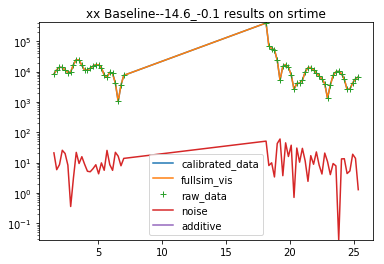

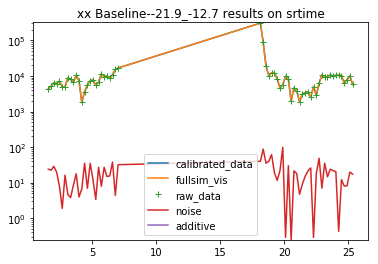

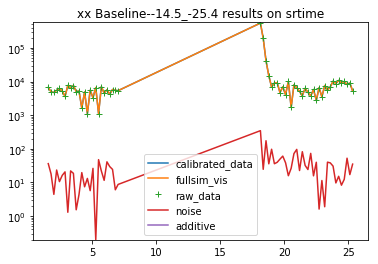

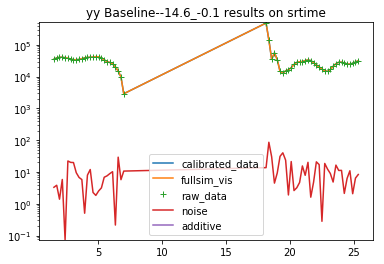

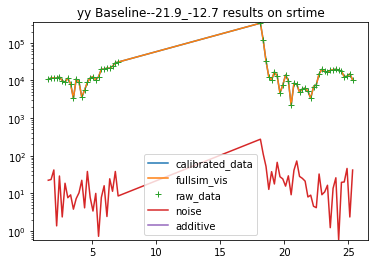

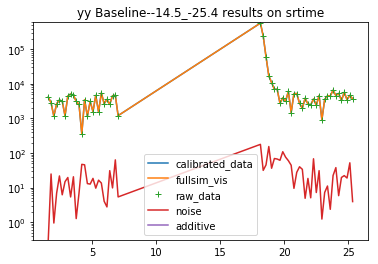

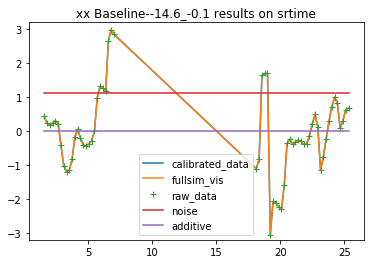

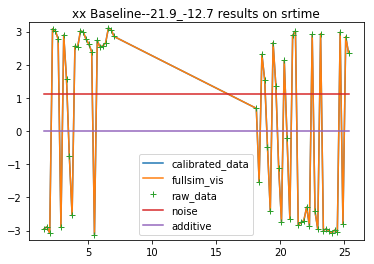

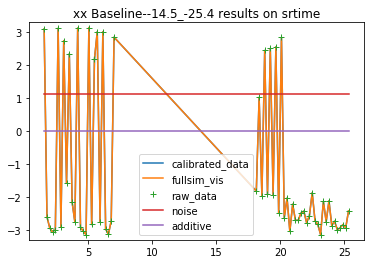

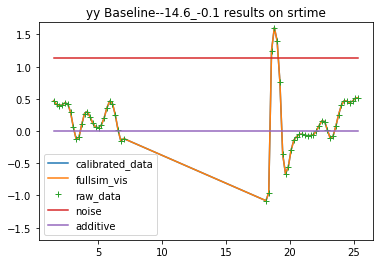

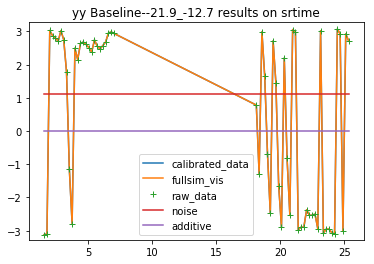

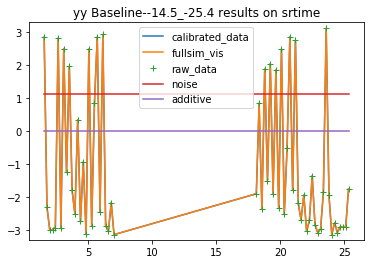

In [52]:
try:
	if plot_data_error:
		# plt.clf()
		
		cdata = get_complex_data(data)
		crdata = get_complex_data(raw_data)  # / (additive_sol[0] * (pre_ampcal) + (not pre_ampcal))
		cNi = get_complex_data(Ni)
		
		fun = np.abs
		srt = sorted((lsts - lst_offset) % 24. + lst_offset)
		asrt = np.argsort((lsts - lst_offset) % 24. + lst_offset)
		pncol = min(int(60. / (srt[-1] - srt[0])), 12) if nt_used > 1 else (len(ubl_sort['x'])/2)
		us = ubl_sort['x'][::len(ubl_sort['x']) / pncol] if len(ubl_sort['x']) / pncol >= 1 else ubl_sort['x']
		figure = {}
		#		plt.figure(400)
		#		plt.subplots_adjust(hspace=1.2,wspace=0.7)
		for p in range(2):
			for nu, u in enumerate(us):
				plt.figure(5000 + 100 * p + nu)
				# plt.subplot(5, (len(us) + 4) / 5, nu + 1)
				figure[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
				figure[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
				figure[3], = plt.plot(srt, fun(crdata[u, p][asrt]), '+', label='raw_data')
				figure[4], = plt.plot(srt, fun(cNi[u, p][asrt]) ** -.5, label='Ni')
				if pre_calibrate:
					figure[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(fun(cadd[u, p]))])  # 5 * np.max(np.abs(fun(cNi[u, p]))),
				else:
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p])))])  # 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.yscale('log')
				plt.title("%s Baseline-%.1f_%.1f results on srtime" % (['xx', 'yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
				plt.ylim([-1.05 * data_range, 1.05 * data_range])
				if pre_calibrate:
					plt.legend(handles=[figure[1], figure[2], figure[3], figure[4], figure[5]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise', 'additive'], loc=0)
				else:
					plt.legend(handles=[figure[1], figure[2], figure[3], figure[4]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise'], loc=0)
				plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Abs_Full_vis-%s-%.2fMHz-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard))
				plt.show(block=False)
			
		fun = np.angle
		for p in range(2):
			for nu, u in enumerate(us):
				plt.figure(50000 + 100 * p + nu)
				# plt.subplot(5, (len(us) + 4) / 5, nu + 1)
				figure[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
				figure[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
				figure[3], = plt.plot(srt, fun(crdata[u, p][asrt]), '+', label='raw_data')
				figure[4], = plt.plot(srt, fun(cNi[u, p][asrt]) ** -.5, label='Ni')
				if pre_calibrate:
					figure[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(fun(cadd[u, p]))])  # 5 * np.max(np.abs(fun(cNi[u, p]))),
				else:
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p])))])  # 5 * np.max(np.abs(fun(cNi[u, p])))
				#plt.yscale('log')
				plt.title("%s Baseline-%.1f_%.1f results on srtime" % (['xx', 'yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
				plt.ylim([-1.05 * data_range, 1.05 * data_range])
				if pre_calibrate:
					plt.legend(handles=[figure[1], figure[2], figure[3], figure[4], figure[5]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise', 'additive'], loc=0)
				else:
					plt.legend(handles=[figure[1], figure[2], figure[3], figure[4]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise'], loc=0)
				plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Angle_Full_vis-%s-%.2fMHz-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard))
				plt.show(block=False)
			
	
	# plt.gcf().clear()
	# plt.clf()
	# plt.close()
except:
	print('Error when Plotting Calibrated Results.')
    
Del=True
if Del:
	try:
		del(crdata)
		del(cNi)
		del(cdata)
		del(cadd)
	except:
		pass
	
sys.stdout.flush()


In [53]:
################
####Use N and the par file generated by pixel_parameter_search to determine dynamic pixel parameters
################
if seek_optimal_threshs:
	par_result_filename = full_sim_filename.replace('.simvis', '_par_search.npz')
	par_file = np.load(par_result_filename)
	qualified_par_mask = (par_file['err_norm'] / np.sum(1./Ni)**.5) < dynamic_precision
	index_min_pix_in_mask = np.argmin(par_file['n_pix'][qualified_par_mask])
	thresh, valid_pix_thresh = par_file['parameters'][qualified_par_mask][index_min_pix_in_mask]
print "<<<<<<<<<<<<picked std thresh %.3f, pix thresh %.1e"%(thresh, valid_pix_thresh)

sys.stdout.flush()

<<<<<<<<<<<<picked std thresh 2.000, pix thresh 1.0e-04


In [54]:
########################################################################
########################processing dynamic pixelization######################
########################################################################
gsm_beamweighted = equatorial_GSM_standard * beam_weight
if AtNiA_only:
	valid_npix = pixel_scheme_number
	pixel_scheme_file = np.load(pixel_directory + 'pixel_scheme_%i_%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s.npz' % (valid_npix, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard)
	fake_solution_map = pixel_scheme_file['gsm']
	thetas = pixel_scheme_file['thetas']
	phis = pixel_scheme_file['phis']
	sizes = pixel_scheme_file['sizes']
	nside_distribution = pixel_scheme_file['nside_distribution']
	final_index = pixel_scheme_file['final_index']
	npix = pixel_scheme_file['n_fullsky_pix']
	valid_pix_mask = pixel_scheme_file['valid_pix_mask']
	thresh = pixel_scheme_file['thresh']
else:
	nside_distribution = np.zeros(12 * nside_standard ** 2)
	final_index = np.zeros(12 * nside_standard ** 2, dtype=int)
	thetas, phis, sizes = [], [], []
	abs_thresh = np.mean(gsm_beamweighted) * thresh
	pixelize(gsm_beamweighted, nside_distribution, nside_standard, nside_start, abs_thresh,
			 final_index, thetas, phis, sizes)
	npix = len(thetas)
	valid_pix_mask = hpf.get_interp_val(gsm_beamweighted, thetas, phis, nest=True) > valid_pix_thresh * max(gsm_beamweighted)
	valid_npix = np.sum(valid_pix_mask)
	print '>>>>>>VALID NPIX =', valid_npix
	
	fake_solution_map = np.zeros_like(thetas)
	for i in range(len(fake_solution_map)):
		fake_solution_map[i] = np.sum(equatorial_GSM_standard[final_index == i])
	fake_solution_map = fake_solution_map[valid_pix_mask]
	sizes = np.array(sizes)[valid_pix_mask]
	thetas = np.array(thetas)[valid_pix_mask]
	phis = np.array(phis)[valid_pix_mask]
	np.savez(pixel_directory + 'pixel_scheme_%i_%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s.npz' % (valid_npix, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard), gsm=fake_solution_map, thetas=thetas, phis=phis, sizes=sizes, nside_distribution=nside_distribution, final_index=final_index, n_fullsky_pix=npix, valid_pix_mask=valid_pix_mask, thresh=thresh)  
                                # thresh is in there for idiotic reason  due to unneccessary inclusion of thresh in A filename

if not fit_for_additive:
	fake_solution = np.copy(fake_solution_map)
else:
	fake_solution = np.concatenate((fake_solution_map, np.zeros(4 * nUBL_used)))

def sol2map(sol):
	solx = sol[:valid_npix]
	full_sol = np.zeros(npix)
	full_sol[valid_pix_mask] = solx / sizes
	return full_sol[final_index]

def sol2additive(sol):
	return np.transpose(sol[valid_npix:].reshape(nUBL_used, 2, 2), (1, 0, 2))#ubl by pol by re/im before transpose


>>>>>>VALID NPIX = 10960


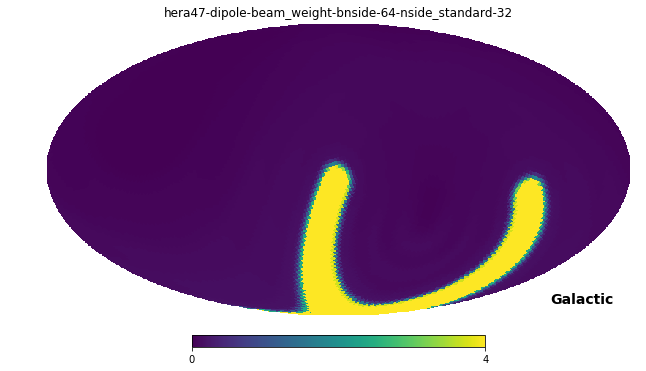

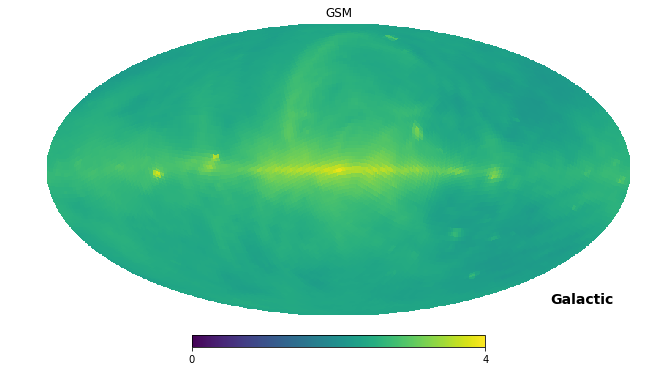

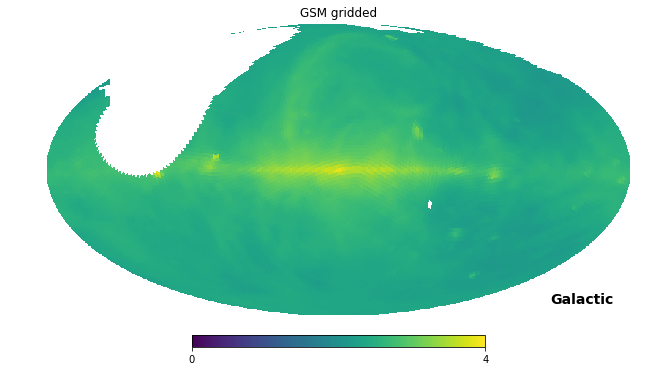

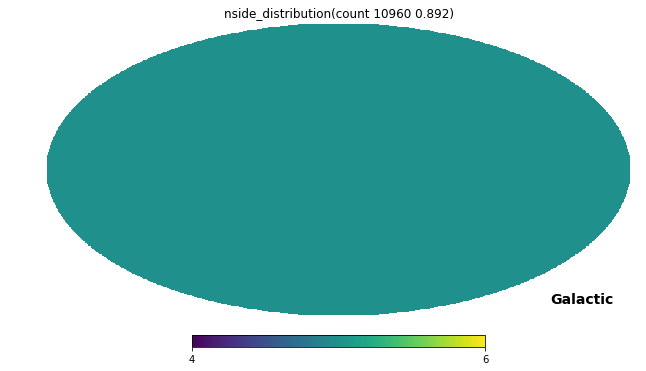

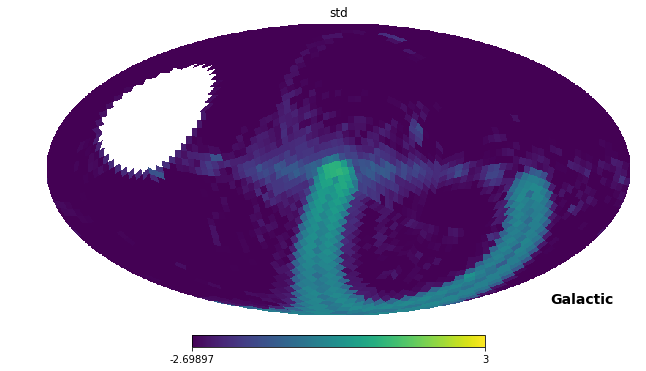

In [55]:
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)
	plotcoord = 'CG'
	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		# plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s' % (INSTRUMENT, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%sMHz-dipole-beam_weight-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%sMHz-bnside-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std-%s-%s-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s'%(INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'),
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		plt.show(block=False)
# plt.gcf().clear()

sys.stdout.flush()

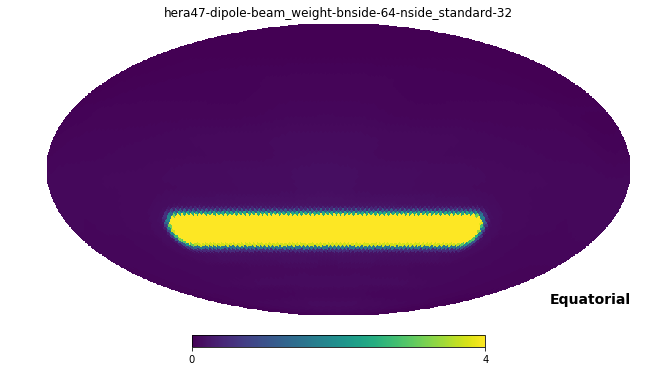

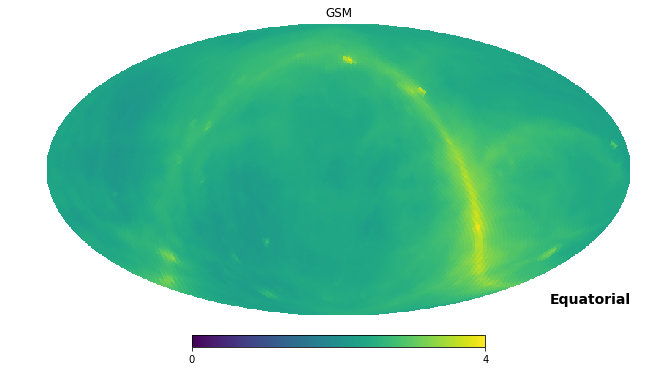

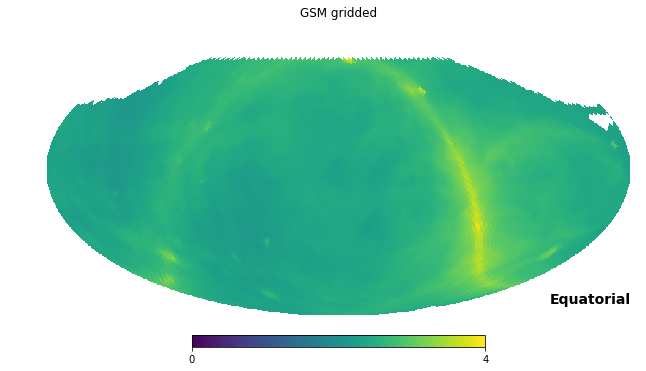

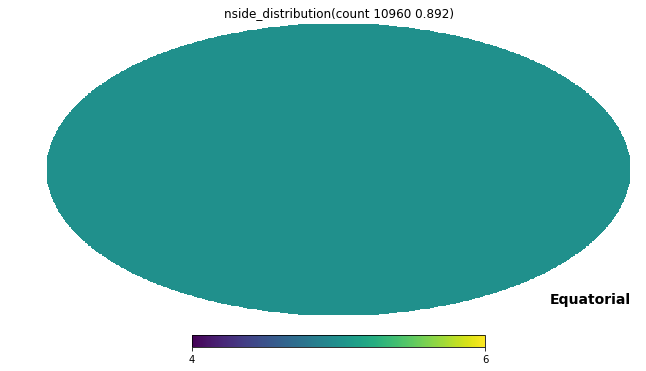

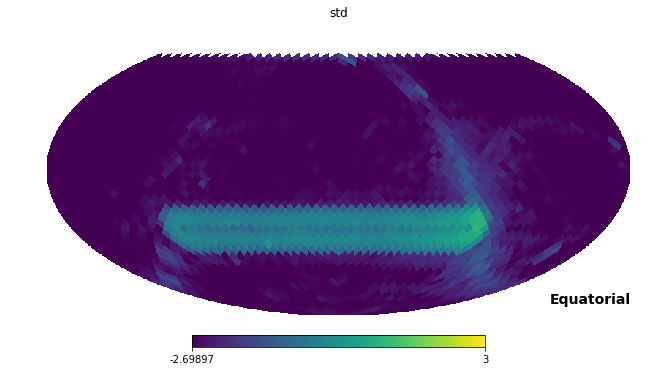

In [56]:
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)
	plotcoord = 'C'
	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		# plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s' % (INSTRUMENT, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%sMHz-dipole-beam_weight-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%sMHz-bnside-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std-%s-%s-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s'%(INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'),
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		plt.show(block=False)
# plt.gcf().clear()

sys.stdout.flush()

In [57]:
##################################################################
####################compute dynamic A matrix########################
###############################################################
A_tag = 'A_dI'
A_filename = A_tag + '_u%i_t%i_mtbin%s-mfbin%s-tbin%s_p%i_n%i_%i_b%i_%.3f_v%.1f' % (nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', valid_npix, nside_start, nside_standard, bnside, thresh, A_version)
A_path = datadir + tag + A_filename
AtNiA_tag = 'AtNiA_N%s' % vartag
if not fit_for_additive:
	AtNiA_tag += "_noadd"
elif crosstalk_type == 'autocorr':
	AtNiA_tag += "_autocorr"
if pre_ampcal:
	AtNiA_tag += "_ampcal"
AtNiA_filename = AtNiA_tag + A_filename
AtNiA_path = datadir + tag + AtNiA_filename
if os.path.isfile(AtNiA_path) and AtNiA_only and not force_recompute:
	sys.exit(0)


def get_A(additive_A=None):
	if os.path.isfile(A_path) and not force_recompute:
		print "Reading A matrix from %s" % A_path
		sys.stdout.flush()
		A = np.fromfile(A_path, dtype='complex128').reshape((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used))
	else:
		
		print "Computing A matrix..."
		sys.stdout.flush()
		A = np.empty((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used), dtype='complex128')
		timer = time.time()
		for n in range(valid_npix):
			ra = phis[n]
			dec = PI / 2 - thetas[n]
			print "\r%f%% completed, %f minutes left" % (
				100. * float(n) / (valid_npix), float(valid_npix - n) / (n + 1) * (float(time.time() - timer) / 60.)),
			sys.stdout.flush()
			
			A[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_x, tlist=lsts) / 2  # xx and yy are each half of I
			A[:, -1, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_y, tlist=lsts) / 2
		
		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		A.tofile(A_path)
	
	# #put in autocorr regardless of whats saved on disk
	# for i in range(nUBL_used):
	#     for p in range(2):
	#         A[i, p, :, valid_npix + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
	#         A[i, p, :, valid_npix + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]
	
	A.shape = (nUBL_used * 2 * nt_used, A.shape[-1])
	if not fit_for_additive:
		A = A[:, :valid_npix]
	else:
		A[:, valid_npix:] = additive_A[:, 1:]
	# Merge A
	try:
		return np.concatenate((np.real(A), np.imag(A))).astype('complex128')
	except MemoryError:
		print "Not enough memory, concatenating A on disk ", A_path + 'tmpre', A_path + 'tmpim',
		sys.stdout.flush()
		Ashape = list(A.shape)
		Ashape[0] = Ashape[0] * 2
		np.real(A).tofile(A_path + 'tmpre')
		np.imag(A).tofile(A_path + 'tmpim')
		del (A)
		os.system("cat %s >> %s" % (A_path + 'tmpim', A_path + 'tmpre'))
		
		os.system("rm %s" % (A_path + 'tmpim'))
		A = np.fromfile(A_path + 'tmpre', dtype='complex128').reshape(Ashape)
		os.system("rm %s" % (A_path + 'tmpre'))
		print "done."
		sys.stdout.flush()
		return A.astype('complex128')


if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)

Ashape0, Ashape1 = A.shape

# for ipix in hpf.ang2pix(nside_standard, thetas, phis, nest=True):
#     if

print "Memory usage: %fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

print "Memory usage: %fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

sys.stdout.flush()


def get_vis_normalization(data, clean_sim_data):
	a = np.linalg.norm(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	b = np.linalg.norm(clean_sim_data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	return a.dot(b) / b.dot(b)


Computing A matrix...
74.178832% completed, 0.188052 minutes left                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [58]:
tlist

array([15.01222222, 15.23012241, 15.4480226 , 15.66592279, 15.88382298,
       16.10172316, 16.31962335, 16.53752354, 16.75542373, 16.97332392,
       17.19122411, 17.40912429, 17.62702448, 17.84492467, 18.06282486,
       18.28072505, 18.49862524, 18.71652542, 18.93442561, 19.1523258 ,
       19.37022599, 19.58812618, 19.80602637, 20.02392655, 20.24182674,
       20.45972693, 20.67762712, 20.89552731, 21.1134275 , 21.33132768,
       21.54922787, 21.76712806, 21.98502825, 22.20292844, 22.42082863,
       22.63872881, 22.856629  , 23.07452919, 23.29242938, 23.51032957,
       23.72822976, 23.94612994, 24.16403013, 24.38193032, 24.59983051,
       24.8177307 , 25.03563089, 25.25353107, 25.47143126, 25.68933145,
       25.90723164, 26.12513183, 26.34303202, 26.5609322 , 26.77883239,
       26.99673258, 27.21463277, 27.43253296, 27.65043315, 27.86833333])

In [59]:
Integration_Time
np.sum(Ni**-1)**.5

(1945.9549258383533+0j)

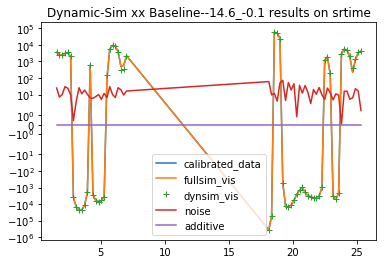

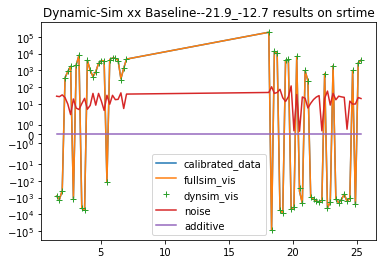

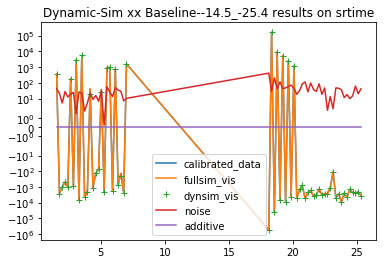

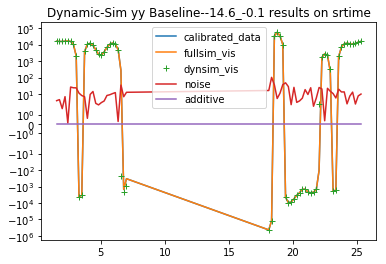

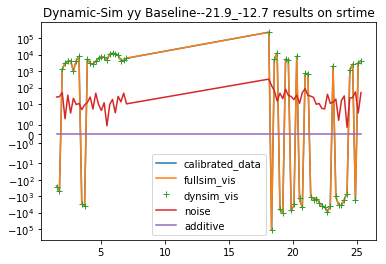

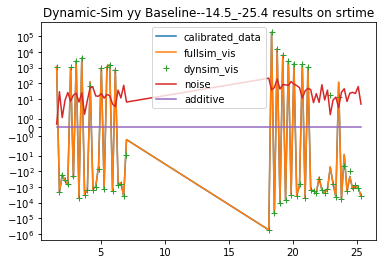

total deviation between dynamic and full sim compared to sim:  0.003002479545155328
total deviation between dynamic and full sim compared to data noise:  (4.815429929860001+0j)


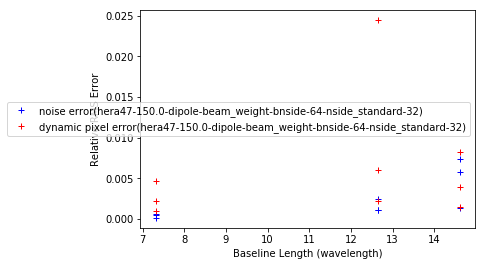

Normalization from visibilities 1.0


In [60]:
##############
# simulate visibilities according to the pixelized A matrix
##############
clean_sim_data = A.dot(fake_solution.astype(A.dtype))

try:
	if plot_data_error:
		cdata = get_complex_data(data)
		cdynamicmodel = get_complex_data(clean_sim_data)
		cNi = get_complex_data(Ni)
		if pre_calibrate:
			cadd = get_complex_data(additive_term)
		
		fun = np.imag
		srt = sorted((lsts - lst_offset) % 24. + lst_offset)
		asrt = np.argsort((lsts - lst_offset) % 24. + lst_offset)
		pncol = min(int(60. / (srt[-1] - srt[0])), 12) if nt_used > 1 else (len(ubl_sort['x'])/2)
		us = ubl_sort['x'][::len(ubl_sort['x']) / pncol] if len(ubl_sort['x']) / pncol >= 1 else ubl_sort['x']
		# plt.clf()
		#	plt.figure(60)
		#	for p in range(2):
		#		for nu, u in enumerate(us):
		#
		#			plt.subplot(2, len(us), len(us) * p + nu + 1)
		#			plt.plot(srt, fun(cdata[u, p][asrt]))
		#			plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
		#			plt.plot(srt, fun(cdynamicmodel[u, p][asrt]))
		#			plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
		#			if pre_calibrate:
		#				plt.plot(srt, fun(cadd[u, p][asrt]))
		#			data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p])))])
		#			plt.title("%.1f,%.1f"%(used_common_ubls[u, 0], used_common_ubls[u, 1]))
		#			plt.ylim([-1.05*data_range, 1.05*data_range])
		#
		#	print "total deviation between dynamic and full sim compared to sim", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
		#	print "total deviation between dynamic and full sim compared to data noise", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
		#	plt.savefig(script_dir + '/../Output/data_error_dynamic-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
		#	plt.show(block=False)
		
		figure_D = {}
		for p in range(2):
			for nu, u in enumerate(us):
				plt.figure(6000 + 100 * p + nu)
				plt.clf()
				# plt.subplot(2, len(us), len(us) * p + nu + 1)
				figure_D[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
				figure_D[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
				figure_D[3], = plt.plot(srt, fun(cdynamicmodel[u, p][asrt]), '+', label='dynsim_vis')
				figure_D[4], = plt.plot(srt, fun(cNi[u, p][asrt]) ** -.5, label='Ni')
				if pre_calibrate:
					figure_D[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p]))), np.max(fun(cadd[u, p]))])  # 5 * np.max(np.abs(fun(cNi[u, p])))
				else:
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p])))])  # 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.title("Dynamic-Sim %s Baseline-%.1f_%.1f results on srtime" % (['xx', 'yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
				plt.yscale('symlog')
				# plt.ylim([-1.05 * data_range, 1.05 * data_range])
				if pre_calibrate:
					plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4], figure_D[5]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise', 'additive'], loc=0)
				else:
					plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise'], loc=0)
				plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Dynamic_Vis-%s-%.2fMHz-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard)) #-nubl%s-nt%s-tbin%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, precal_time_bin, bnside, nside_standard))
				plt.show(block=False)
		# plt.clf()
		# plt.gcf().clear()
		print "total deviation between dynamic and full sim compared to sim: ", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
		print "total deviation between dynamic and full sim compared to data noise: ", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni ** -1) ** .5
		
		plt.figure(70)
		try:
			fullsim_vis2 = 4 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis' % (nUBL_used + 1, nt_used, nside_standard / 2, bnside), dtype='complex128').reshape((2, nUBL_used + 1, nt_used))[:, :-1].transpose((1, 0, 2))
			plt.plot(la.norm(used_common_ubls, axis=-1) * freq / C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)' % (INSTRUMENT, bnside, nside_standard))
			plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, bnside, nside_standard))
		except:
			try:
				fullsim_vis2 = .25 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis' % (nUBL_used + 1, nt_used, nside_standard * 2, bnside), dtype='complex128').reshape((2, nUBL_used + 1, nt_used))[:, :-1].transpose((1, 0, 2))
				plt.plot(la.norm(used_common_ubls, axis=-1) * freq / C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)' % (INSTRUMENT, bnside, nside_standard))
				plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, bnside, nside_standard))
			except:
				pass
		# plt.clf()
		plt.plot(la.norm(used_common_ubls, axis=-1) * freq / C, np.sum(2. / np.real(get_complex_data(Ni)), axis=-1)[:, 0] ** .5 / la.norm(fullsim_vis, axis=-1)[:, 0], 'b+', label='noise error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)' % (INSTRUMENT, freq, bnside, nside_standard))
		#	plt.legend()
		#	plt.xlabel('Baseline Length (wavelength)')
		#	plt.ylabel('Relative RMS Error')
		#plt.savefig(script_dir + '/../Output/noise_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s-%.2fMHz-nubl%s-nt%s-tbin%s.png' % (INSTRUMENT, bnside, nside_standard, freq, nUBL_used, nt_used, precal_time_bin))
		#	plt.show(block=False)
		#	plt.gcf().clear()
		# plt.clf()
		plt.plot(la.norm(used_common_ubls, axis=-1) * freq / C, la.norm(fullsim_vis - cdynamicmodel, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'r+', label='dynamic pixel error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)' % (INSTRUMENT, freq, bnside, nside_standard))
		plt.legend(loc=0)
		plt.xlabel('Baseline Length (wavelength)')
		plt.ylabel('Relative RMS Error')
		plt.savefig(script_dir + '/../Output/noise_and_dynamic_pixel_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s-%.2fMHz-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.png' % (INSTRUMENT, bnside, nside_standard, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		plt.show(block=False)
		# plt.gcf().clear()
except:
	print ('Error when Plotting Comparison of Full and Dyna Simulation Results.')

vis_normalization = get_vis_normalization(data, stitch_complex_data(fullsim_vis))
print "Normalization from visibilities", vis_normalization

Del=True
if Del:
	try:
		del(cdata)
		del(cNi)
		del(cdynamicmodel)
	except:
		pass

sys.stdout.flush()



In [61]:
##renormalize the model
fake_solution *= vis_normalization # GSM Masked and being Normalized (abs calibration), Clean
clean_sim_data *= vis_normalization # Dynamic Simulated, Clean, being Normalized (abs calibration)
fullsim_vis *= vis_normalization # Full Simulated, Clean, being Normalized (abs calibration)
sim_data = stitch_complex_data(fullsim_vis) + np.random.randn(len(data)) / Ni ** .5 # Full Simulated, being Normalized (abs calibration), Noise
# "data" is Calibrated Full Simulated Visibilities

#add additive term
if fit_for_additive:
	sim_data.shape = (2, nUBL_used, 2, nt_used)
	sim_additive = np.random.randn(2, nUBL_used, 2) * np.median(np.abs(data)) / 2.
	sim_data = sim_data + np.array([np.outer(sim_additive[..., p], autocorr_vis_normalized[p]).reshape((2, nUBL_used, nt_used)) for p in range(2)]).transpose((1, 2, 0, 3))#sim_additive[..., None]
	sim_data = sim_data.flatten()


In [62]:
# compute AtNi.y
AtNi_data = np.transpose(A).dot((data * Ni).astype(A.dtype))
AtNi_sim_data = np.transpose(A).dot((sim_data * Ni).astype(A.dtype))
AtNi_clean_sim_data = np.transpose(A).dot((clean_sim_data * Ni).astype(A.dtype))


In [63]:
# compute S
print "computing S...",
sys.stdout.flush()
timer = time.time()

#diagonal of S consists of S_diag_I and S-diag_add
if S_type == 'none':
	S_diag = np.ones(Ashape1) * np.max(equatorial_GSM_standard)**2 * 1.e12
else:
	if 'lowI' in S_type:
		I_supress = 25.
	elif 'minI' in S_type:
		I_supress = 250.
	elif 'min2I' in S_type:
		I_supress = 2500
	elif 'min3I' in S_type:
		I_supress = 2.5*1.e4
	elif 'min4I' in S_type:
		I_supress = 2.5*1.e5
	elif 'min5I' in S_type:
		I_supress = 2.5*1.e6
	elif 'min6I' in S_type:
		I_supress = 2.5*1.e7
	elif 'min7I' in S_type:
		I_supress = 2.5*1.e8
	elif 'min8I' in S_type:
		I_supress = 2.5*1.e9
	elif 'min9I' in S_type:
		I_supress = 2.5*1.e10
	elif 'min10I' in S_type:
		I_supress = 2.5*1.e11
	elif 'min11I' in S_type:
		I_supress = 2.5*1.e12
	elif 'min12I' in S_type:
		I_supress = 2.5*1.e13
	elif 'min13I' in S_type:
		I_supress = 2.5*1.e14
	elif 'min14I' in S_type:
		I_supress = 2.5*1.e15
	elif 'min15I' in S_type:
		I_supress = 2.5*1.e16
	elif 'min16I' in S_type:
		I_supress = 2.5*1.e17
	elif 'min17I' in S_type:
		I_supress = 2.5*1.e18
	elif 'min18I' in S_type:
		I_supress = 2.5*1.e19
	elif 'min19I' in S_type:
		I_supress = 2.5 * 1.e20
	elif 'min20I' in S_type:
		I_supress = 2.5 * 1.e21
	elif 'min21I' in S_type:
		I_supress = 2.5 * 1.e22
	elif 'min22I' in S_type:
		I_supress = 2.5 * 1.e23
	elif 'maxI' in S_type:
		I_supress = 2.5*1.e-1
	elif 'ma2I' in S_type:
		I_supress = 2.5*1.e-2
	elif 'max3I' in S_type:
		I_supress = 2.5*1.e-3
	elif 'max4I' in S_type:
		I_supress = 2.5*1.e-4
	elif 'max5I' in S_type:
		I_supress = 2.5*1.e-5
	elif 'max6I' in S_type:
		I_supress = 2.5*1.e-6
	elif 'max7I' in S_type:
		I_supress = 2.5*1.e-7
	elif 'max8I' in S_type:
		I_supress = 2.5*1.e-8
	elif 'max9I' in S_type:
		I_supress = 2.5*1.e-9
	else:
		I_supress = 1.
		
	if 'Iuniform' in S_type:
		S_diag_I = (np.median(equatorial_GSM_standard) * sizes)**2 / I_supress
	else:
		S_diag_I = fake_solution_map ** 2 / I_supress  # np.array([[1+pol_frac,0,0,1-pol_frac],[0,pol_frac,pol_frac,0],[0,pol_frac,pol_frac,0],[1-pol_frac,0,0,1+pol_frac]]) / 4 * (2*sim_x_clean[i])**2

	data_max = np.transpose(np.percentile(np.abs(data.reshape((2, nUBL_used, 2, nt_used))), 95, axis=-1), (1, 2, 0)).flatten()
	if 'min2add' in S_type:
		add_supress = 1000000.
	elif 'minadd' in S_type:
		add_supress = 10000.
	elif 'lowadd' in S_type:
		add_supress = 100.
	else:
		add_supress = 1

	if 'adduniform' in S_type:
		S_diag_add = np.ones(nUBL_used * 4) * np.median(data_max)**2 / add_supress
	else:
		S_diag_add = data_max**2 / add_supress

	if not fit_for_additive:
		S_diag = S_diag_I.astype('complex128')
	else:
		S_diag = np.concatenate((S_diag_I, S_diag_add)).astype('complex128')
	print "Done."
	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()


computing S... Done.
0.000033 minutes used


Applying Regularized AtNiAi... Memory usage: 9020563.000MB
Reading A matrix from /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/../../../HERA_MapMaking_VisibilitySimulation/scripts/../Output/hera47-150.000000-ampcal-A_dI_u9_t60_tbin60_p10960_n32_32_b64_2.000_v1.0


Casting complex values to real discards the imaginary part


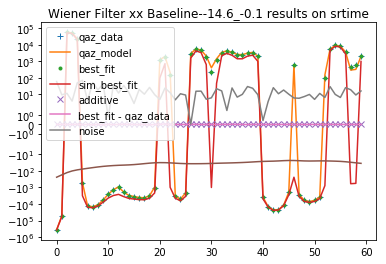

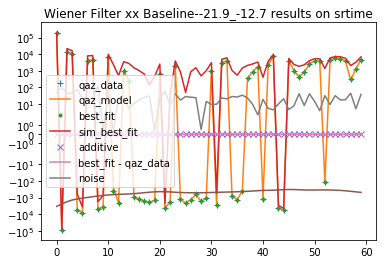

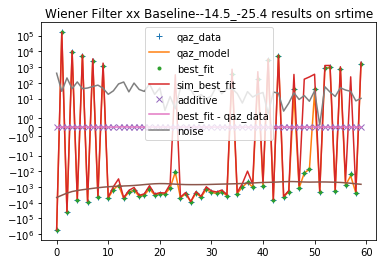

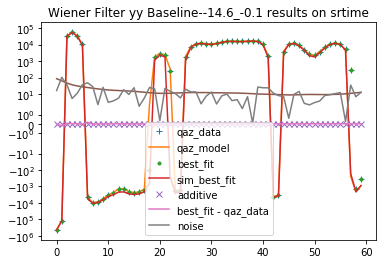

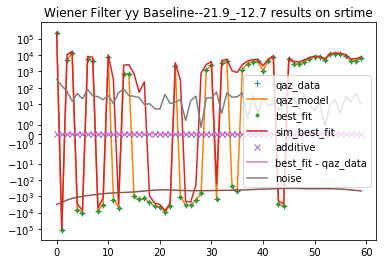

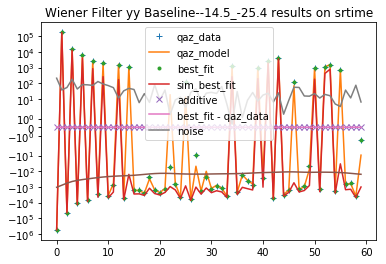

In [66]:
precision = 'complex128'
AtNiAi_tag = 'AtNiASii' + "_u%i_t%i_mtbin%s-mfbin%s-tbin%s_p%i_n%i_%i_b%i"%(nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', valid_npix, nside_start, nside_standard, bnside)
if not fit_for_additive:
	AtNiAi_version = 0.3
elif crosstalk_type == 'autocorr':
	AtNiAi_version = 0.2
else:
	AtNiAi_version = 0.1
if pre_ampcal:
	AtNiAi_version += 1.
# rcond_list = 10.**np.arange(-9., -2., 1.)

AtNiAi_candidate_files = glob.glob(datadir + tag + AtNiAi_tag + '_S%s_RE*_N%s_v%.1f' % (S_type, vartag, AtNiAi_version) + A_filename)
if len(AtNiAi_candidate_files) > 0 and not force_recompute_AtNiAi and not force_recompute and not force_recompute_S and not AtNiA_only:
	rcond = 10 ** min([float(fn.split('_RE')[1].split('_N')[0]) for fn in AtNiAi_candidate_files])
	
	AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f' % (S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
	AtNiAi_path = datadir + tag + AtNiAi_filename
	
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)
else:
	if os.path.isfile(AtNiA_path) and not force_recompute:
		print "Reading AtNiA...",
		sys.stdout.flush()
		AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))
	else:
		print "Allocating AtNiA..."
		sys.stdout.flush()
		timer = time.time()
		AtNiA = np.zeros((A.shape[1], A.shape[1]), dtype=precision)
		print "Computing AtNiA...", datetime.datetime.now()
		sys.stdout.flush()
		ATNIA(A, Ni, AtNiA)
		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		AtNiA.tofile(AtNiA_path)
	if AtNiA_only:
		sys.exit(0)
	del (A)
	AtNiA_diag = np.diagonal(AtNiA)
	print "Computing Regularized AtNiAi, %s, expected time %f min" % (datetime.datetime.now(), 88. * (len(S_diag) / 4.6e4) ** 3.),
	sys.stdout.flush()
	timer = time.time()
	# if la.norm(S) != la.norm(np.diagonal(S)):
	#     raise Exception("Non-diagonal S not supported yet")
	
	for rcond in rcond_list:
		# add Si on top of AtNiA without renaming AtNiA to save memory
		maxAtNiA = np.max(AtNiA)
		AtNiA.shape = (len(AtNiA) ** 2)
		if Add_S_diag:
			AtNiA[::len(S_diag) + 1] += 1. / S_diag
		
		print 'trying', rcond,
		sys.stdout.flush()
		try:
			AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f' % (S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
			AtNiAi_path = datadir + tag + AtNiAi_filename
			if Add_Rcond:
				AtNiA[::len(S_diag) + 1] += maxAtNiA * rcond
			AtNiA.shape = (Ashape1, Ashape1)
			AtNiAi = sv.InverseCholeskyMatrix(AtNiA).astype(precision)
			del (AtNiA)
			AtNiAi.tofile(AtNiAi_path, overwrite=True)
			print "%f minutes used" % (float(time.time() - timer) / 60.)
			print "regularization stength", (maxAtNiA * rcond) ** -.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes)
			break
		except:
			AtNiA[::len(S_diag) + 1] -= maxAtNiA * rcond
			continue

sys.stdout.flush()

In [64]:
print "Applying Regularized AtNiAi...",
sys.stdout.flush()
w_solution = AtNiAi.dotv(AtNi_data)
w_GSM = AtNiAi.dotv(AtNi_clean_sim_data)
w_sim_sol = AtNiAi.dotv(AtNi_sim_data)
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

del (AtNiAi)

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)

best_fit = A.dot(w_solution.astype(A.dtype))  # Reversely-Calculated-masked-GSM Dynamically simulated Visibilities.
best_fit_no_additive = A[..., :valid_npix].dot(w_solution[:valid_npix].astype(A.dtype))

sim_best_fit = A.dot(w_sim_sol.astype(A.dtype))
sim_best_fit_no_additive = A[..., :valid_npix].dot(w_sim_sol[:valid_npix].astype(A.dtype))

try:
	if plot_data_error:
		qaz_model = (clean_sim_data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][
			1])  # Dynamic Simulated, Clean, being Normalized    # * vis_normalization
		qaz_data = np.copy(data).reshape(2, data_shape['xx'][0], 2,
										 data_shape['xx'][1])  # Full Simulated, Calibrated, reference for normalization
		if pre_calibrate:
			qaz_add = np.copy(additive_term).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
		pncol = min(int(60. / (srt[-1] - srt[0])), 12) if nt_used > 1 else (len(ubl_sort['x'])/2)
		us = ubl_sort['x'][::len(ubl_sort['x']) / pncol] if len(ubl_sort['x']) / pncol >= 1 else ubl_sort[
			'x']  # [::max(1, len(ubl_sort['x'])/70)]
		best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
		best_fit_no_additive.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
		sim_best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
		ri = 1
		
		figure_W = {}
		for p in range(2):
			
			for nu, u in enumerate(us):
				plt.figure(8000 + 10 * p + nu)
				# plt.subplot(6, (len(us) + 5) / 6, nu + 1)
				# plt.errorbar(range(nt_used), qaz_data[ri, u, p], yerr=Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
				figure_W[1], = plt.plot(qaz_data[ri, u, p], '+')
				figure_W[2], = plt.plot(qaz_model[ri, u, p], '-')
				figure_W[3], = plt.plot(best_fit[ri, u, p], '.')
				figure_W[4], = plt.plot(sim_best_fit[ri, u, p])
				if pre_calibrate:
					figure_W[5], = plt.plot(qaz_add[ri, u, p], 'x')
				if fit_for_additive:
					figure_W[6], = plt.plot(autocorr_vis_normalized[p] * sol2additive(w_solution)[p, u, ri])
				figure_W[7], = plt.plot(best_fit[ri, u, p] - qaz_data[ri, u, p])
				figure_W[8], = plt.plot(Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p] ** -.5)
				if pre_calibrate:
					data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])),
										 np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(
							np.abs((best_fit[ri, u, p] - qaz_data[
								ri, u, p])))])  # np.max(np.abs(qaz_add[ri, u, p])), #, 5 * np.max(np.abs(fun(cNi[u, p])))
					plt.legend(
						handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[5], figure_W[7], figure_W[8]],
						labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'additive', 'best_fit - qaz_data',
								'noise'], loc=0)
				else:
					data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])),
										 np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(
							np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))])  # , 5 * np.max(np.abs(fun(cNi[u, p])))
					plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[7], figure_W[8]],
							   labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'best_fit - qaz_data', 'noise'],
							   loc=0)
				plt.yscale('symlog')
				#plt.ylim([-1.05 * data_range, 1.05 * data_range])
				# plt.title("%.1f,%.1f,%.1e"%(used_common_ubls[u, 0], used_common_ubls[u, 1], la.norm(best_fit[ri, u, p] - qaz_data[ri, u, p])))
				plt.title("Wiener Filter %s Baseline-%.1f_%.1f results on srtime" % (
					['xx', 'yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
				plt.savefig(
					script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-WienerFilter_Vis-%s-%.2fMHz-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard))
				plt.show(block=False)
except:
	print('Error when Plotting Various Methods.')


sys.stdout.flush()

Allocating AtNiA...
Computing AtNiA... 2018-03-20 14:02:49.211734
Estimated time for A 2160 by 10996 3.39520940928 minutes 0/20: 0.01999mins 1/20: 0.02215mins 2/20: 0.02555mins 3/20: 0.02885mins 4/20: 0.03140mins 5/20: 0.03560mins 6/20: 0.03566mins 7/20: 0.03708mins 8/20: 0.03864mins 9/20: 0.03804mins 10/20: 0.04126mins 11/20: 0.03886mins 12/20: 0.03801mins 13/20: 0.03814mins 14/20: 0.04219mins 15/20: 0.04090mins 16/20: 0.03859mins 17/20: 0.03886mins 18/20: 0.03986mins 19/20: 0.03934mins 0.712785 minutes used
Computing Regularized AtNiAi, 2018-03-20 14:03:34.318790, expected time 1.202025 min trying 1e-15 0.825993 minutes used
regularization stength (6705.891166309382+0j) median GSM ranges between 284.40705646940046 284.40705646940046


In [65]:
S_type
I_supress

1.0

In [67]:
def plot_IQU(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), min=0, max=4, coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)

def plot_IQU_unlimit(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)


In [68]:
rescale_factor = np.max(np.abs(fake_solution))/ np.max(np.abs(w_solution))

In [69]:
%matplotlib inline

In [70]:
print('Number of Positive w_solution Pixels: %s'%len(w_solution[w_solution>=0]))
print('Number of Positive w_GSM Pixels: %s'%len(w_GSM[w_GSM>=0]))
print('Number of Positive w_sim Pixels: %s'%len(w_sim_sol[w_sim_sol>=0]))
print('Number of Positive GSM Pixels: %s'%len(fake_solution[fake_solution>=0]))

Number of Positive w_solution Pixels: 7579
Number of Positive w_GSM Pixels: 7569
Number of Positive w_sim Pixels: 7363
Number of Positive GSM Pixels: 10996


divide by zero encountered in log10


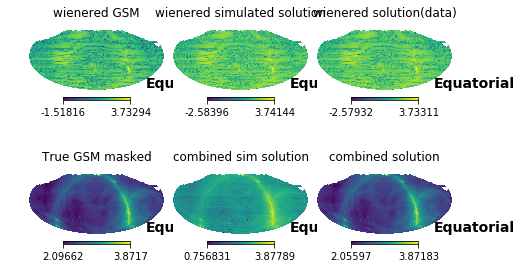

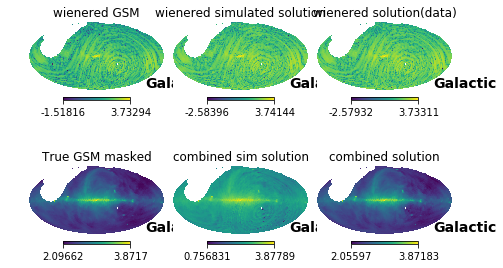

In [71]:
crd = 0
for coord in ['C', 'CG']:
	# plt.clf()
	plt.figure(900 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM), 'wienered GSM', 1, coord=coord)  # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord)  # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-rescale-none-unlimit-S-%s-recond-%s.png' % (coord, INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
# plt.gcf().clear()

divide by zero encountered in log10


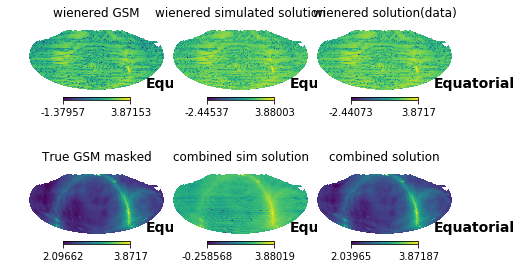

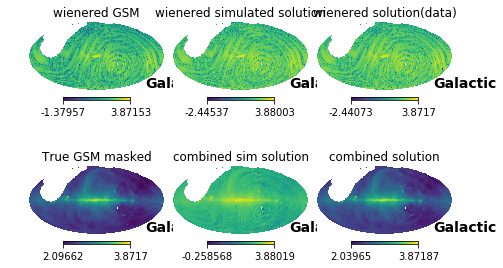

In [72]:
crd = 0
for coord in ['C', 'CG']:
	# plt.clf()
	plt.figure(9000000 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord)  # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord)  # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-rescale-%s-unlimit-S-%s-recond-%s.png' % (coord, INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
# plt.gcf().clear()

divide by zero encountered in log10


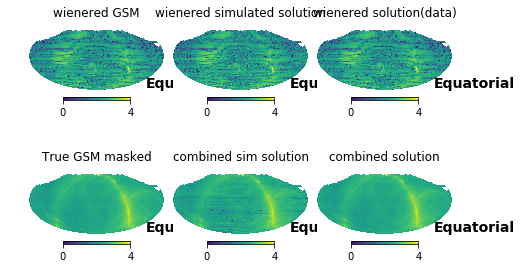

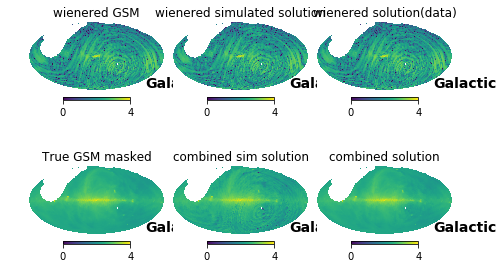

In [73]:
crd = 0
for coord in ['C', 'CG']:
	# plt.clf()
	plt.figure(9500000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord)  # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord)  # (~noise+data)
	plot_IQU(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-rescale-%s-limit-S-%s-recond-%s.png' % (coord, INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
# plt.gcf().clear()

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


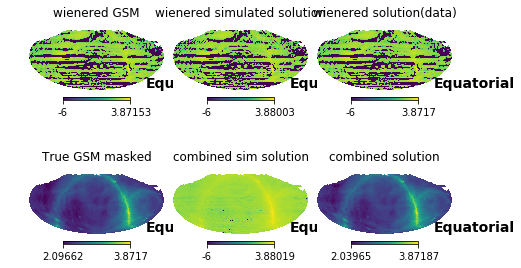

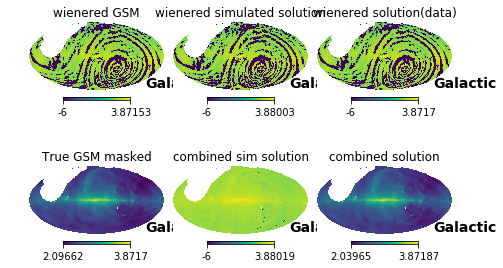

In [74]:
crd = 0
for coord in ['C', 'CG']:
	# plt.clf()
	plt.figure(950 + crd)
	crd += 10
	plot_IQU_unlimit((w_GSM + np.abs(w_GSM)) * 0.5 * rescale_factor + 1.e-6, 'wienered GSM', 1, coord=coord)  # (clean dynamic_data)
	plot_IQU_unlimit((w_sim_sol + np.abs(w_sim_sol)) * 0.5 * rescale_factor + 1.e-6, 'wienered simulated solution', 2, coord=coord)  # (~noise+data)
	plot_IQU_unlimit((w_solution + np.abs(w_solution)) * 0.5 * rescale_factor + 1.e-6, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit((fake_solution + np.abs(fake_solution)) * 0.5, 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit((((w_sim_sol - w_GSM) * rescale_factor + fake_solution) + np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution)) * 0.5 + 1.e-6, 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit((((w_solution - w_GSM) * rescale_factor + fake_solution) + np.abs((w_solution - w_GSM) * rescale_factor + fake_solution)) * 0.5 + 1.e-6, 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-rescale-%s-denegative-unlimit-S-%s-recond-%s.png' % (coord, INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
# plt.gcf().clear()

divide by zero encountered in log10


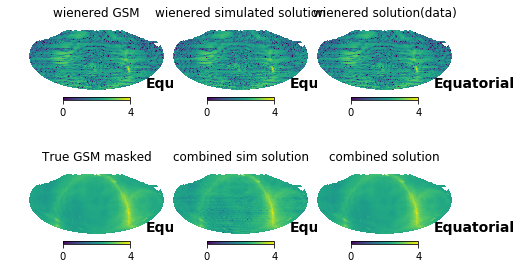

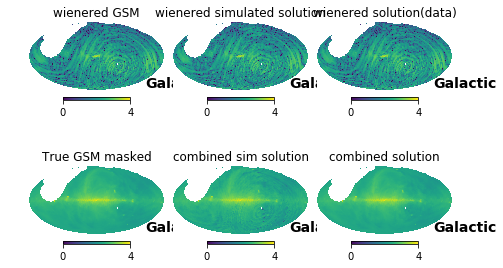

In [75]:
crd = 0
for coord in ['C', 'CG']:
	# plt.clf()
	plt.figure(90000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM), 'wienered GSM', 1, coord=coord)  # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord)  # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png' % (coord, INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
# plt.gcf().clear()

divide by zero encountered in log10


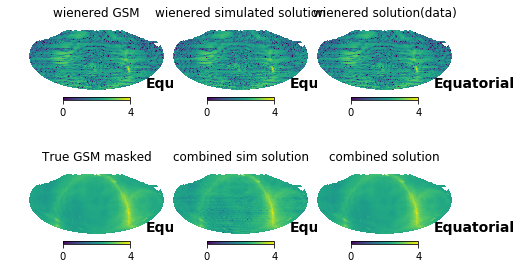

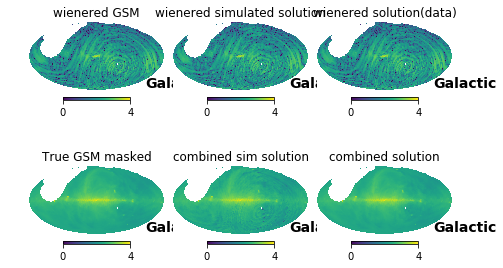

In [76]:
crd = 0
for coord in ['C', 'CG']:
	# plt.clf()
	plt.figure(9000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM / vis_normalization), 'wienered GSM', 1, coord=coord)  # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol / vis_normalization), 'wienered simulated solution', 2, coord=coord)  # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution / vis_normalization), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM + fake_solution) / vis_normalization), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM + fake_solution) / vis_normalization), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener_renormalized-%s-%s-%sMHz-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png' % (coord, INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
# plt.gcf().clear()

chi^2 = 3.705e-04, data points 2160, pixels 10960
re/im chi2 2.861e-04, 8.444e-05
xx/yy chi2 1.004e-04, 2.701e-04


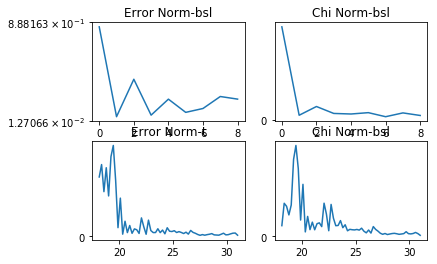

Additive_sol: [1.+0.j 1.+0.j]
Rescale_factor: 1.3759082247383494
('regularization stength', (6705.891166309382+0j), 'median GSM ranges between', 284.40705646940046, 284.40705646940046)


In [77]:
error = data.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])) - best_fit
chi = error * (Ni.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1]))) ** .5
print "chi^2 = %.3e, data points %i, pixels %i" % (la.norm(chi) ** 2, len(data), valid_npix)
print "re/im chi2 %.3e, %.3e" % (la.norm(chi[0]) ** 2, la.norm(chi[1]) ** 2)
print "xx/yy chi2 %.3e, %.3e" % (la.norm(chi[:, :, 0]) ** 2, la.norm(chi[:, :, 1]) ** 2)
# plt.clf()
plt.figure(120)
plt.subplot(2, 2, 1)
plt.plot([la.norm(error[:, u]) for u in ubl_sort['x']])
plt.title('Error Norm-bsl')
plt.yscale('symlog')
plt.subplot(2, 2, 2)
plt.plot([la.norm(chi[:, u]) for u in ubl_sort['x']])
plt.title('Chi Norm-bsl')
plt.yscale('symlog')
plt.subplot(2, 2, 3)
plt.plot(lsts, [la.norm(error[..., t]) for t in range(error.shape[-1])])
plt.title('Error Norm-t')
plt.yscale('symlog')
plt.subplot(2, 2, 4)
plt.plot(lsts, [la.norm(chi[..., t]) for t in range(error.shape[-1])])
plt.title('Chi Norm-bsl')
plt.yscale('symlog')
plt.savefig(script_dir + '/../Output/chi-%s-%s-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-%s-recond-%s.png' % (INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
plt.show(block=False)
# plt.gcf().clear()

try:
	print('Additive_sol: %s' % additive_sol[:2])
	print('Rescale_factor: %s' % rescale_factor)
	print ("regularization stength", (maxAtNiA * rcond) ** -.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes))
except:
	pass

sys.stdout.flush()

In [78]:
#S_type = 'none'
#point spread function:
if True and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	plt.figure(130)
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			iplot += 1
			choose_plots = [1, 12, 24]
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis) 
				hpv.mollview(np.log10(np.abs(spreaded)), nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
				plt.savefig(script_dir + '/../Output/spreaded_function-CG-onepage-%s-%s-%s-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-%s-recond-%s.png'%(INSTRUMENT, iplot, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
				plt.show(block=False)
	plt.show(block=False)
	#plt.gcf().clear()

In [79]:
print AtNiA_filename
print A_filename
print AtNiA_tag

AtNiA_N_2018_autocorr_ampcalA_dI_u9_t60_tbin60_p10960_n32_32_b64_2.000_v1.0
A_dI_u9_t60_tbin60_p10960_n32_32_b64_2.000_v1.0
AtNiA_N_2018_autocorr_ampcal


Reading Regularized AtNiAi... Reading AtNiA...

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


 1.5707963267948966 1.5303452820902192e-19


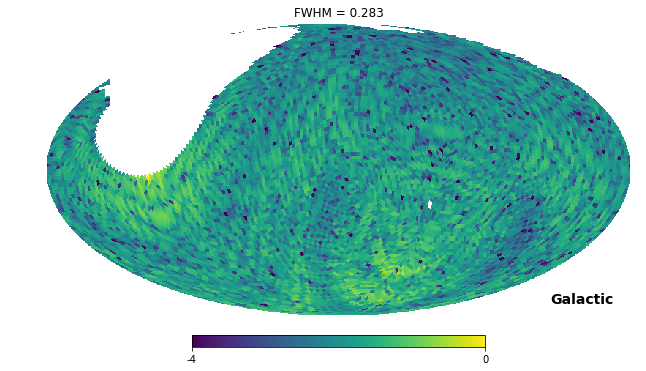

1.5707963267948966 -4.989472425290267e-19


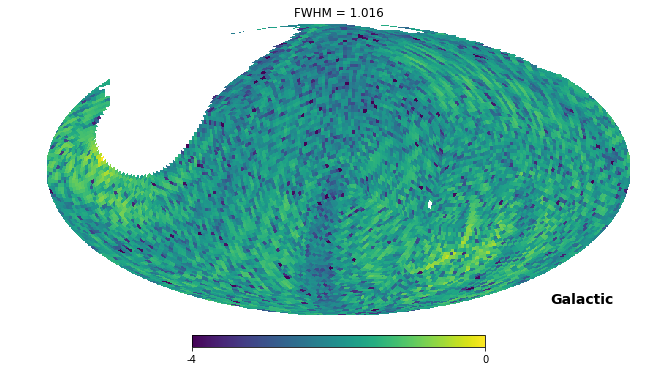

1.5707963267948966 1.5399330975793707e-17


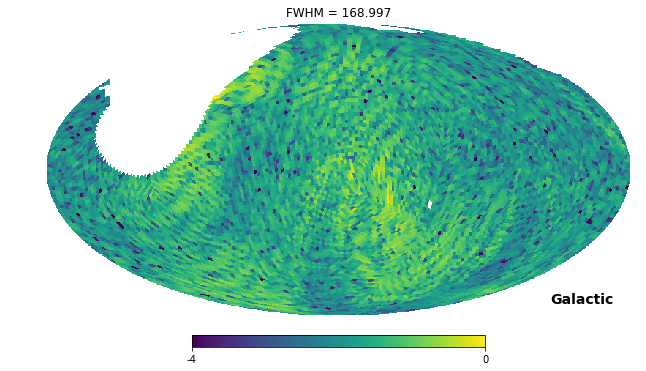

1.5707963267948966 1.5303452820902192e-19


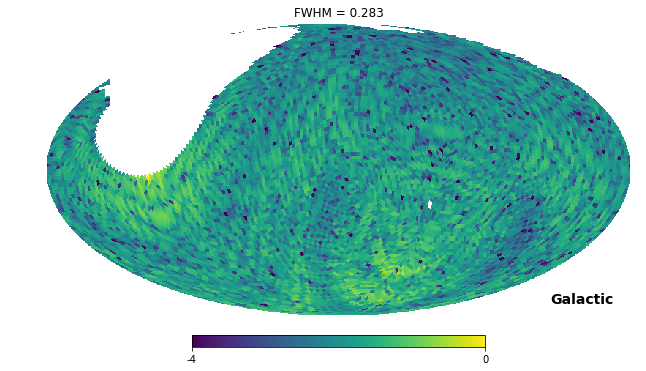

1.5707963267948966 2.9184700520836395e-18


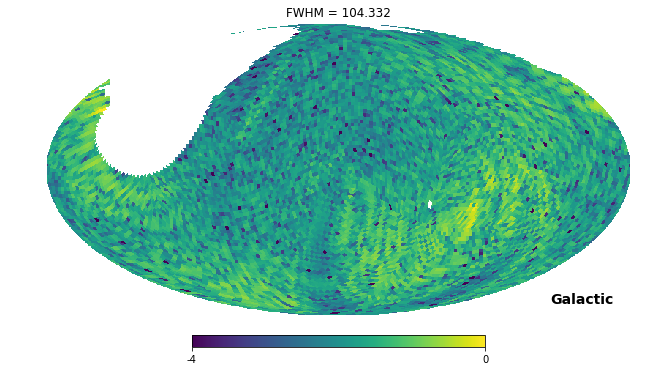

1.5707963267948966 0.0


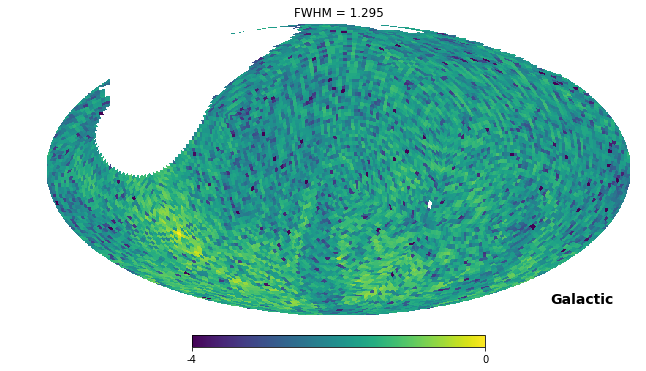

1.5707963267948966 2.4360799006581503e-17


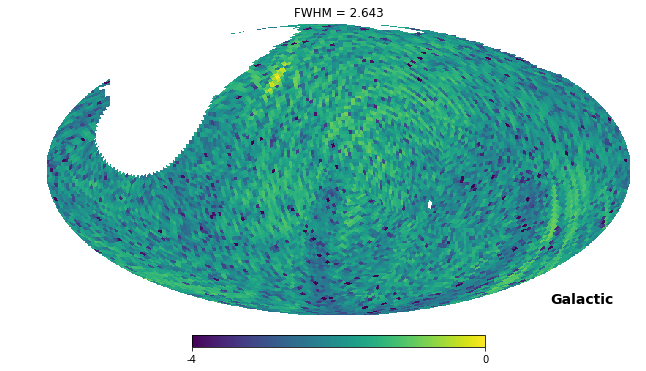

1.5707963267948966 -1.1870809270957713e-17


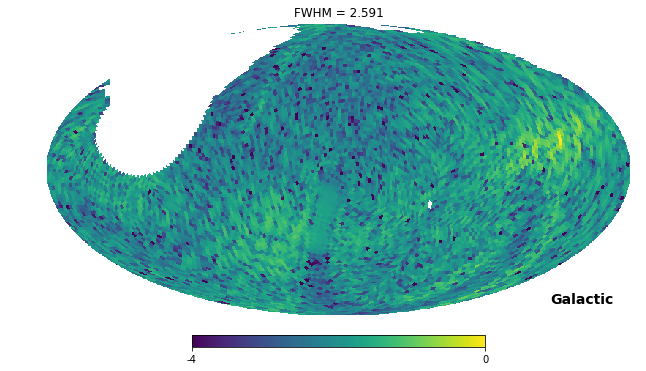

1.5707963267948966 0.0


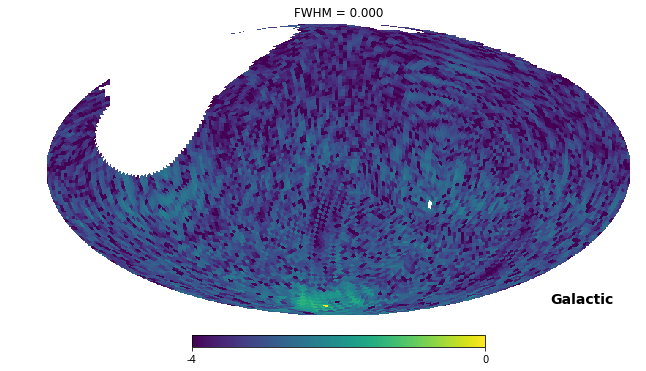

1.5707963267948963 2.4360799006581497e-17


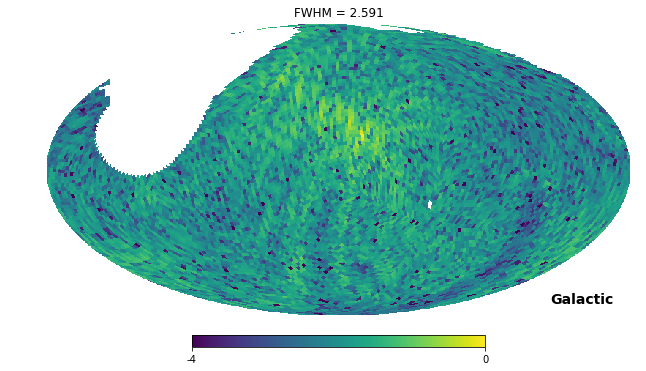

1.5707963267948966 -3.469446951953614e-18


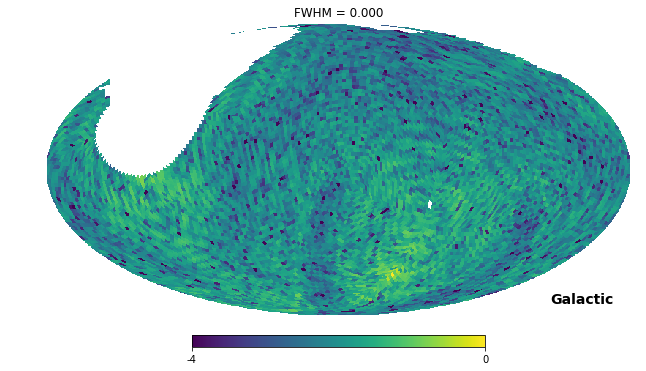

1.5707963267948966 2.7755575615628914e-17


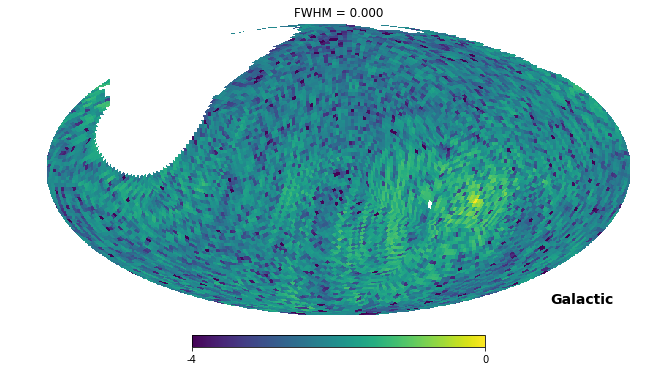

1.5707963267948966 2.8574174562725925e-18


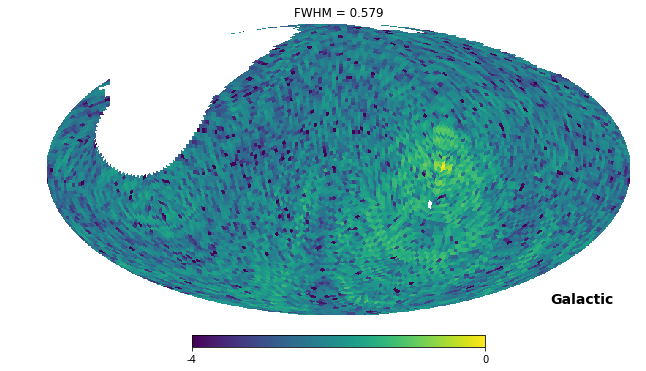

1.5707963267948966 2.7755575615628914e-17


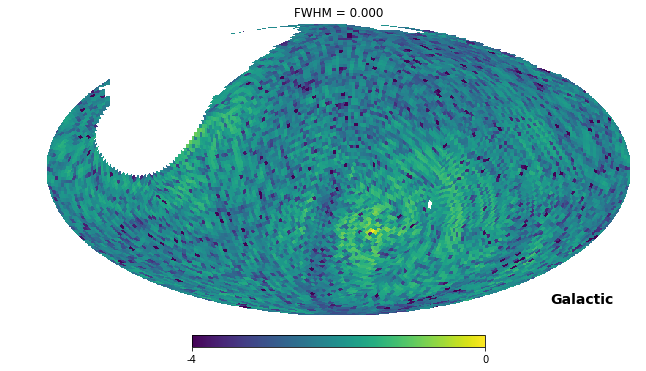

In [80]:
#S_type = 'none'
#point spread function:
if True:    # and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)
	
	AtNiA_tag = 'AtNiA_N%s' % vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))
	
	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	# plt.clf()
	
	for theta in np.arange(0, PI * .9, PI / 6.):
		for phi in np.arange(0, TPI, PI / 3.):
			
			# choose_plots = [1, 6, 12, 18, 24, 30]
			choose_plots = [0, 1, 4, 6, 8, 12, 16, 20, 24, 28, 30, 32, 33, 35]
			
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')
				
				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				# rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI / 2 - fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is ():
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]  # should print 1.57079632679 0.0 if rotation is working correctly
				
				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset) % TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis)
				plt.figure(1300 + iplot)
				# hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
				hpv.mollview(np.log10(np.abs(spreaded)), nest=True, coord='CG', title='FWHM = %.3f' % ((fwhm_theta * fwhm_phi) ** .5 * 180. / PI))
				plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-%s-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-%s-recond-%s.png'%(INSTRUMENT, iplot, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
				plt.show(block=False)
			# plt.gcf().clear()
			iplot += 1

sys.stdout.flush()

# Mac Code

In [81]:
additive_sol

array([1.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [82]:
time.time()/60.

25359487.468318548

In [83]:
data.shape

(2160,)

In [84]:
vis_data_dred_abscal

[[], []]

In [85]:
vis_normalization

1.0

In [86]:
I_supress

1.0